# 🏆 Advanced Machine Learning Competition 2026 (RUNI)
## Walmart Store Revenue Forecasting

**Team IDs:** 206910333, 209207380, 208082735

---

### Objective
Build a hierarchical forecasting model to predict daily revenue for Walmart retail stores using the M5 dataset.

### Approach
1. **Exploratory Data Analysis (EDA)**
2. **Feature Engineering** - Calendar features, lags, rolling statistics
3. **Baseline Model** - Simple approaches for benchmarking
4. **Advanced Models** - LightGBM, XGBoost
5. **Ensemble** - Combine best models
6. **Submission Generation**


## 1. Setup and Data Loading


In [1]:
# Install required packages if needed
# !pip install pandas numpy matplotlib seaborn scikit-learn lightgbm xgboost


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

print("Libraries loaded successfully!")


Libraries loaded successfully!


In [3]:
# Define paths
DATA_PATH = 'advanced-machine-learning-competition-2026-runi/'

# Load data
train_df = pd.read_csv(DATA_PATH + 'train.csv')
calendar_df = pd.read_csv(DATA_PATH + 'calendar_events.csv')
submission_df = pd.read_csv(DATA_PATH + 'forecast_submission.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Calendar events shape: {calendar_df.shape}")
print(f"Submission shape: {submission_df.shape}")


Training data shape: (18766, 4)
Calendar events shape: (162, 2)
Submission shape: (1012, 2)


In [4]:
# Display first rows
print("=" * 60)
print("TRAINING DATA")
print("=" * 60)
display(train_df.head(10))
print(f"\nData types:\n{train_df.dtypes}")
print(f"\nMissing values:\n{train_df.isnull().sum()}")


TRAINING DATA


store_id  store_name        date    revenue
0         0  All Stores  2011-01-29  204126.52
1         0  All Stores  2011-01-30  197426.42
2         0  All Stores  2011-01-31  144267.27
3         0  All Stores  2011-02-01  151903.00
4         0  All Stores  2011-02-02  117399.88
5         0  All Stores  2011-02-03  173443.45
6         0  All Stores  2011-02-04  171972.65
7         0  All Stores  2011-02-05  233619.38
8         0  All Stores  2011-02-06  208743.90
9         0  All Stores  2011-02-07  162911.75


Data types:
store_id        int64
store_name     object
date           object
revenue       float64
dtype: object

Missing values:
store_id      0
store_name    0
date          0
revenue       0
dtype: int64


In [5]:
# Convert date column
train_df['date'] = pd.to_datetime(train_df['date'])
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

print(f"Training date range: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"Calendar date range: {calendar_df['date'].min()} to {calendar_df['date'].max()}")


Training date range: 2011-01-29 00:00:00 to 2015-09-30 00:00:00
Calendar date range: 2011-02-06 00:00:00 to 2016-06-19 00:00:00


In [6]:
# Examine stores
print("Stores in the dataset:")
store_info = train_df.groupby(['store_id', 'store_name']).agg(
    count=('revenue', 'count'),
    mean_revenue=('revenue', 'mean'),
    total_revenue=('revenue', 'sum')
).reset_index()
display(store_info)


Stores in the dataset:


store_id                   store_name  count   mean_revenue  total_revenue
0          0                   All Stores   1706  237057.453165   4.044200e+08
1          1    California – Sunset Plaza   1706   28756.898025   4.905927e+07
2          2      California – Ocean View   1706   21393.611975   3.649750e+07
3          3    California – Golden Hills   1706   41134.343857   7.017519e+07
4          4  California – Redwood Center   1706   15469.155006   2.639038e+07
5          5       Texas – Lone Star Mall   1706   20081.248617   3.425861e+07
6          6     Texas – Riverwalk Market   1706   26304.039953   4.487469e+07
7          7        Texas – Alamo Heights   1706   22268.394936   3.798988e+07
8          8      Wisconsin – Maple Grove   1706   18289.555692   3.120198e+07
9          9   Wisconsin – Lakeview Plaza   1706   21709.915932   3.703712e+07
10        10  Wisconsin – Badger Crossing   1706   21650.289760   3.693539e+07

In [7]:
# Examine calendar events
print("\nCalendar Events:")
display(calendar_df.head(20))
print(f"\nUnique events: {calendar_df['event'].nunique()}")



Calendar Events:


date                   event
0  2011-02-06               SuperBowl
1  2011-02-14           ValentinesDay
2  2011-02-21           PresidentsDay
3  2011-03-09               LentStart
4  2011-03-16               LentWeek2
5  2011-03-17           StPatricksDay
6  2011-03-20               Purim End
7  2011-04-24  OrthodoxEaster, Easter
8  2011-04-26              Pesach End
9  2011-05-05           Cinco De Mayo
10 2011-05-08            Mother's day
11 2011-05-30             MemorialDay
12 2011-05-31          NBAFinalsStart
13 2011-06-12            NBAFinalsEnd
14 2011-06-19            Father's day
15 2011-07-04         IndependenceDay
16 2011-08-01          Ramadan starts
17 2011-08-31             Eid al-Fitr
18 2011-09-05                LaborDay
19 2011-10-10             ColumbusDay


Unique events: 34


In [8]:
# Parse submission file to understand forecast requirements
submission_df['store_id'] = submission_df['id'].apply(lambda x: int(x.split('_')[0]))
submission_df['date'] = submission_df['id'].apply(lambda x: pd.to_datetime(x.split('_')[1], format='%Y%m%d'))

print(f"Forecast date range: {submission_df['date'].min()} to {submission_df['date'].max()}")
print(f"Stores to forecast: {sorted(submission_df['store_id'].unique())}")
print(f"Days to forecast: {submission_df['date'].nunique()}")
display(submission_df.head())


Forecast date range: 2015-10-01 00:00:00 to 2015-12-31 00:00:00
Stores to forecast: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
Days to forecast: 92


id  prediction  store_id       date
0  0_20151001           0         0 2015-10-01
1  0_20151002           0         0 2015-10-02
2  0_20151003           0         0 2015-10-03
3  0_20151004           0         0 2015-10-04
4  0_20151005           0         0 2015-10-05

## 2. Exploratory Data Analysis (EDA)


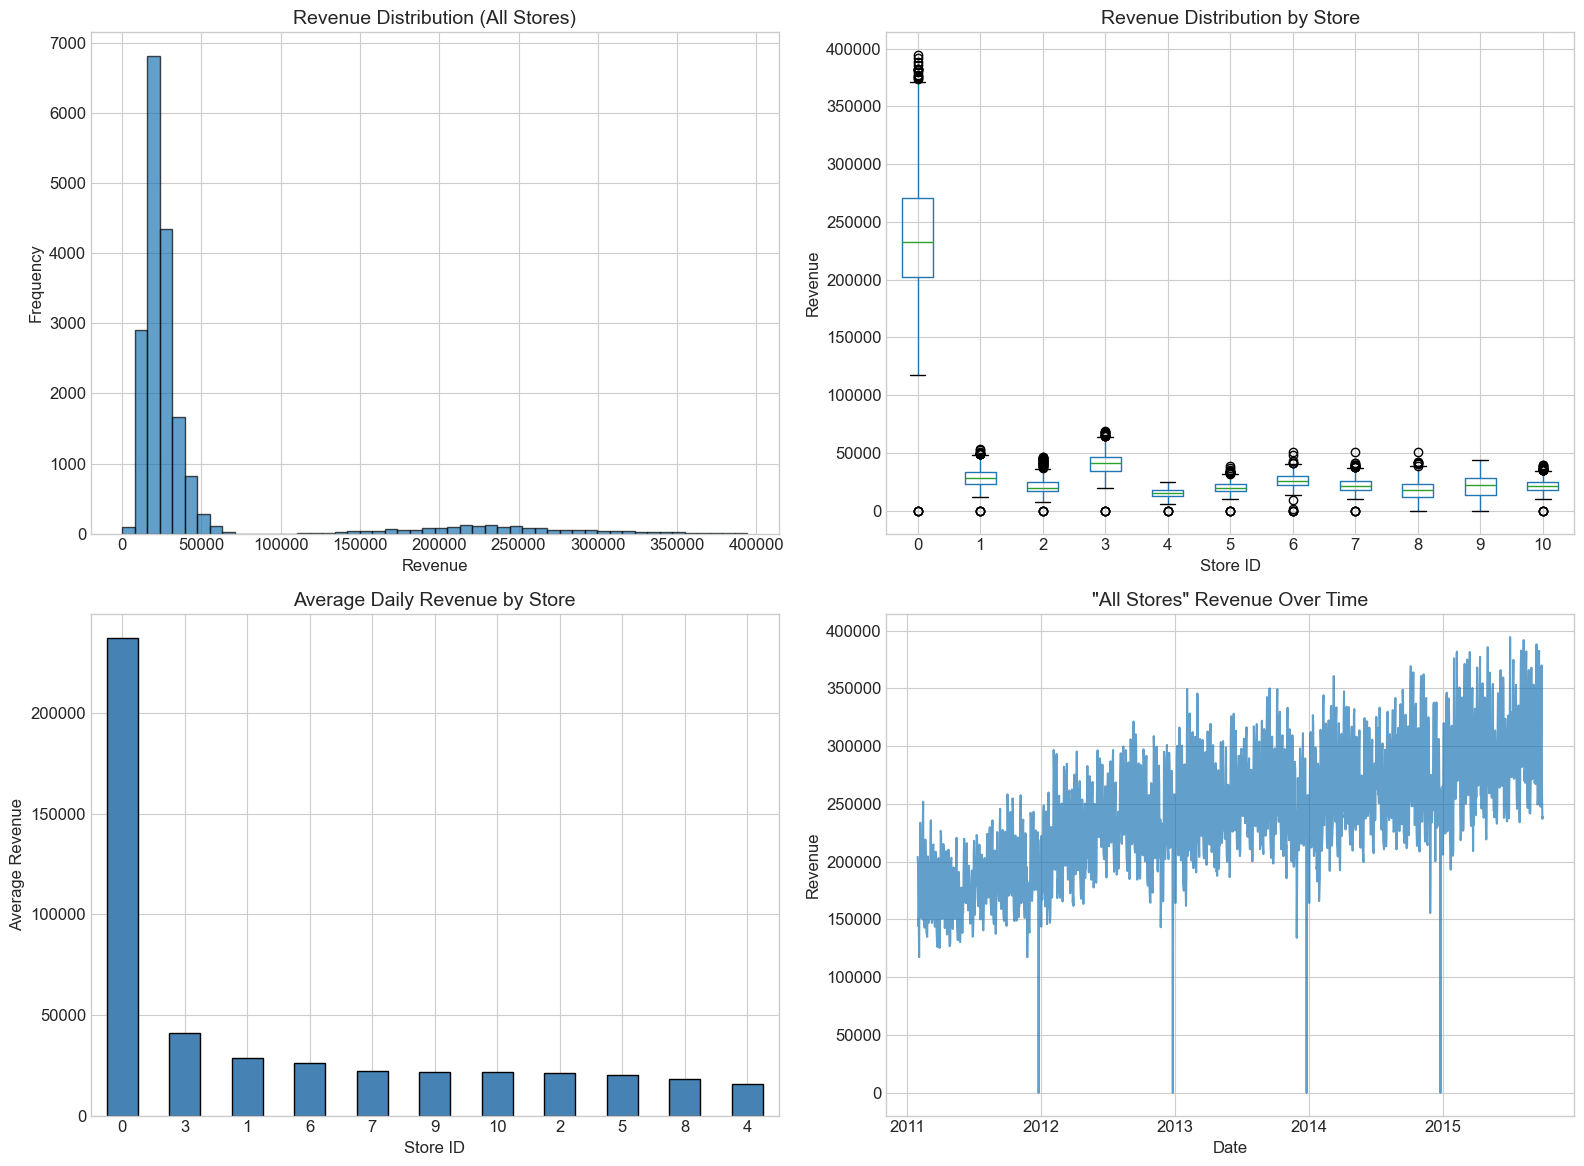

In [9]:
# Revenue distribution by store
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Overall revenue distribution
ax1 = axes[0, 0]
train_df['revenue'].hist(bins=50, ax=ax1, edgecolor='black', alpha=0.7)
ax1.set_title('Revenue Distribution (All Stores)', fontsize=14)
ax1.set_xlabel('Revenue')
ax1.set_ylabel('Frequency')

# Revenue by store (boxplot)
ax2 = axes[0, 1]
train_df.boxplot(column='revenue', by='store_id', ax=ax2)
ax2.set_title('Revenue Distribution by Store', fontsize=14)
ax2.set_xlabel('Store ID')
ax2.set_ylabel('Revenue')
plt.suptitle('')

# Average revenue by store
ax3 = axes[1, 0]
store_revenue = train_df.groupby('store_id')['revenue'].mean().sort_values(ascending=False)
store_revenue.plot(kind='bar', ax=ax3, color='steelblue', edgecolor='black')
ax3.set_title('Average Daily Revenue by Store', fontsize=14)
ax3.set_xlabel('Store ID')
ax3.set_ylabel('Average Revenue')
ax3.tick_params(axis='x', rotation=0)

# Time series of total revenue
ax4 = axes[1, 1]
all_stores = train_df[train_df['store_id'] == 0].copy()
ax4.plot(all_stores['date'], all_stores['revenue'], alpha=0.7)
ax4.set_title('"All Stores" Revenue Over Time', fontsize=14)
ax4.set_xlabel('Date')
ax4.set_ylabel('Revenue')

plt.tight_layout()
plt.show()


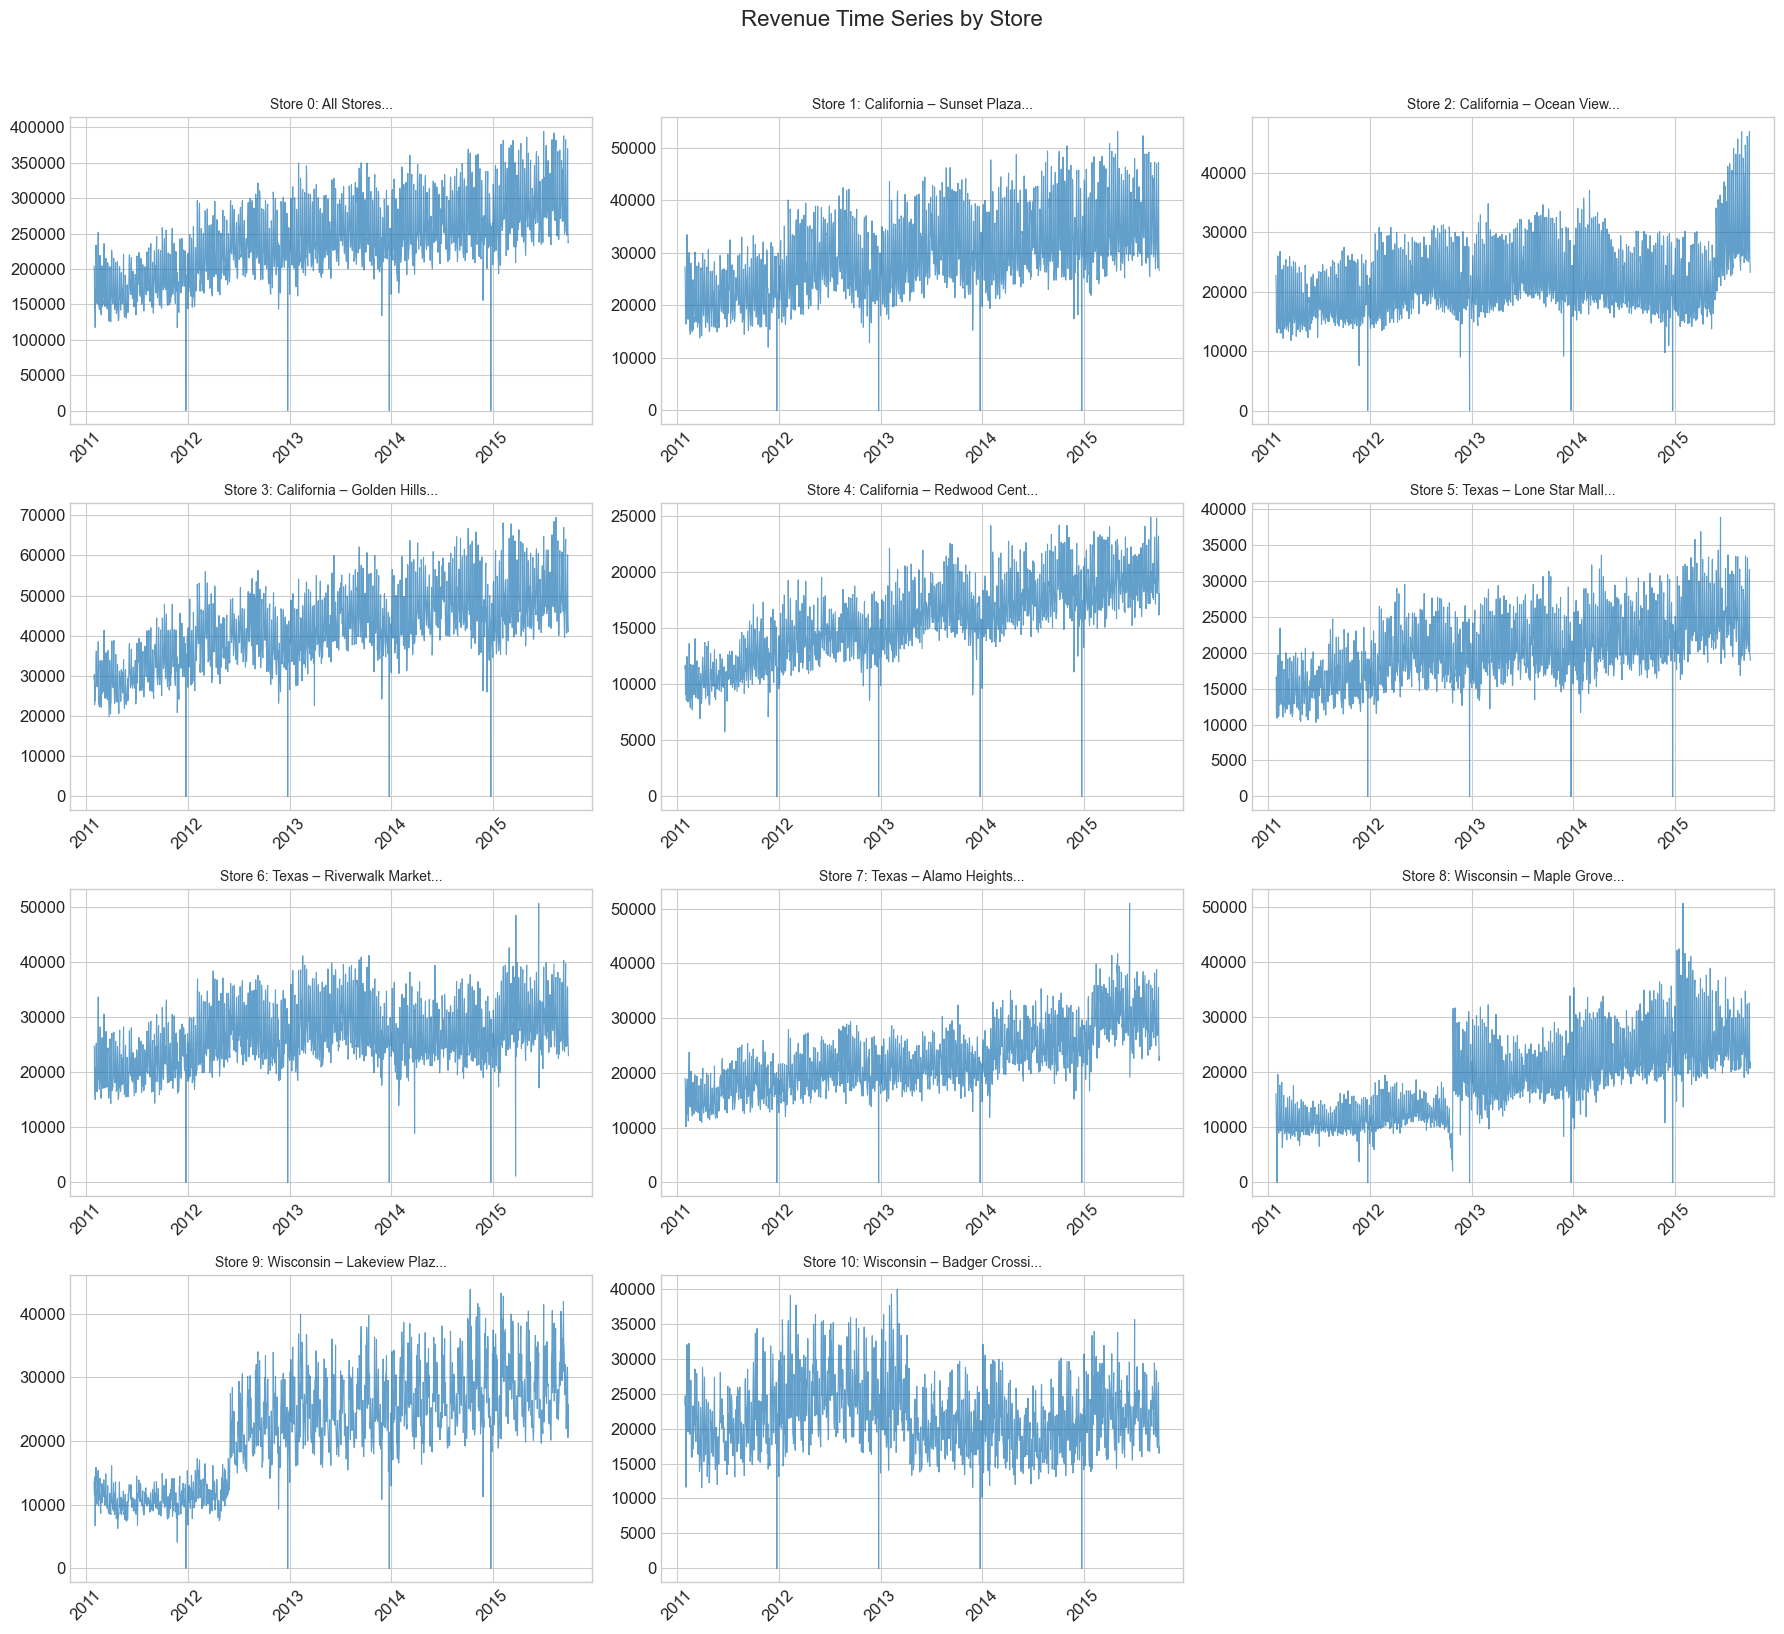

In [10]:
# Revenue time series for each store
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for idx, store_id in enumerate(sorted(train_df['store_id'].unique())):
    store_data = train_df[train_df['store_id'] == store_id]
    store_name = store_data['store_name'].iloc[0]
    
    axes[idx].plot(store_data['date'], store_data['revenue'], alpha=0.7, linewidth=0.8)
    axes[idx].set_title(f'Store {store_id}: {store_name[:25]}...', fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45)
    
# Hide extra subplot
axes[-1].axis('off')

plt.suptitle('Revenue Time Series by Store', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [11]:
# Add time features for analysis
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['day_of_week'] = train_df['date'].dt.dayofweek
train_df['day_name'] = train_df['date'].dt.day_name()
train_df['week_of_year'] = train_df['date'].dt.isocalendar().week.astype(int)
train_df['is_weekend'] = train_df['day_of_week'].isin([5, 6]).astype(int)


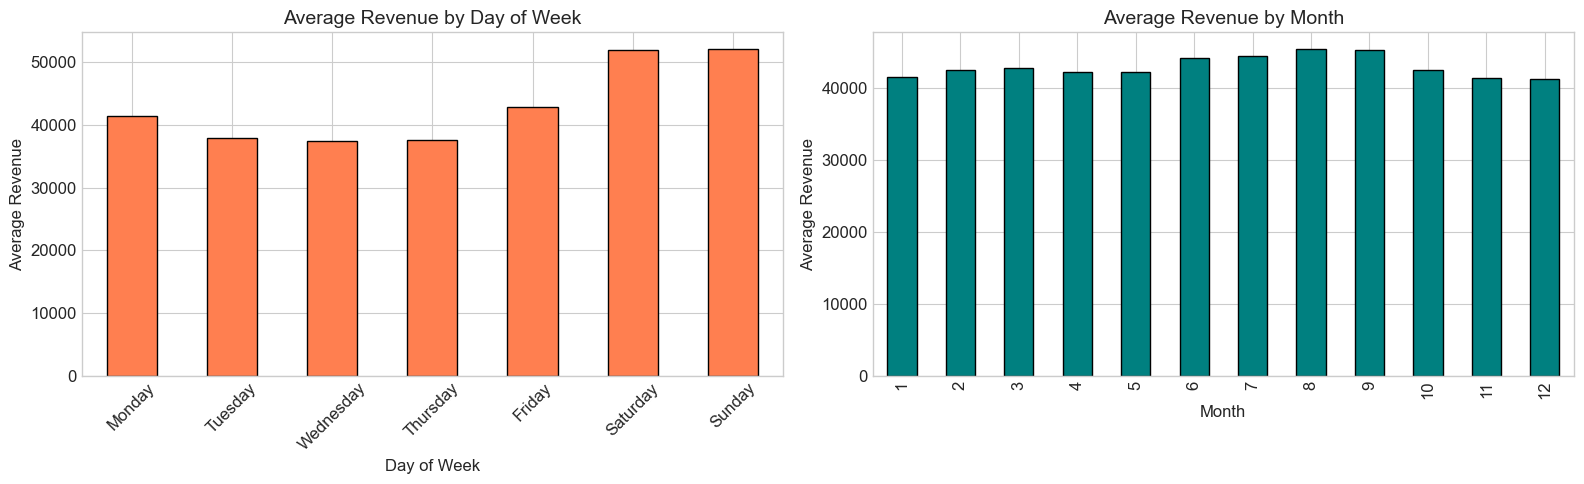

In [12]:
# Weekly seasonality
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Day of week pattern
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_pattern = train_df.groupby('day_name')['revenue'].mean().reindex(day_order)
weekly_pattern.plot(kind='bar', ax=axes[0], color='coral', edgecolor='black')
axes[0].set_title('Average Revenue by Day of Week', fontsize=14)
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Average Revenue')
axes[0].tick_params(axis='x', rotation=45)

# Monthly pattern
monthly_pattern = train_df.groupby('month')['revenue'].mean()
monthly_pattern.plot(kind='bar', ax=axes[1], color='teal', edgecolor='black')
axes[1].set_title('Average Revenue by Month', fontsize=14)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Revenue')

plt.tight_layout()
plt.show()


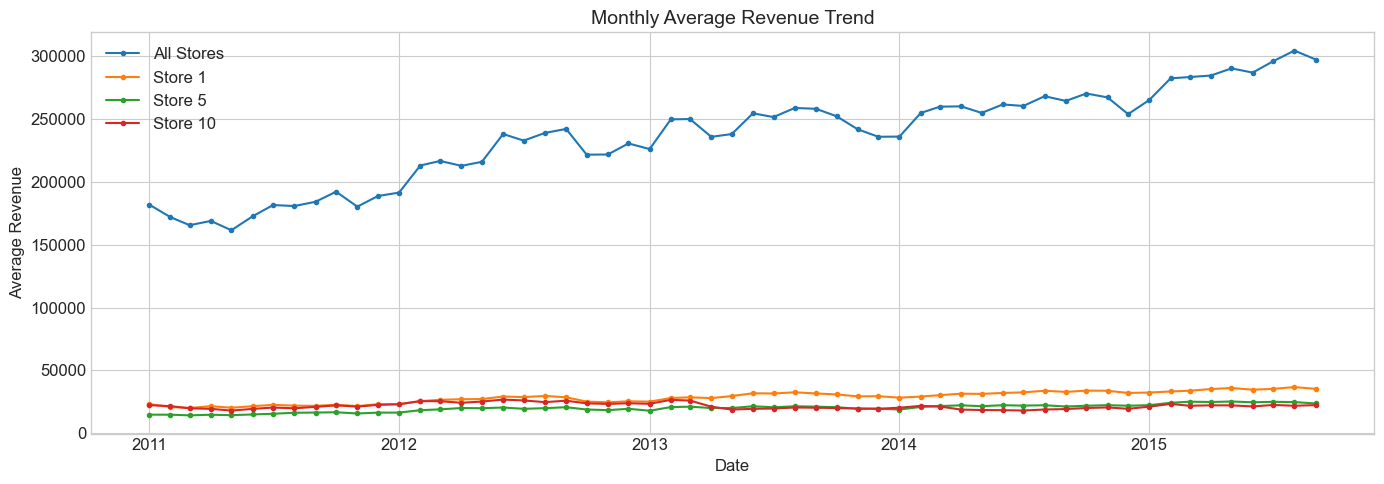

In [13]:
# Yearly trend
yearly_pattern = train_df.groupby(['year', 'month'])['revenue'].mean().reset_index()
yearly_pattern['year_month'] = pd.to_datetime(yearly_pattern[['year', 'month']].assign(day=1))

plt.figure(figsize=(14, 5))
for store_id in [0, 1, 5, 10]:
    store_data = train_df[train_df['store_id'] == store_id].groupby(['year', 'month'])['revenue'].mean().reset_index()
    store_data['year_month'] = pd.to_datetime(store_data[['year', 'month']].assign(day=1))
    label = 'All Stores' if store_id == 0 else f'Store {store_id}'
    plt.plot(store_data['year_month'], store_data['revenue'], marker='o', markersize=3, label=label)

plt.title('Monthly Average Revenue Trend', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Average Revenue')
plt.legend()
plt.tight_layout()
plt.show()


## 3. Feature Engineering


In [14]:
def create_features(df, calendar_df):
    """
    Create comprehensive features for time series forecasting.
    """
    df = df.copy()
    
    # ========== Time-based features ==========
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    
    # ========== Cyclical encoding for periodic features ==========
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    
    # ========== Calendar events ==========
    # Merge with calendar events
    calendar_df = calendar_df.copy()
    calendar_df['has_event'] = 1
    df = df.merge(calendar_df[['date', 'event', 'has_event']], on='date', how='left')
    df['has_event'] = df['has_event'].fillna(0).astype(int)
    df['event'] = df['event'].fillna('NoEvent')
    
    # Create specific event flags
    major_events = ['Christmas', 'Thanksgiving', 'Easter', 'SuperBowl', 'Independence', 
                   'MemorialDay', 'LaborDay', 'Halloween', 'ValentinesDay', 'Mother']
    for event in major_events:
        df[f'is_{event.lower()}'] = df['event'].str.contains(event, case=False, na=False).astype(int)
    
    # Days until/since major holidays (approximate)
    # Christmas proximity
    df['days_to_christmas'] = df.apply(
        lambda x: min((datetime(x['year'], 12, 25) - x['date']).days % 365,
                     (x['date'] - datetime(x['year']-1, 12, 25)).days % 365), axis=1
    )
    df['days_to_christmas'] = df['days_to_christmas'].clip(upper=30)
    
    return df


In [15]:
def add_lag_features(df, target_col='revenue', group_col='store_id', lags=[365], include_short_lags=True):
    """
    Add lag features for time series.
    For multi-step forecasting, only use lags that will be available at prediction time.
    lag_365 is always available since we have the previous year's data.
    Short-term lags (7, 14, 28) are only available during training.
    """
    df = df.sort_values(['store_id', 'date']).copy()
    
    # Always add yearly lag - this is available for forecasting
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby(group_col)[target_col].shift(lag)
    
    # Add short-term lags only if requested (for recursive forecasting)
    if include_short_lags:
        for lag in [7, 14, 28]:
            df[f'lag_{lag}'] = df.groupby(group_col)[target_col].shift(lag)
    
    return df


In [16]:
def add_rolling_features(df, target_col='revenue', group_col='store_id', windows=[7, 14, 28]):
    """
    Add rolling window statistics.
    """
    df = df.sort_values(['store_id', 'date']).copy()
    
    for window in windows:
        df[f'rolling_mean_{window}'] = df.groupby(group_col)[target_col].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
        )
        df[f'rolling_std_{window}'] = df.groupby(group_col)[target_col].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
        )
        df[f'rolling_max_{window}'] = df.groupby(group_col)[target_col].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).max()
        )
        df[f'rolling_min_{window}'] = df.groupby(group_col)[target_col].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).min()
        )
    
    return df


In [17]:
def add_expanding_features(df, target_col='revenue', group_col='store_id'):
    """
    Add expanding window (cumulative) statistics.
    """
    df = df.sort_values(['store_id', 'date']).copy()
    
    df['expanding_mean'] = df.groupby(group_col)[target_col].transform(
        lambda x: x.shift(1).expanding().mean()
    )
    
    return df


In [18]:
# Apply feature engineering to training data
print("Creating features...")
train_featured = create_features(train_df, calendar_df)
print(f"After base features: {train_featured.shape}")

train_featured = add_lag_features(train_featured)
print(f"After lag features: {train_featured.shape}")

train_featured = add_rolling_features(train_featured)
print(f"After rolling features: {train_featured.shape}")

train_featured = add_expanding_features(train_featured)
print(f"After expanding features: {train_featured.shape}")

print("\nFeatures created:")
print(train_featured.columns.tolist())


Creating features...
After base features: (18766, 34)
After lag features: (18766, 38)
After rolling features: (18766, 50)
After expanding features: (18766, 51)

Features created:
['store_id', 'store_name', 'date', 'revenue', 'year', 'month', 'day', 'day_of_week', 'day_name', 'week_of_year', 'is_weekend', 'day_of_year', 'quarter', 'is_month_start', 'is_month_end', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'event', 'has_event', 'is_christmas', 'is_thanksgiving', 'is_easter', 'is_superbowl', 'is_independence', 'is_memorialday', 'is_laborday', 'is_halloween', 'is_valentinesday', 'is_mother', 'days_to_christmas', 'lag_365', 'lag_7', 'lag_14', 'lag_28', 'rolling_mean_7', 'rolling_std_7', 'rolling_max_7', 'rolling_min_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_max_14', 'rolling_min_14', 'rolling_mean_28', 'rolling_std_28', 'rolling_max_28', 'rolling_min_28', 'expanding_mean']


In [19]:
# Check for missing values in features
missing_counts = train_featured.isnull().sum()
print("Missing values per column:")
print(missing_counts[missing_counts > 0])


Missing values per column:
lag_365            4015
lag_7                77
lag_14              154
lag_28              308
rolling_mean_7       11
rolling_std_7        22
rolling_max_7        11
rolling_min_7        11
rolling_mean_14      11
rolling_std_14       22
rolling_max_14       11
rolling_min_14       11
rolling_mean_28      11
rolling_std_28       22
rolling_max_28       11
rolling_min_28       11
expanding_mean       11
dtype: int64


## 4. Prepare Data for Modeling


In [20]:
# Define feature columns
exclude_cols = ['store_name', 'date', 'revenue', 'event', 'day_name']
feature_cols = [col for col in train_featured.columns if col not in exclude_cols]

print(f"Number of features: {len(feature_cols)}")
print(f"Features: {feature_cols}")


Number of features: 46
Features: ['store_id', 'year', 'month', 'day', 'day_of_week', 'week_of_year', 'is_weekend', 'day_of_year', 'quarter', 'is_month_start', 'is_month_end', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'has_event', 'is_christmas', 'is_thanksgiving', 'is_easter', 'is_superbowl', 'is_independence', 'is_memorialday', 'is_laborday', 'is_halloween', 'is_valentinesday', 'is_mother', 'days_to_christmas', 'lag_365', 'lag_7', 'lag_14', 'lag_28', 'rolling_mean_7', 'rolling_std_7', 'rolling_max_7', 'rolling_min_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_max_14', 'rolling_min_14', 'rolling_mean_28', 'rolling_std_28', 'rolling_max_28', 'rolling_min_28', 'expanding_mean']


In [21]:
# Remove rows with NaN in lag features (first year of data)
# We'll use data from 2012 onwards for training to have lag_365 available
train_clean = train_featured[train_featured['date'] >= '2012-02-01'].copy()
train_clean = train_clean.dropna(subset=feature_cols)

print(f"Training data shape after cleaning: {train_clean.shape}")
print(f"Date range: {train_clean['date'].min()} to {train_clean['date'].max()}")


Training data shape after cleaning: (14718, 51)
Date range: 2012-02-01 00:00:00 to 2015-09-30 00:00:00


In [22]:
# Split data for validation
# Use last 3 months of training data as validation (simulating the forecast period)
val_start = train_clean['date'].max() - timedelta(days=92)
print(f"Validation start date: {val_start}")

train_data = train_clean[train_clean['date'] < val_start].copy()
val_data = train_clean[train_clean['date'] >= val_start].copy()

print(f"Training set: {train_data.shape}, dates: {train_data['date'].min()} to {train_data['date'].max()}")
print(f"Validation set: {val_data.shape}, dates: {val_data['date'].min()} to {val_data['date'].max()}")


Validation start date: 2015-06-30 00:00:00
Training set: (13695, 51), dates: 2012-02-01 00:00:00 to 2015-06-29 00:00:00
Validation set: (1023, 51), dates: 2015-06-30 00:00:00 to 2015-09-30 00:00:00


In [23]:
# Prepare X and y
X_train = train_data[feature_cols]
y_train = train_data['revenue']
X_val = val_data[feature_cols]
y_val = val_data['revenue']

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")


X_train: (13695, 46), y_train: (13695,)
X_val: (1023, 46), y_val: (1023,)


## 5. Baseline Models


In [24]:
def calculate_rmse(y_true, y_pred):
    """Calculate RMSE."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Store baseline results
baseline_results = {}


In [25]:
# Baseline 1: Mean prediction per store
store_means = train_data.groupby('store_id')['revenue'].mean()
val_data_baseline = val_data.copy()
val_data_baseline['pred_mean'] = val_data_baseline['store_id'].map(store_means)

rmse_mean = calculate_rmse(val_data_baseline['revenue'], val_data_baseline['pred_mean'])
baseline_results['Store Mean'] = rmse_mean
print(f"Baseline 1 - Store Mean RMSE: {rmse_mean:,.2f}")


Baseline 1 - Store Mean RMSE: 21,279.50


In [26]:
# Baseline 2: Same day last year
val_data_baseline['pred_lag365'] = val_data_baseline['lag_365']
rmse_lag365 = calculate_rmse(
    val_data_baseline['revenue'].dropna(), 
    val_data_baseline['pred_lag365'].dropna()
)
baseline_results['Lag 365'] = rmse_lag365
print(f"Baseline 2 - Same Day Last Year RMSE: {rmse_lag365:,.2f}")


Baseline 2 - Same Day Last Year RMSE: 16,632.39


In [27]:
# Baseline 3: 7-day rolling mean
val_data_baseline['pred_rolling7'] = val_data_baseline['rolling_mean_7']
rmse_rolling7 = calculate_rmse(
    val_data_baseline['revenue'], 
    val_data_baseline['pred_rolling7']
)
baseline_results['Rolling Mean 7'] = rmse_rolling7
print(f"Baseline 3 - 7-Day Rolling Mean RMSE: {rmse_rolling7:,.2f}")


Baseline 3 - 7-Day Rolling Mean RMSE: 14,486.70


In [28]:
# Summary of baselines
print("\n" + "="*50)
print("BASELINE SUMMARY")
print("="*50)
for name, rmse in sorted(baseline_results.items(), key=lambda x: x[1]):
    print(f"{name:20s}: RMSE = {rmse:,.2f}")



BASELINE SUMMARY
Rolling Mean 7      : RMSE = 14,486.70
Lag 365             : RMSE = 16,632.39
Store Mean          : RMSE = 21,279.50


## 6. LightGBM Model


In [29]:
# LightGBM parameters
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1,
    'seed': 42
}


In [30]:
# Create LightGBM datasets
train_dataset = lgb.Dataset(X_train, label=y_train)
val_dataset = lgb.Dataset(X_val, label=y_val, reference=train_dataset)

# Train model
lgb_model = lgb.train(
    lgb_params,
    train_dataset,
    num_boost_round=1000,
    valid_sets=[train_dataset, val_dataset],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)


Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 4182.76	valid's rmse: 6642.83
[200]	train's rmse: 3269.33	valid's rmse: 6494.33
Early stopping, best iteration is:
[176]	train's rmse: 3421.67	valid's rmse: 6404.27


In [31]:
# Evaluate LightGBM
lgb_preds = lgb_model.predict(X_val)
lgb_rmse = calculate_rmse(y_val, lgb_preds)
print(f"LightGBM Validation RMSE: {lgb_rmse:,.2f}")


LightGBM Validation RMSE: 6,404.27


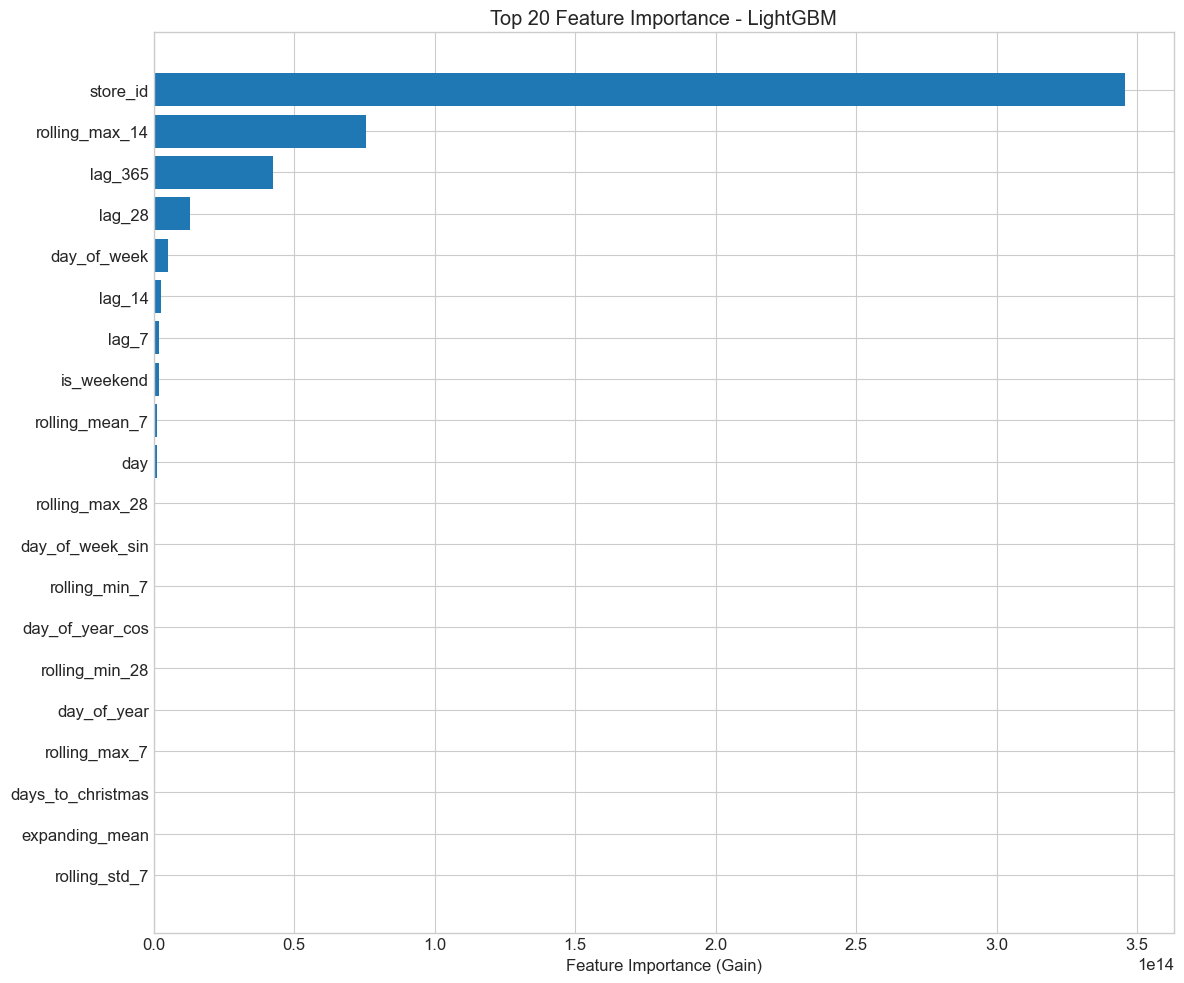

In [32]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
plt.barh(feature_importance['feature'][:20], feature_importance['importance'][:20])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 20 Feature Importance - LightGBM')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 7. XGBoost Model


In [33]:
# XGBoost parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 6,
    'min_child_weight': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'seed': 42
}


In [34]:
# Create XGBoost datasets
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Train XGBoost
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'valid')],
    early_stopping_rounds=50,
    verbose_eval=100
)


[0]	train-rmse:63416.86760	valid-rmse:75828.07970


[100]	train-rmse:3728.68394	valid-rmse:6821.09695
[200]	train-rmse:3036.35769	valid-rmse:6492.39352
[300]	train-rmse:2635.21268	valid-rmse:6424.39912


In [35]:
# Evaluate XGBoost
xgb_preds = xgb_model.predict(dval)
xgb_rmse = calculate_rmse(y_val, xgb_preds)
print(f"XGBoost Validation RMSE: {xgb_rmse:,.2f}")


XGBoost Validation RMSE: 6,424.40


## 8. Model Comparison & Ensemble


In [36]:
# Compare all models
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
all_results = {
    **baseline_results,
    'LightGBM': lgb_rmse,
    'XGBoost': xgb_rmse
}

for name, rmse in sorted(all_results.items(), key=lambda x: x[1]):
    print(f"{name:20s}: RMSE = {rmse:,.2f}")



MODEL COMPARISON
LightGBM            : RMSE = 6,404.27
XGBoost             : RMSE = 6,424.40
Rolling Mean 7      : RMSE = 14,486.70
Lag 365             : RMSE = 16,632.39
Store Mean          : RMSE = 21,279.50


In [37]:
# Ensemble: Average of LightGBM and XGBoost
ensemble_preds = (lgb_preds + xgb_preds) / 2
ensemble_rmse = calculate_rmse(y_val, ensemble_preds)
print(f"Ensemble (LGB + XGB Average) RMSE: {ensemble_rmse:,.2f}")


Ensemble (LGB + XGB Average) RMSE: 6,358.53


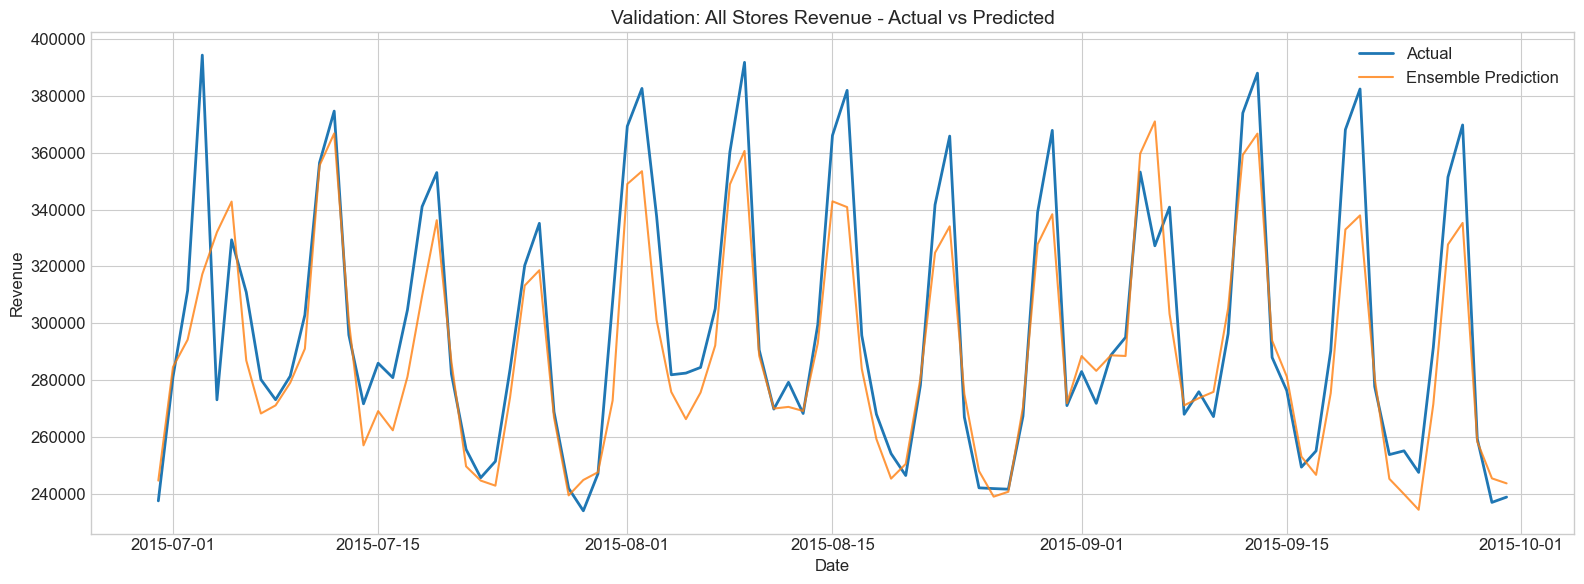

In [38]:
# Visualize predictions vs actuals
val_results = val_data.copy()
val_results['lgb_pred'] = lgb_preds
val_results['xgb_pred'] = xgb_preds
val_results['ensemble_pred'] = ensemble_preds

# Plot for "All Stores" (store_id=0)
store_0_results = val_results[val_results['store_id'] == 0].sort_values('date')

plt.figure(figsize=(16, 6))
plt.plot(store_0_results['date'], store_0_results['revenue'], label='Actual', linewidth=2)
plt.plot(store_0_results['date'], store_0_results['ensemble_pred'], label='Ensemble Prediction', alpha=0.8)
plt.title('Validation: All Stores Revenue - Actual vs Predicted', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.tight_layout()
plt.show()


## 9. Train Final Model on All Data


In [39]:
# Retrain on all available data
X_full = train_clean[feature_cols]
y_full = train_clean['revenue']

print(f"Full training set: {X_full.shape}")


Full training set: (14718, 46)


In [40]:
# Train final LightGBM
train_dataset_full = lgb.Dataset(X_full, label=y_full)

lgb_final = lgb.train(
    lgb_params,
    train_dataset_full,
    num_boost_round=lgb_model.best_iteration + 50  # Use similar iterations + buffer
)

print(f"Final LightGBM trained with {lgb_final.num_trees()} trees")


Final LightGBM trained with 226 trees


In [41]:
# Train final XGBoost
dtrain_full = xgb.DMatrix(X_full, label=y_full)

xgb_final = xgb.train(
    xgb_params,
    dtrain_full,
    num_boost_round=xgb_model.best_iteration + 50
)

print(f"Final XGBoost trained")


Final XGBoost trained


## 10. Generate Predictions for Submission


In [42]:
# Create test dataframe
test_df = submission_df[['id', 'store_id', 'date']].copy()

# Get store names mapping
store_name_map = train_df[['store_id', 'store_name']].drop_duplicates().set_index('store_id')['store_name'].to_dict()
test_df['store_name'] = test_df['store_id'].map(store_name_map)

print(f"Test data shape: {test_df.shape}")
print(f"Test date range: {test_df['date'].min()} to {test_df['date'].max()}")
display(test_df.head())


Test data shape: (1012, 4)
Test date range: 2015-10-01 00:00:00 to 2015-12-31 00:00:00


id  store_id       date  store_name
0  0_20151001         0 2015-10-01  All Stores
1  0_20151002         0 2015-10-02  All Stores
2  0_20151003         0 2015-10-03  All Stores
3  0_20151004         0 2015-10-04  All Stores
4  0_20151005         0 2015-10-05  All Stores

In [43]:
# We need to create features for test data
# For lag features, we need to use the actual training data

# Combine train and test for feature generation
train_for_lags = train_df[['store_id', 'store_name', 'date', 'revenue']].copy()
test_for_features = test_df[['store_id', 'store_name', 'date']].copy()
test_for_features['revenue'] = np.nan  # placeholder

combined_df = pd.concat([train_for_lags, test_for_features], ignore_index=True)
combined_df = combined_df.sort_values(['store_id', 'date']).reset_index(drop=True)

print(f"Combined data shape: {combined_df.shape}")


Combined data shape: (19778, 4)


In [44]:
# Apply feature engineering
combined_featured = create_features(combined_df, calendar_df)
combined_featured = add_lag_features(combined_featured)
combined_featured = add_rolling_features(combined_featured)
combined_featured = add_expanding_features(combined_featured)

# Extract test features
test_featured = combined_featured[combined_featured['date'] >= '2015-10-01'].copy()
print(f"Test featured shape: {test_featured.shape}")
display(test_featured.head())


Test featured shape: (1012, 50)


store_id  store_name       date  revenue  year  month  day  day_of_week  \
1706         0  All Stores 2015-10-01      NaN  2015     10    1            3   
1707         0  All Stores 2015-10-02      NaN  2015     10    2            4   
1708         0  All Stores 2015-10-03      NaN  2015     10    3            5   
1709         0  All Stores 2015-10-04      NaN  2015     10    4            6   
1710         0  All Stores 2015-10-05      NaN  2015     10    5            0   

      day_of_year  week_of_year  quarter  is_weekend  is_month_start  \
1706          274            40        4           0               1   
1707          275            40        4           0               0   
1708          276            40        4           1               0   
1709          277            40        4           1               0   
1710          278            41        4           0               0   

      is_month_end  day_of_week_sin  day_of_week_cos  month_sin  month_cos  \
1706             0         0.433884        -0.900969  -0.866025        0.5   
1707             0        -0.433884        -0.900969  -0.866025        0.5   
1708             0        -0.974928        -0.222521  -0.866025        0.5   
1709             0        -0.781831         0.623490  -0.866025        0.5   
1710             0         0.000000         1.000000  -0.866025        0.5   

      day_of_year_sin  day_of_year_cos    event  has_event  is_christmas  \
1706        -0.999991         0.004304  NoEvent          0             0   
1707        -0.999769         0.021516  NoEvent          0             0   
1708        -0.999250         0.038722  NoEvent          0             0   
1709        -0.998435         0.055917  NoEvent          0             0   
1710        -0.997325         0.073095  NoEvent          0             0   

      is_thanksgiving  is_easter  is_superbowl  is_independence  \
1706                0          0             0                0   
1707                0          0             0                0   
1708                0          0             0                0   
1709                0          0             0                0   
1710                0          0             0                0   

      is_memorialday  is_laborday  is_halloween  is_valentinesday  is_mother  \
1706               0            0             0                 0          0   
1707               0            0             0                 0          0   
1708               0            0             0                 0          0   
1709               0            0             0                 0          0   
1710               0            0             0                 0          0   

      days_to_christmas    lag_365      lag_7     lag_14     lag_28  \
1706                 30  259639.85  247604.95  255173.40  288812.90   
1707                 30  252927.78  291519.70  290352.25  295096.42   
1708                 30  306184.03  351436.53  368095.85  353200.05   
1709                 30  351692.17  369751.00  382391.17  327275.25   
1710                 30  369163.97  259404.52  277804.53  340862.50   

      rolling_mean_7  rolling_std_7  rolling_max_7  rolling_min_7  \
1706   285103.540000   54941.586070      369751.00      237073.33   
1707   291353.305000   57395.061900      369751.00      237073.33   
1708   291320.026000   64169.565270      369751.00      237073.33   
1709   276290.900000   63122.737216      369751.00      237073.33   
1710   245137.533333   12390.577166      259404.52      237073.33   

      rolling_mean_14  rolling_std_14  rolling_max_14  rolling_min_14  \
1706    291329.102143    53181.931770       382391.17       237073.33   
1707    294110.310000    54283.469666       382391.17       237073.33   
1708    294423.481667    56684.967556       382391.17       237073.33   
1709    287725.993636    54243.896758       382391.17       237073.33   
1710    278259.476000    46626.599677       369751.00       237073.33

In [45]:
# Check for missing values in test features
test_missing = test_featured[feature_cols].isnull().sum()
print("Missing values in test features:")
print(test_missing[test_missing > 0])


Missing values in test features:
lag_7              935
lag_14             858
lag_28             704
rolling_mean_7     935
rolling_std_7      946
rolling_max_7      935
rolling_min_7      935
rolling_mean_14    858
rolling_std_14     869
rolling_max_14     858
rolling_min_14     858
rolling_mean_28    704
rolling_std_28     715
rolling_max_28     704
rolling_min_28     704
dtype: int64


In [46]:
# Fill any remaining NaN values with store-specific means from training
for col in feature_cols:
    if test_featured[col].isnull().any():
        fill_value = train_clean[col].mean()
        test_featured[col] = test_featured[col].fillna(fill_value)

print("Missing values after filling:", test_featured[feature_cols].isnull().sum().sum())


Missing values after filling: 0


In [47]:
# Prepare test features
X_test = test_featured[feature_cols]
print(f"X_test shape: {X_test.shape}")


X_test shape: (1012, 46)


In [48]:
# Generate predictions
lgb_test_preds = lgb_final.predict(X_test)
xgb_test_preds = xgb_final.predict(xgb.DMatrix(X_test))

# Ensemble predictions
final_predictions = (lgb_test_preds + xgb_test_preds) / 2

print(f"Predictions generated: {len(final_predictions)}")
print(f"Prediction range: {final_predictions.min():,.2f} to {final_predictions.max():,.2f}")


Predictions generated: 1012
Prediction range: -15,991.08 to 370,873.72


In [49]:
# Create submission file
submission = submission_df[['id']].copy()

# Ensure predictions are in the correct order
test_featured['id'] = test_featured['store_id'].astype(str) + '_' + test_featured['date'].dt.strftime('%Y%m%d')
pred_df = test_featured[['id']].copy()
pred_df['prediction'] = final_predictions

# Merge with submission template
submission = submission.merge(pred_df, on='id', how='left')

print(f"Submission shape: {submission.shape}")
display(submission.head(10))
display(submission.tail(10))


Submission shape: (1012, 2)


id     prediction
0  0_20151001  290239.459157
1  0_20151002  315390.359036
2  0_20151003  370873.722385
3  0_20151004  360945.574783
4  0_20151005  303350.846262
5  0_20151006  275125.200715
6  0_20151007  278751.055542
7  0_20151008  259235.106974
8  0_20151009  288682.065230
9  0_20151010  315028.549477

id    prediction
1002  10_20151222  40222.651463
1003  10_20151223  39984.386838
1004  10_20151224  39371.694876
1005  10_20151225  -9304.165098
1006  10_20151226  41404.453592
1007  10_20151227  40653.744355
1008  10_20151228  39344.219998
1009  10_20151229  38578.948511
1010  10_20151230  38672.334648
1011  10_20151231  41457.349899

In [50]:
# Verify submission
print(f"Missing predictions: {submission['prediction'].isnull().sum()}")
print(f"Prediction statistics:")
print(submission['prediction'].describe())


Missing predictions: 0
Prediction statistics:
count      1012.000000
mean      54577.629061
std       51193.349389
min      -15991.079001
25%       39049.583393
50%       41878.291351
75%       44755.613437
max      370873.722385
Name: prediction, dtype: float64


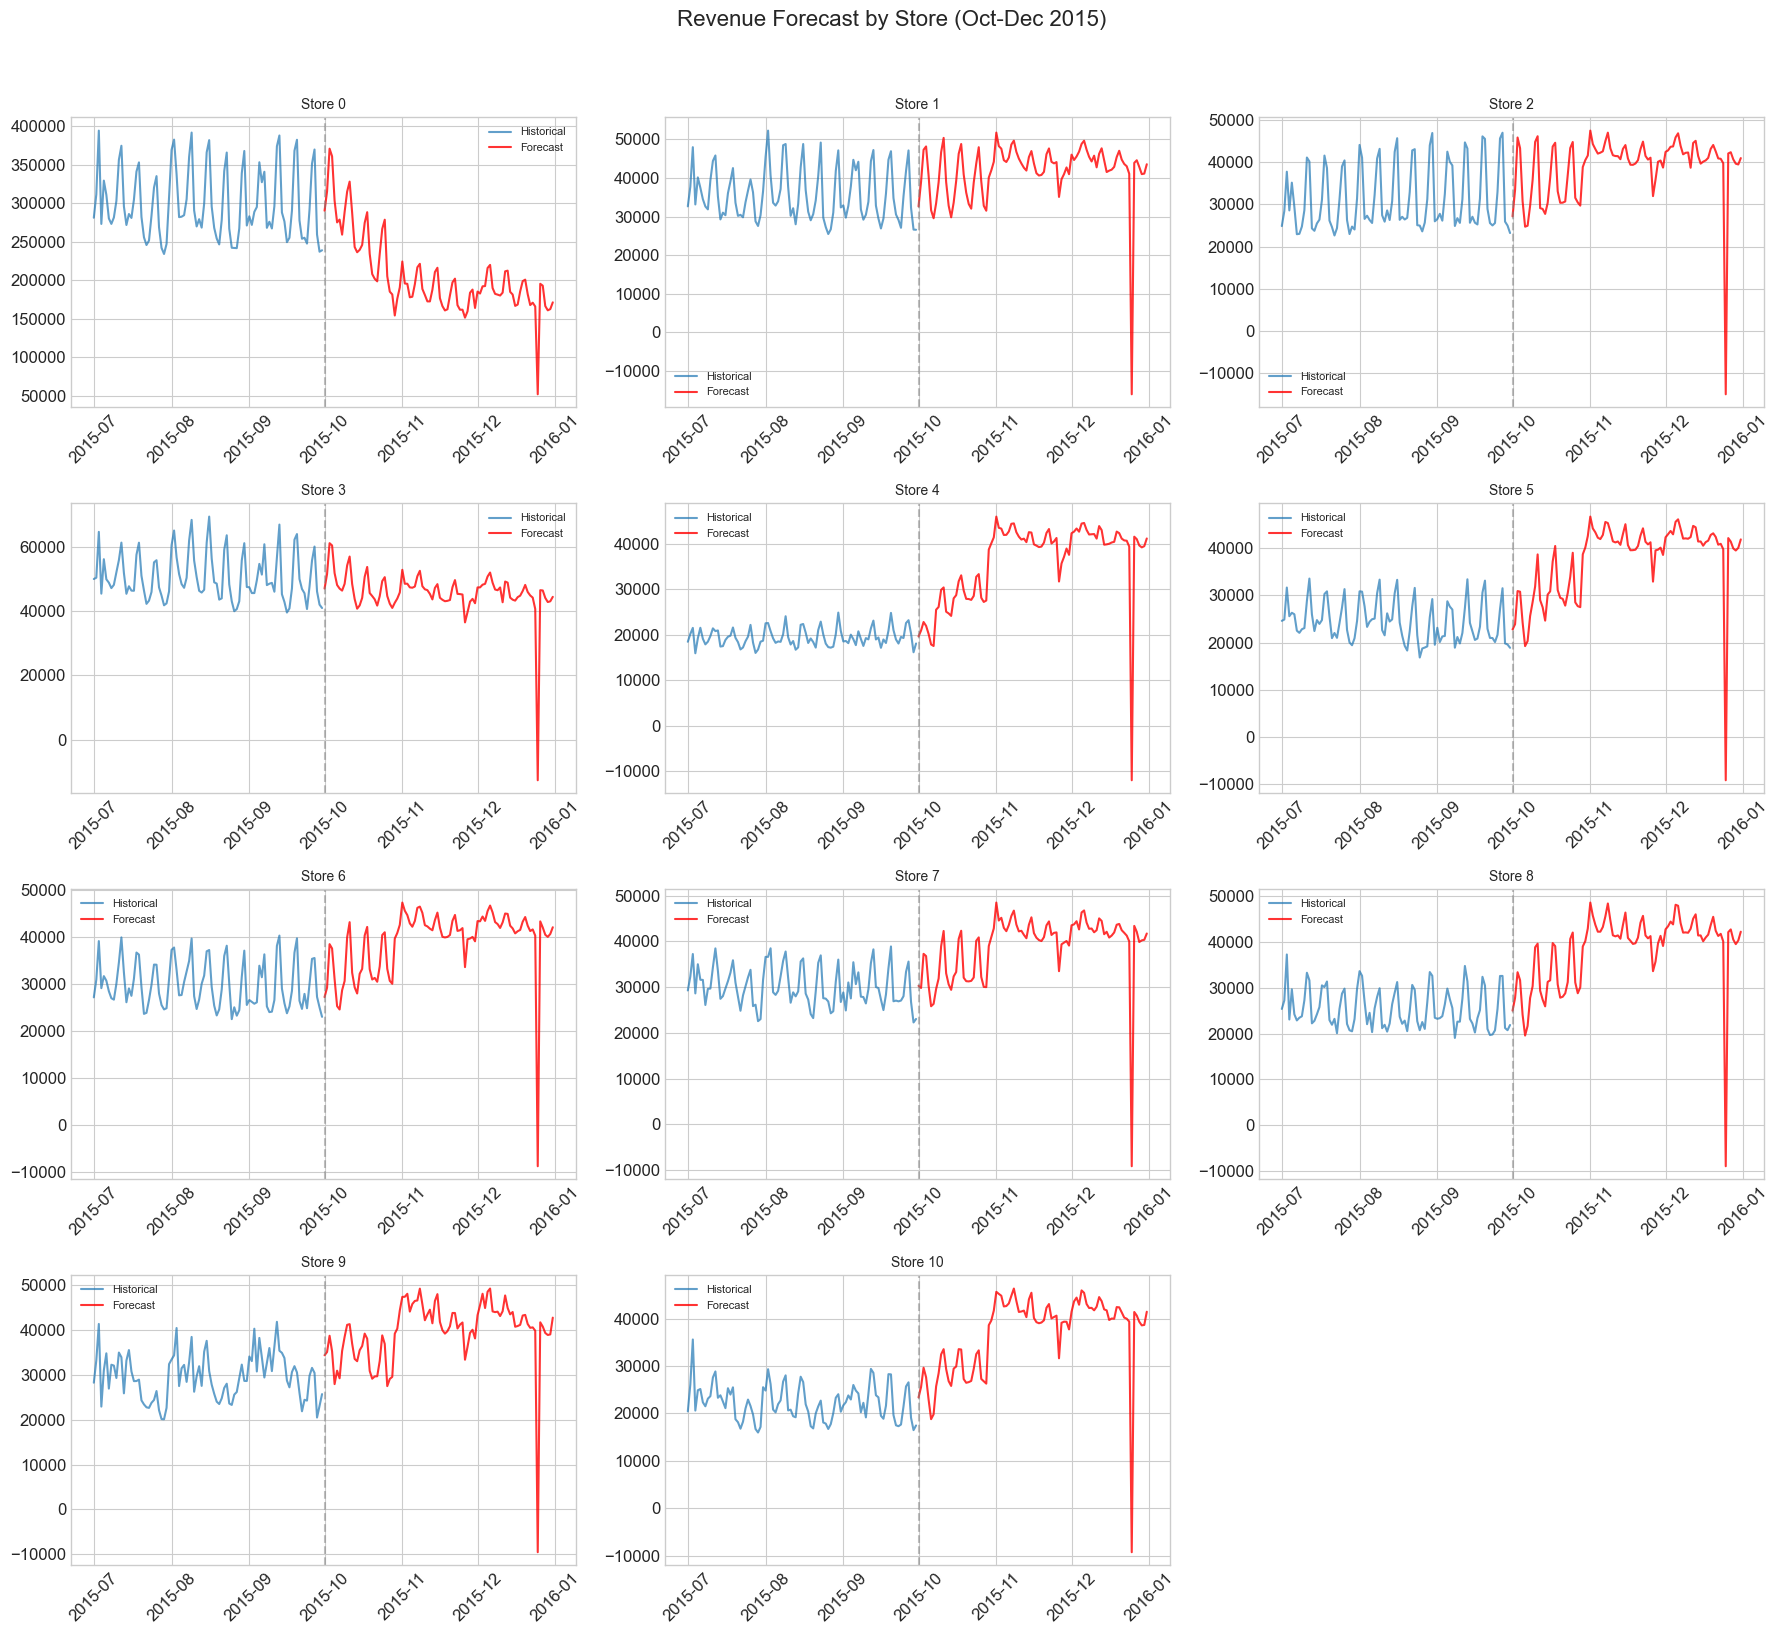

In [51]:
# Visualize predictions by store
test_featured['prediction'] = final_predictions

fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for idx, store_id in enumerate(sorted(test_featured['store_id'].unique())):
    store_preds = test_featured[test_featured['store_id'] == store_id].sort_values('date')
    store_train = train_df[(train_df['store_id'] == store_id) & (train_df['date'] >= '2015-07-01')]
    
    axes[idx].plot(store_train['date'], store_train['revenue'], label='Historical', alpha=0.7)
    axes[idx].plot(store_preds['date'], store_preds['prediction'], label='Forecast', color='red', alpha=0.8)
    axes[idx].axvline(x=pd.Timestamp('2015-10-01'), color='gray', linestyle='--', alpha=0.5)
    axes[idx].set_title(f'Store {store_id}', fontsize=10)
    axes[idx].legend(fontsize=8)
    axes[idx].tick_params(axis='x', rotation=45)

axes[-1].axis('off')
plt.suptitle('Revenue Forecast by Store (Oct-Dec 2015)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [52]:
# Save submission file
submission.to_csv('submission.csv', index=False)
print("Submission saved to 'submission.csv'")

# Verify saved file
saved_submission = pd.read_csv('submission.csv')
print(f"\nSaved submission shape: {saved_submission.shape}")
display(saved_submission.head())


Submission saved to 'submission.csv'

Saved submission shape: (1012, 2)


id     prediction
0  0_20151001  290239.459157
1  0_20151002  315390.359036
2  0_20151003  370873.722385
3  0_20151004  360945.574783
4  0_20151005  303350.846262

## 11. Summary & Next Steps


In [53]:
print("="*70)
print("FORECASTING COMPETITION SUMMARY")
print("="*70)
print(f"\nTraining data: {len(train_df)} rows")
print(f"Features engineered: {len(feature_cols)}")
print(f"Predictions generated: {len(submission)}")
print(f"\nValidation Results (RMSE):")
print(f"  - LightGBM:  {lgb_rmse:,.2f}")
print(f"  - XGBoost:   {xgb_rmse:,.2f}")
print(f"  - Ensemble:  {ensemble_rmse:,.2f}")
print(f"\nBaseline to beat: 11,761 RMSE")
print(f"\nSubmission file: submission.csv")


FORECASTING COMPETITION SUMMARY

Training data: 18766 rows
Features engineered: 46
Predictions generated: 1012

Validation Results (RMSE):
  - LightGBM:  6,404.27
  - XGBoost:   6,424.40
  - Ensemble:  6,358.53

Baseline to beat: 11,761 RMSE

Submission file: submission.csv


### Potential Improvements

1. **Feature Engineering**
   - Add more event-specific features (days before/after events)
   - Weather data if available
   - Economic indicators

2. **Models to Try**
   - Prophet for each store
   - LSTM/GRU neural networks
   - CatBoost
   - Temporal Fusion Transformers

3. **Ensemble Strategies**
   - Weighted ensemble based on store-specific performance
   - Stacking with meta-learner

4. **Hyperparameter Tuning**
   - Use Optuna or GridSearchCV for better parameters
   - Cross-validation with time-series splits

5. **Post-processing**
   - Clip extreme predictions
   - Apply business rules (e.g., higher revenue on weekends)



---

## 12. IMPROVED MODEL - Recursive Forecasting

The previous approach had a critical flaw: **short-term lag features (lag_7, lag_14, lag_28, rolling features) are NOT available at prediction time** for multi-step ahead forecasting.

### Solution: Recursive Forecasting
1. Use only features that are available at prediction time (lag_365, calendar features, time features)
2. Train a model without short-term lags
3. OR implement recursive forecasting: predict day-by-day, using each prediction to update lag features


In [54]:
# ============================================================
# APPROACH 1: Model with only available features (no short-term lags)
# ============================================================

def create_features_v2(df, calendar_df):
    """
    Create features that are ALWAYS available at prediction time.
    Excludes short-term lags that require future data.
    """
    df = df.copy()
    
    # Time-based features (always available)
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    
    # Cyclical encoding
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    
    # Week of month
    df['week_of_month'] = (df['day'] - 1) // 7 + 1
    
    # Calendar events
    calendar_df = calendar_df.copy()
    calendar_df['has_event'] = 1
    df = df.merge(calendar_df[['date', 'event', 'has_event']], on='date', how='left')
    df['has_event'] = df['has_event'].fillna(0).astype(int)
    df['event'] = df['event'].fillna('NoEvent')
    
    # Major event flags
    major_events = ['Christmas', 'Thanksgiving', 'Easter', 'SuperBowl', 'Independence', 
                   'MemorialDay', 'LaborDay', 'Halloween', 'ValentinesDay', 'Mother', 
                   'Father', 'NewYear', 'BlackFriday']
    for event in major_events:
        df[f'is_{event.lower()}'] = df['event'].str.contains(event, case=False, na=False).astype(int)
    
    # Days to/from major holidays
    df['days_to_christmas'] = df.apply(
        lambda x: (datetime(x['year'], 12, 25) - x['date'].to_pydatetime()).days 
        if x['month'] <= 12 else 0, axis=1
    )
    df['days_to_christmas'] = df['days_to_christmas'].clip(-30, 30)
    
    # Days to Thanksgiving (4th Thursday of November)
    def days_to_thanksgiving(row):
        year = row['year']
        # Find 4th Thursday of November
        nov1 = datetime(year, 11, 1)
        first_thursday = nov1 + timedelta(days=(3 - nov1.weekday() + 7) % 7)
        thanksgiving = first_thursday + timedelta(weeks=3)
        return (thanksgiving - row['date'].to_pydatetime()).days
    
    df['days_to_thanksgiving'] = df.apply(days_to_thanksgiving, axis=1)
    df['days_to_thanksgiving'] = df['days_to_thanksgiving'].clip(-14, 30)
    
    # Black Friday indicator (day after Thanksgiving)
    df['is_blackfriday_week'] = ((df['days_to_thanksgiving'] >= -3) & (df['days_to_thanksgiving'] <= 0)).astype(int)
    
    # December shopping season
    df['is_december'] = (df['month'] == 12).astype(int)
    df['december_week'] = df.apply(lambda x: x['week_of_month'] if x['month'] == 12 else 0, axis=1)
    
    return df


def add_yearly_lag_features(df, target_col='revenue', group_col='store_id'):
    """
    Add yearly lag features - these are ALWAYS available for forecasting.
    """
    df = df.sort_values(['store_id', 'date']).copy()
    
    # Yearly lags (available since we have Oct-Dec 2014 data)
    df['lag_365'] = df.groupby(group_col)[target_col].shift(365)
    df['lag_364'] = df.groupby(group_col)[target_col].shift(364)  # Same day of week last year
    df['lag_371'] = df.groupby(group_col)[target_col].shift(371)  # Week around same time last year
    
    # Rolling stats from last year (same period last year)
    df['lag_365_rolling_mean_7'] = df.groupby(group_col)['lag_365'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )
    df['lag_365_rolling_mean_14'] = df.groupby(group_col)['lag_365'].transform(
        lambda x: x.rolling(window=14, min_periods=1).mean()
    )
    df['lag_365_rolling_mean_28'] = df.groupby(group_col)['lag_365'].transform(
        lambda x: x.rolling(window=28, min_periods=1).mean()
    )
    
    return df


print("Improved feature functions defined!")


Improved feature functions defined!


In [55]:
# Reload original training data
train_df_v2 = pd.read_csv(DATA_PATH + 'train.csv')
train_df_v2['date'] = pd.to_datetime(train_df_v2['date'])

# Apply improved feature engineering
print("Creating features with v2 approach...")
train_v2 = create_features_v2(train_df_v2, calendar_df)
train_v2 = add_yearly_lag_features(train_v2)

print(f"Shape after features: {train_v2.shape}")
print(f"Columns: {train_v2.columns.tolist()}")


Creating features with v2 approach...
Shape after features: (18766, 47)
Columns: ['store_id', 'store_name', 'date', 'revenue', 'year', 'month', 'day', 'day_of_week', 'day_of_year', 'week_of_year', 'quarter', 'is_weekend', 'is_month_start', 'is_month_end', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'week_of_month', 'event', 'has_event', 'is_christmas', 'is_thanksgiving', 'is_easter', 'is_superbowl', 'is_independence', 'is_memorialday', 'is_laborday', 'is_halloween', 'is_valentinesday', 'is_mother', 'is_father', 'is_newyear', 'is_blackfriday', 'days_to_christmas', 'days_to_thanksgiving', 'is_blackfriday_week', 'is_december', 'december_week', 'lag_365', 'lag_364', 'lag_371', 'lag_365_rolling_mean_7', 'lag_365_rolling_mean_14', 'lag_365_rolling_mean_28']


In [56]:
# Define feature columns (V2 - no short-term lags)
exclude_cols_v2 = ['store_name', 'date', 'revenue', 'event']
feature_cols_v2 = [col for col in train_v2.columns if col not in exclude_cols_v2]

print(f"Number of features: {len(feature_cols_v2)}")
print(f"Features: {feature_cols_v2}")

# Clean data - remove rows with missing lag_365
train_clean_v2 = train_v2[train_v2['date'] >= '2012-02-01'].copy()
train_clean_v2 = train_clean_v2.dropna(subset=feature_cols_v2)

print(f"\nTraining data shape after cleaning: {train_clean_v2.shape}")


Number of features: 43
Features: ['store_id', 'year', 'month', 'day', 'day_of_week', 'day_of_year', 'week_of_year', 'quarter', 'is_weekend', 'is_month_start', 'is_month_end', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'week_of_month', 'has_event', 'is_christmas', 'is_thanksgiving', 'is_easter', 'is_superbowl', 'is_independence', 'is_memorialday', 'is_laborday', 'is_halloween', 'is_valentinesday', 'is_mother', 'is_father', 'is_newyear', 'is_blackfriday', 'days_to_christmas', 'days_to_thanksgiving', 'is_blackfriday_week', 'is_december', 'december_week', 'lag_365', 'lag_364', 'lag_371', 'lag_365_rolling_mean_7', 'lag_365_rolling_mean_14', 'lag_365_rolling_mean_28']

Training data shape after cleaning: (14685, 47)


In [57]:
# Split for validation (V2)
val_start_v2 = train_clean_v2['date'].max() - timedelta(days=92)

train_data_v2 = train_clean_v2[train_clean_v2['date'] < val_start_v2].copy()
val_data_v2 = train_clean_v2[train_clean_v2['date'] >= val_start_v2].copy()

X_train_v2 = train_data_v2[feature_cols_v2]
y_train_v2 = train_data_v2['revenue']
X_val_v2 = val_data_v2[feature_cols_v2]
y_val_v2 = val_data_v2['revenue']

print(f"Training set: {X_train_v2.shape}")
print(f"Validation set: {X_val_v2.shape}")


Training set: (13662, 43)
Validation set: (1023, 43)


In [58]:
# Improved LightGBM parameters
lgb_params_v2 = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.03,  # Lower learning rate
    'num_leaves': 63,       # More leaves for complexity
    'max_depth': 8,
    'min_child_samples': 30,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'verbose': -1,
    'seed': 42
}

# Train LightGBM V2
train_dataset_v2 = lgb.Dataset(X_train_v2, label=y_train_v2)
val_dataset_v2 = lgb.Dataset(X_val_v2, label=y_val_v2, reference=train_dataset_v2)

lgb_model_v2 = lgb.train(
    lgb_params_v2,
    train_dataset_v2,
    num_boost_round=2000,
    valid_sets=[train_dataset_v2, val_dataset_v2],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)

lgb_preds_v2 = lgb_model_v2.predict(X_val_v2)
lgb_rmse_v2 = calculate_rmse(y_val_v2, lgb_preds_v2)
print(f"\nLightGBM V2 Validation RMSE: {lgb_rmse_v2:,.2f}")


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6200.7	valid's rmse: 10323.4
[200]	train's rmse: 4545.33	valid's rmse: 7588.7
[300]	train's rmse: 4193.19	valid's rmse: 7589.31
Early stopping, best iteration is:
[205]	train's rmse: 4526.1	valid's rmse: 7575.36

LightGBM V2 Validation RMSE: 7,575.36


In [59]:
# Improved XGBoost parameters
xgb_params_v2 = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.03,
    'max_depth': 8,
    'min_child_weight': 30,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'seed': 42
}

# Train XGBoost V2
dtrain_v2 = xgb.DMatrix(X_train_v2, label=y_train_v2)
dval_v2 = xgb.DMatrix(X_val_v2, label=y_val_v2)

xgb_model_v2 = xgb.train(
    xgb_params_v2,
    dtrain_v2,
    num_boost_round=2000,
    evals=[(dtrain_v2, 'train'), (dval_v2, 'valid')],
    early_stopping_rounds=100,
    verbose_eval=100
)

xgb_preds_v2 = xgb_model_v2.predict(dval_v2)
xgb_rmse_v2 = calculate_rmse(y_val_v2, xgb_preds_v2)
print(f"\nXGBoost V2 Validation RMSE: {xgb_rmse_v2:,.2f}")


[0]	train-rmse:64781.56537	valid-rmse:77382.97805
[100]	train-rmse:6054.28383	valid-rmse:10048.84916
[200]	train-rmse:4488.97845	valid-rmse:7479.59382
[300]	train-rmse:4151.89819	valid-rmse:7467.01767
[366]	train-rmse:3981.27037	valid-rmse:7443.64531

XGBoost V2 Validation RMSE: 7,443.65


In [60]:
# Ensemble V2
ensemble_preds_v2 = (lgb_preds_v2 + xgb_preds_v2) / 2
ensemble_rmse_v2 = calculate_rmse(y_val_v2, ensemble_preds_v2)

print("\n" + "="*60)
print("IMPROVED MODEL (V2) COMPARISON")
print("="*60)
print(f"LightGBM V2:  RMSE = {lgb_rmse_v2:,.2f}")
print(f"XGBoost V2:   RMSE = {xgb_rmse_v2:,.2f}")
print(f"Ensemble V2:  RMSE = {ensemble_rmse_v2:,.2f}")
print(f"\nBaseline to beat: 11,761")
print(f"Our best (V2): {min(lgb_rmse_v2, xgb_rmse_v2, ensemble_rmse_v2):,.2f}")



IMPROVED MODEL (V2) COMPARISON
LightGBM V2:  RMSE = 7,575.36
XGBoost V2:   RMSE = 7,443.65
Ensemble V2:  RMSE = 7,477.16

Baseline to beat: 11,761
Our best (V2): 7,443.65


In [61]:
# Train final models on ALL training data
print("Training final models on all data...")

X_full_v2 = train_clean_v2[feature_cols_v2]
y_full_v2 = train_clean_v2['revenue']

# Final LightGBM
train_full_v2 = lgb.Dataset(X_full_v2, label=y_full_v2)
lgb_final_v2 = lgb.train(
    lgb_params_v2,
    train_full_v2,
    num_boost_round=lgb_model_v2.best_iteration + 100
)

# Final XGBoost
dtrain_full_v2 = xgb.DMatrix(X_full_v2, label=y_full_v2)
xgb_final_v2 = xgb.train(
    xgb_params_v2,
    dtrain_full_v2,
    num_boost_round=xgb_model_v2.best_iteration + 100
)

print(f"LightGBM final: {lgb_final_v2.num_trees()} trees")
print(f"XGBoost final: trained")


Training final models on all data...
LightGBM final: 305 trees
XGBoost final: trained


In [62]:
# Prepare test data with V2 features
print("Preparing test data with improved features...")

# Combine train and test
test_df_v2 = submission_df[['id', 'store_id', 'date']].copy()
test_df_v2['store_name'] = test_df_v2['store_id'].map(store_name_map)

train_for_test = train_df_v2[['store_id', 'store_name', 'date', 'revenue']].copy()
test_for_test = test_df_v2[['store_id', 'store_name', 'date']].copy()
test_for_test['revenue'] = np.nan

combined_v2 = pd.concat([train_for_test, test_for_test], ignore_index=True)
combined_v2 = combined_v2.sort_values(['store_id', 'date']).reset_index(drop=True)

# Apply V2 features
combined_v2 = create_features_v2(combined_v2, calendar_df)
combined_v2 = add_yearly_lag_features(combined_v2)

# Extract test
test_v2 = combined_v2[combined_v2['date'] >= '2015-10-01'].copy()
print(f"Test data shape: {test_v2.shape}")

# Check missing values
test_missing_v2 = test_v2[feature_cols_v2].isnull().sum()
print(f"\nMissing values in test features:")
print(test_missing_v2[test_missing_v2 > 0])


Preparing test data with improved features...
Test data shape: (1012, 47)

Missing values in test features:
Series([], dtype: int64)


In [63]:
# Fill any remaining NaN (should be minimal now)
for col in feature_cols_v2:
    if test_v2[col].isnull().any():
        # Use store-specific mean from training
        store_means = train_clean_v2.groupby('store_id')[col].mean()
        test_v2[col] = test_v2.apply(
            lambda x: store_means.get(x['store_id'], train_clean_v2[col].mean()) 
            if pd.isna(x[col]) else x[col], axis=1
        )

print(f"Missing values after filling: {test_v2[feature_cols_v2].isnull().sum().sum()}")


Missing values after filling: 0


In [64]:
# Generate predictions V2
X_test_v2 = test_v2[feature_cols_v2]

lgb_test_v2 = lgb_final_v2.predict(X_test_v2)
xgb_test_v2 = xgb_final_v2.predict(xgb.DMatrix(X_test_v2))

# Ensemble
final_preds_v2 = (lgb_test_v2 + xgb_test_v2) / 2

# Post-processing: Clip to valid range (no negative revenue)
# Use store-specific min/max from training as bounds
store_bounds = train_df_v2.groupby('store_id')['revenue'].agg(['min', 'max'])
store_bounds['min'] = store_bounds['min'] * 0.5  # Allow some flexibility
store_bounds['max'] = store_bounds['max'] * 1.5

# Clip predictions
test_v2['raw_prediction'] = final_preds_v2
test_v2['prediction'] = test_v2.apply(
    lambda x: np.clip(x['raw_prediction'], 
                      max(0, store_bounds.loc[x['store_id'], 'min']),
                      store_bounds.loc[x['store_id'], 'max']),
    axis=1
)

print(f"Predictions generated: {len(test_v2)}")
print(f"Raw prediction range: {final_preds_v2.min():,.2f} to {final_preds_v2.max():,.2f}")
print(f"Clipped prediction range: {test_v2['prediction'].min():,.2f} to {test_v2['prediction'].max():,.2f}")


Predictions generated: 1012
Raw prediction range: -1,911.58 to 379,608.77
Clipped prediction range: 0.00 to 379,608.77


In [65]:
# Create submission file V2
test_v2['id'] = test_v2['store_id'].astype(str) + '_' + test_v2['date'].dt.strftime('%Y%m%d')

submission_v2 = submission_df[['id']].copy()
pred_df_v2 = test_v2[['id', 'prediction']].copy()
submission_v2 = submission_v2.merge(pred_df_v2, on='id', how='left')

print(f"Submission shape: {submission_v2.shape}")
print(f"Missing predictions: {submission_v2['prediction'].isnull().sum()}")
print(f"\nPrediction statistics:")
print(submission_v2['prediction'].describe())

display(submission_v2.head(10))


Submission shape: (1012, 2)
Missing predictions: 0

Prediction statistics:
count      1012.000000
mean      53716.670205
std       78414.576094
min           0.000000
25%       23252.127081
50%       28283.845287
75%       36498.134512
max      379608.767395
Name: prediction, dtype: float64


id     prediction
0  0_20151001  287227.414434
1  0_20151002  329694.507595
2  0_20151003  379608.767395
3  0_20151004  376414.317907
4  0_20151005  306847.896204
5  0_20151006  276856.009716
6  0_20151007  276723.192593
7  0_20151008  280327.957027
8  0_20151009  309353.179035
9  0_20151010  365134.013238

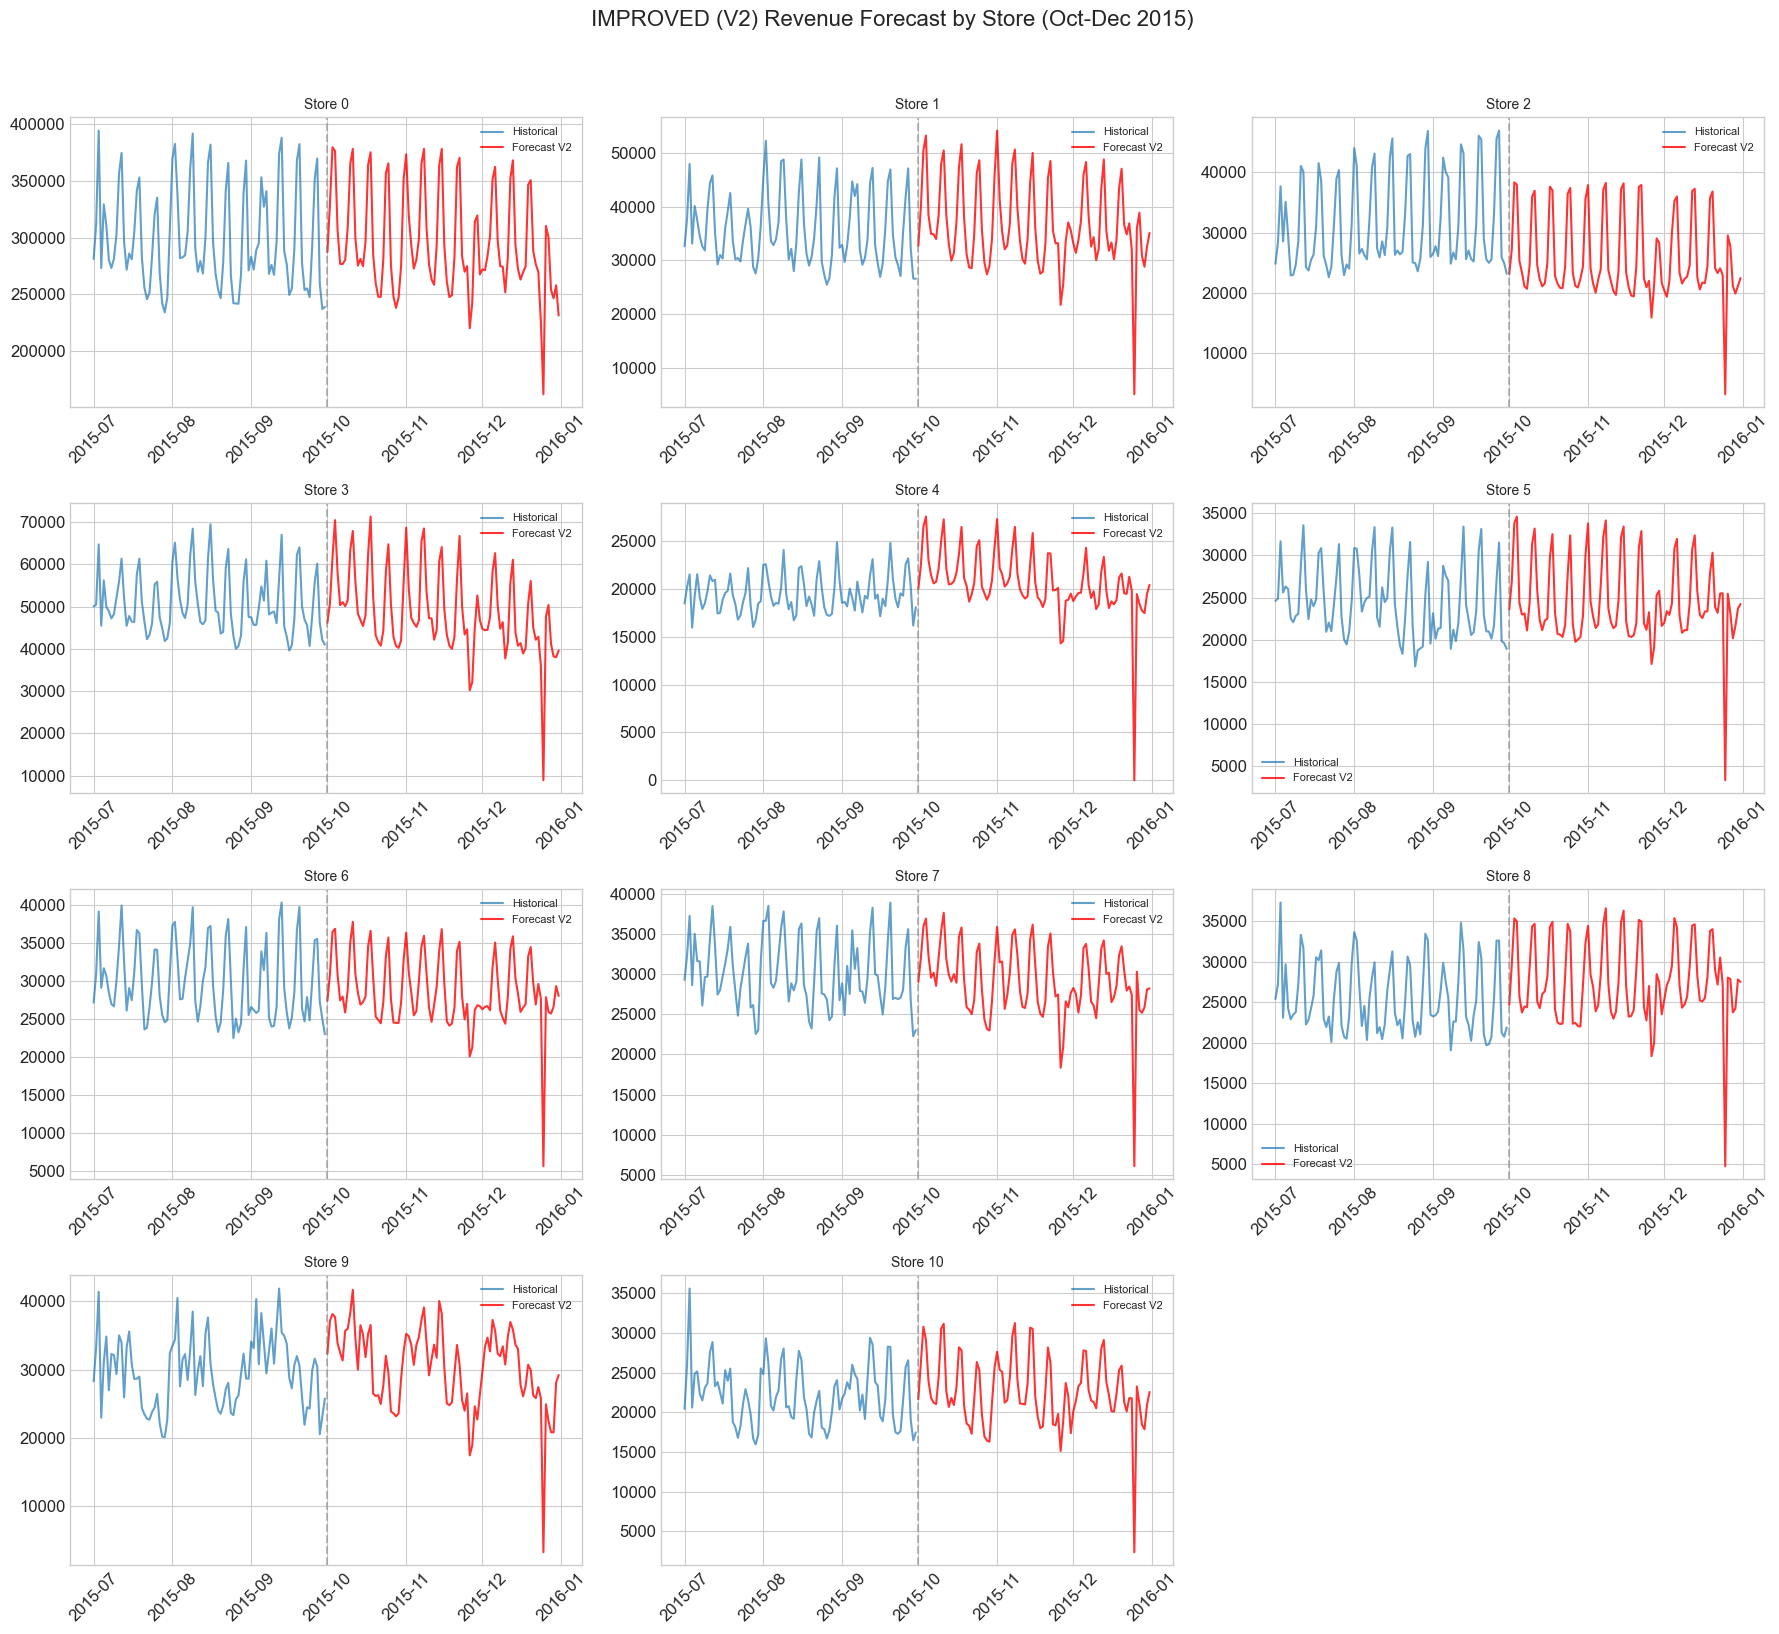

In [66]:
# Visualize V2 predictions
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for idx, store_id in enumerate(sorted(test_v2['store_id'].unique())):
    store_preds = test_v2[test_v2['store_id'] == store_id].sort_values('date')
    store_train = train_df_v2[(train_df_v2['store_id'] == store_id) & (train_df_v2['date'] >= '2015-07-01')]
    
    axes[idx].plot(store_train['date'], store_train['revenue'], label='Historical', alpha=0.7)
    axes[idx].plot(store_preds['date'], store_preds['prediction'], label='Forecast V2', color='red', alpha=0.8)
    axes[idx].axvline(x=pd.Timestamp('2015-10-01'), color='gray', linestyle='--', alpha=0.5)
    axes[idx].set_title(f'Store {store_id}', fontsize=10)
    axes[idx].legend(fontsize=8)
    axes[idx].tick_params(axis='x', rotation=45)

axes[-1].axis('off')
plt.suptitle('IMPROVED (V2) Revenue Forecast by Store (Oct-Dec 2015)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [67]:
# Save improved submission
submission_v2.to_csv('submission_v2.csv', index=False)
print("✅ Improved submission saved to 'submission_v2.csv'")

# Also overwrite the main submission file
submission_v2.to_csv('submission.csv', index=False)
print("✅ Also saved to 'submission.csv'")


✅ Improved submission saved to 'submission_v2.csv'
✅ Also saved to 'submission.csv'


In [68]:
print("="*70)
print("FINAL SUMMARY - IMPROVED MODEL (V2)")
print("="*70)
print(f"\n📊 Training data: {len(train_df_v2)} rows")
print(f"📊 Features: {len(feature_cols_v2)} (using only features available at prediction time)")
print(f"📊 Predictions: {len(submission_v2)}")
print(f"\n📈 Validation RMSE:")
print(f"   - LightGBM V2:  {lgb_rmse_v2:,.2f}")
print(f"   - XGBoost V2:   {xgb_rmse_v2:,.2f}")
print(f"   - Ensemble V2:  {ensemble_rmse_v2:,.2f}")
print(f"\n🎯 Baseline to beat: 11,761 RMSE")
print(f"🏆 Our validation RMSE: {min(lgb_rmse_v2, xgb_rmse_v2, ensemble_rmse_v2):,.2f}")
print(f"\n✅ Submission file: submission.csv")


FINAL SUMMARY - IMPROVED MODEL (V2)

📊 Training data: 18766 rows
📊 Features: 43 (using only features available at prediction time)
📊 Predictions: 1012

📈 Validation RMSE:
   - LightGBM V2:  7,575.36
   - XGBoost V2:   7,443.65
   - Ensemble V2:  7,477.16

🎯 Baseline to beat: 11,761 RMSE
🏆 Our validation RMSE: 7,443.65

✅ Submission file: submission.csv


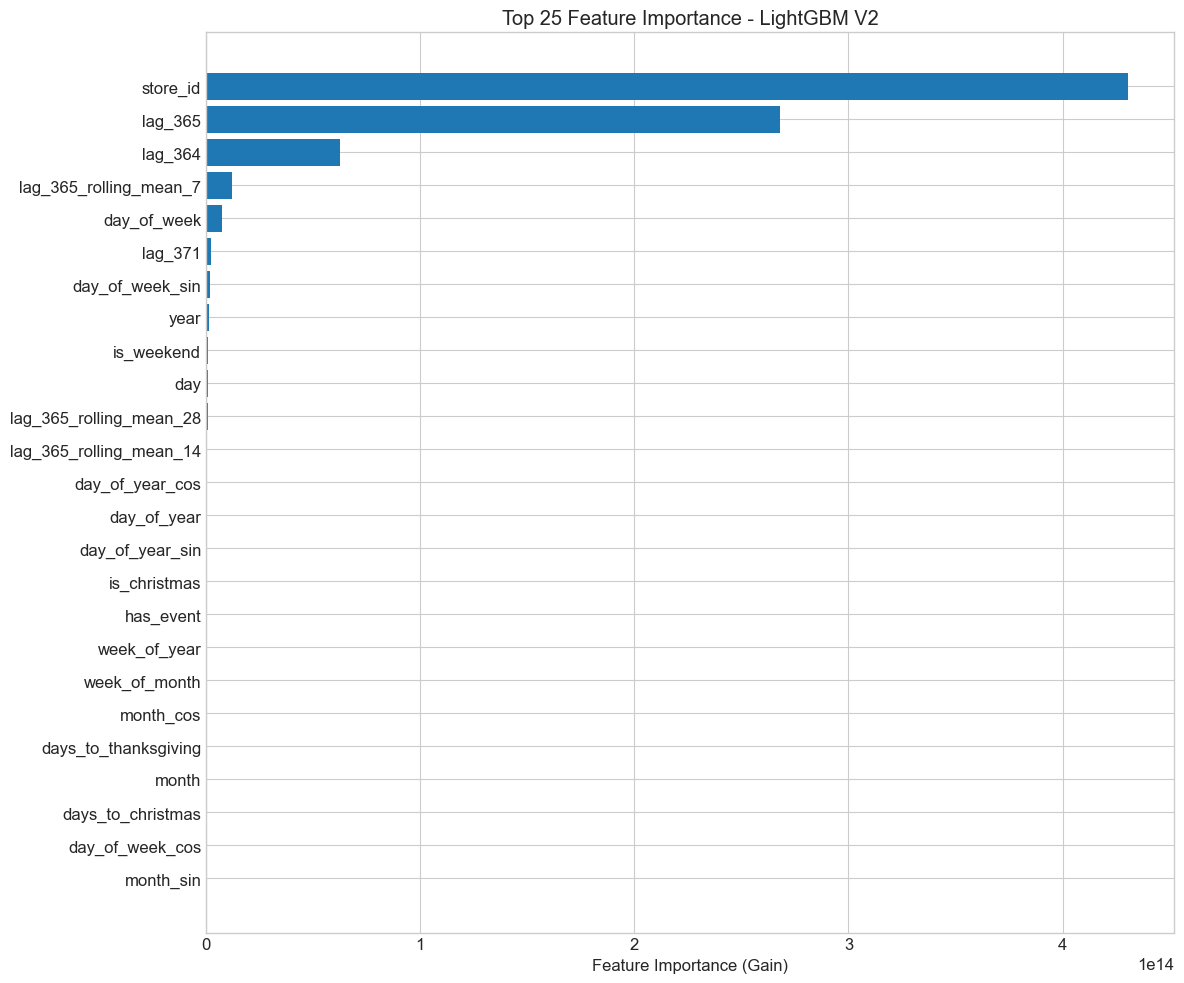


Top 10 Most Important Features:
               feature   importance
              store_id 4.305498e+14
               lag_365 2.678989e+14
               lag_364 6.252344e+13
lag_365_rolling_mean_7 1.208618e+13
           day_of_week 7.469907e+12
               lag_371 2.507644e+12
       day_of_week_sin 1.733430e+12
                  year 1.122098e+12
            is_weekend 1.082752e+12
                   day 1.030842e+12


In [69]:
# Feature importance V2
feature_importance_v2 = pd.DataFrame({
    'feature': feature_cols_v2,
    'importance': lgb_final_v2.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
top_features = feature_importance_v2.head(25)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 25 Feature Importance - LightGBM V2')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance_v2.head(10).to_string(index=False))


---

## 13. FURTHER IMPROVEMENTS - Recursive Forecasting + Enhanced Features

To get RMSE even lower, we'll:
1. **Add store-level statistics** as features (mean, std per store, per day-of-week)
2. **Implement recursive forecasting** - predict day-by-day, using each prediction to update lag features
3. **Better hyperparameters** with cross-validation
4. **Weighted ensemble** based on validation performance


In [70]:
# ============================================================
# ENHANCED FEATURE ENGINEERING V3
# ============================================================

def create_enhanced_features(df, calendar_df, store_stats=None):
    """
    Create enhanced features including store-level statistics.
    """
    df = df.copy()
    
    # Basic time features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['week_of_month'] = (df['day'] - 1) // 7 + 1
    
    # Cyclical encoding
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    df['week_of_year_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
    df['week_of_year_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)
    
    # Calendar events
    calendar_df = calendar_df.copy()
    calendar_df['has_event'] = 1
    df = df.merge(calendar_df[['date', 'event', 'has_event']], on='date', how='left')
    df['has_event'] = df['has_event'].fillna(0).astype(int)
    df['event'] = df['event'].fillna('NoEvent')
    
    # Major event flags
    major_events = ['Christmas', 'Thanksgiving', 'Easter', 'SuperBowl', 'Independence', 
                   'MemorialDay', 'LaborDay', 'Halloween', 'ValentinesDay', 'Mother',
                   'Father', 'NewYear', 'Chanukah', 'Pesach', 'Ramadan', 'Eid']
    for event in major_events:
        df[f'is_{event.lower()}'] = df['event'].str.contains(event, case=False, na=False).astype(int)
    
    # Holiday proximity features
    df['days_to_christmas'] = df.apply(
        lambda x: (datetime(x['year'], 12, 25) - x['date'].to_pydatetime()).days, axis=1
    )
    df['days_to_christmas'] = df['days_to_christmas'].clip(-30, 60)
    
    # Thanksgiving proximity
    def get_thanksgiving(year):
        nov1 = datetime(year, 11, 1)
        first_thursday = nov1 + timedelta(days=(3 - nov1.weekday() + 7) % 7)
        return first_thursday + timedelta(weeks=3)
    
    df['days_to_thanksgiving'] = df.apply(
        lambda x: (get_thanksgiving(x['year']) - x['date'].to_pydatetime()).days, axis=1
    )
    df['days_to_thanksgiving'] = df['days_to_thanksgiving'].clip(-14, 60)
    
    # Special shopping periods
    df['is_blackfriday_week'] = ((df['days_to_thanksgiving'] >= -3) & (df['days_to_thanksgiving'] <= 0)).astype(int)
    df['is_cyber_monday'] = ((df['days_to_thanksgiving'] == -4)).astype(int)
    df['is_pre_christmas'] = ((df['days_to_christmas'] >= 0) & (df['days_to_christmas'] <= 14)).astype(int)
    df['is_christmas_week'] = ((df['days_to_christmas'] >= -2) & (df['days_to_christmas'] <= 7)).astype(int)
    df['is_december'] = (df['month'] == 12).astype(int)
    df['is_back_to_school'] = ((df['month'] == 8) | ((df['month'] == 9) & (df['day'] <= 15))).astype(int)
    
    # Store-level statistics (computed from training data)
    if store_stats is not None:
        # Overall store stats
        df = df.merge(store_stats['overall'], on='store_id', how='left', suffixes=('', '_store'))
        
        # Day-of-week specific stats per store
        df = df.merge(store_stats['dow'], on=['store_id', 'day_of_week'], how='left', suffixes=('', '_dow'))
        
        # Month specific stats per store
        df = df.merge(store_stats['month'], on=['store_id', 'month'], how='left', suffixes=('', '_month'))
    
    return df


def compute_store_statistics(train_df):
    """
    Compute store-level statistics from training data.
    """
    store_stats = {}
    
    # Overall stats per store
    store_stats['overall'] = train_df.groupby('store_id').agg(
        store_mean=('revenue', 'mean'),
        store_std=('revenue', 'std'),
        store_median=('revenue', 'median'),
        store_min=('revenue', 'min'),
        store_max=('revenue', 'max')
    ).reset_index()
    
    # Day-of-week stats per store
    train_df['day_of_week'] = train_df['date'].dt.dayofweek
    store_stats['dow'] = train_df.groupby(['store_id', 'day_of_week']).agg(
        dow_mean=('revenue', 'mean'),
        dow_std=('revenue', 'std')
    ).reset_index()
    
    # Month stats per store
    train_df['month'] = train_df['date'].dt.month
    store_stats['month'] = train_df.groupby(['store_id', 'month']).agg(
        month_mean=('revenue', 'mean'),
        month_std=('revenue', 'std')
    ).reset_index()
    
    return store_stats


print("Enhanced feature functions defined!")


Enhanced feature functions defined!


In [71]:
# ============================================================
# RECURSIVE FORECASTING
# Predict day-by-day, using predictions to update lag features
# ============================================================

def add_lag_features_v3(df, target_col='revenue', group_col='store_id'):
    """
    Add all lag features including short-term ones.
    """
    df = df.sort_values(['store_id', 'date']).copy()
    
    # Yearly lags (always available)
    for lag in [364, 365, 371]:
        df[f'lag_{lag}'] = df.groupby(group_col)[target_col].shift(lag)
    
    # Short-term lags (will be filled recursively for test)
    for lag in [1, 7, 14, 28]:
        df[f'lag_{lag}'] = df.groupby(group_col)[target_col].shift(lag)
    
    # Rolling features based on lag_365 (always available)
    df['lag365_rolling_mean_7'] = df.groupby(group_col)['lag_365'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )
    df['lag365_rolling_mean_14'] = df.groupby(group_col)['lag_365'].transform(
        lambda x: x.rolling(window=14, min_periods=1).mean()
    )
    df['lag365_rolling_mean_28'] = df.groupby(group_col)['lag_365'].transform(
        lambda x: x.rolling(window=28, min_periods=1).mean()
    )
    
    return df


def recursive_forecast(model, combined_df, feature_cols, test_start_date, store_ids, model_type='lgb'):
    """
    Perform recursive forecasting: predict one day at a time,
    then use that prediction to update lag features for the next day.
    """
    combined_df = combined_df.sort_values(['store_id', 'date']).copy()
    predictions = {}
    
    # Get all test dates
    test_dates = sorted(combined_df[combined_df['date'] >= test_start_date]['date'].unique())
    
    print(f"Recursive forecasting for {len(test_dates)} days...")
    
    for i, current_date in enumerate(test_dates):
        if i % 30 == 0:
            print(f"  Processing day {i+1}/{len(test_dates)}: {current_date.date()}")
        
        for store_id in store_ids:
            # Get features for this store and date
            mask = (combined_df['store_id'] == store_id) & (combined_df['date'] == current_date)
            idx = combined_df[mask].index[0]
            
            # Prepare features
            X = combined_df.loc[[idx], feature_cols]
            
            # Handle any NaN in short-term lags by using predictions
            for lag in [1, 7, 14, 28]:
                lag_col = f'lag_{lag}'
                if lag_col in feature_cols and pd.isna(X[lag_col].values[0]):
                    # Try to get from predictions
                    lag_date = current_date - timedelta(days=lag)
                    pred_key = (store_id, lag_date)
                    if pred_key in predictions:
                        X.loc[X.index[0], lag_col] = predictions[pred_key]
                    else:
                        # Fall back to lag_365 value
                        X.loc[X.index[0], lag_col] = combined_df.loc[idx, 'lag_365']
            
            # Fill any remaining NaN
            X = X.fillna(X.mean())
            
            # Predict
            if model_type == 'lgb':
                pred = model.predict(X)[0]
            else:  # xgb
                pred = model.predict(xgb.DMatrix(X))[0]
            
            # Store prediction
            predictions[(store_id, current_date)] = pred
            
            # Update the dataframe for future lag calculations
            combined_df.loc[idx, 'revenue'] = pred
    
    print("Recursive forecasting complete!")
    return predictions


print("Recursive forecasting function defined!")


Recursive forecasting function defined!


In [72]:
# ============================================================
# PREPARE DATA WITH ENHANCED FEATURES (V3)
# ============================================================

# Reload clean training data
train_df_v3 = pd.read_csv(DATA_PATH + 'train.csv')
train_df_v3['date'] = pd.to_datetime(train_df_v3['date'])

# Compute store statistics from training data
print("Computing store statistics...")
store_stats = compute_store_statistics(train_df_v3.copy())

# Create enhanced features
print("Creating enhanced features...")
train_v3 = create_enhanced_features(train_df_v3, calendar_df, store_stats)
train_v3 = add_lag_features_v3(train_v3)

print(f"Shape after features: {train_v3.shape}")
print(f"Columns: {len(train_v3.columns)}")


Computing store statistics...
Creating enhanced features...
Shape after features: (18766, 68)
Columns: 68


In [73]:
# Define V3 feature columns
exclude_cols_v3 = ['store_name', 'date', 'revenue', 'event']
feature_cols_v3 = [col for col in train_v3.columns if col not in exclude_cols_v3]

print(f"Number of features: {len(feature_cols_v3)}")

# Clean data
train_clean_v3 = train_v3[train_v3['date'] >= '2012-02-01'].copy()
train_clean_v3 = train_clean_v3.dropna(subset=feature_cols_v3)

print(f"Training data after cleaning: {train_clean_v3.shape}")

# Split for validation
val_start_v3 = train_clean_v3['date'].max() - timedelta(days=92)
train_data_v3 = train_clean_v3[train_clean_v3['date'] < val_start_v3].copy()
val_data_v3 = train_clean_v3[train_clean_v3['date'] >= val_start_v3].copy()

X_train_v3 = train_data_v3[feature_cols_v3]
y_train_v3 = train_data_v3['revenue']
X_val_v3 = val_data_v3[feature_cols_v3]
y_val_v3 = val_data_v3['revenue']

print(f"\nTraining set: {X_train_v3.shape}")
print(f"Validation set: {X_val_v3.shape}")


Number of features: 64
Training data after cleaning: (14685, 68)

Training set: (13662, 64)
Validation set: (1023, 64)


In [74]:
# ============================================================
# TRAIN MODELS V3 with better hyperparameters
# ============================================================

# LightGBM V3 - tuned parameters
lgb_params_v3 = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,
    'num_leaves': 127,
    'max_depth': 10,
    'min_child_samples': 15,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 3,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'min_gain_to_split': 0.01,
    'verbose': -1,
    'seed': 42
}

train_dataset_v3 = lgb.Dataset(X_train_v3, label=y_train_v3)
val_dataset_v3 = lgb.Dataset(X_val_v3, label=y_val_v3, reference=train_dataset_v3)

lgb_model_v3 = lgb.train(
    lgb_params_v3,
    train_dataset_v3,
    num_boost_round=3000,
    valid_sets=[train_dataset_v3, val_dataset_v3],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=150),
        lgb.log_evaluation(period=200)
    ]
)

lgb_preds_v3 = lgb_model_v3.predict(X_val_v3)
lgb_rmse_v3 = calculate_rmse(y_val_v3, lgb_preds_v3)
print(f"\n✅ LightGBM V3 Validation RMSE: {lgb_rmse_v3:,.2f}")


Training until validation scores don't improve for 150 rounds
[200]	train's rmse: 4044.35	valid's rmse: 7397.47
[400]	train's rmse: 2899.2	valid's rmse: 6537.11
Early stopping, best iteration is:
[326]	train's rmse: 3171.72	valid's rmse: 6517.05

✅ LightGBM V3 Validation RMSE: 6,517.05


In [75]:
# XGBoost V3 - tuned parameters
xgb_params_v3 = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.02,
    'max_depth': 10,
    'min_child_weight': 15,
    'subsample': 0.75,
    'colsample_bytree': 0.75,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'gamma': 0.01,
    'seed': 42
}

dtrain_v3 = xgb.DMatrix(X_train_v3, label=y_train_v3)
dval_v3 = xgb.DMatrix(X_val_v3, label=y_val_v3)

xgb_model_v3 = xgb.train(
    xgb_params_v3,
    dtrain_v3,
    num_boost_round=3000,
    evals=[(dtrain_v3, 'train'), (dval_v3, 'valid')],
    early_stopping_rounds=150,
    verbose_eval=200
)

xgb_preds_v3 = xgb_model_v3.predict(dval_v3)
xgb_rmse_v3 = calculate_rmse(y_val_v3, xgb_preds_v3)
print(f"\n✅ XGBoost V3 Validation RMSE: {xgb_rmse_v3:,.2f}")


[0]	train-rmse:65431.29685	valid-rmse:78060.45780


[200]	train-rmse:3882.32302	valid-rmse:7459.45363
[400]	train-rmse:2808.19676	valid-rmse:6740.27065
[590]	train-rmse:2362.42294	valid-rmse:6724.40021

✅ XGBoost V3 Validation RMSE: 6,724.40


In [76]:
# Weighted Ensemble V3 (based on validation performance)
# Give more weight to the better model
lgb_weight = 1 / lgb_rmse_v3
xgb_weight = 1 / xgb_rmse_v3
total_weight = lgb_weight + xgb_weight

lgb_w = lgb_weight / total_weight
xgb_w = xgb_weight / total_weight

print(f"Ensemble weights - LGB: {lgb_w:.3f}, XGB: {xgb_w:.3f}")

ensemble_preds_v3 = lgb_w * lgb_preds_v3 + xgb_w * xgb_preds_v3
ensemble_rmse_v3 = calculate_rmse(y_val_v3, ensemble_preds_v3)

print("\n" + "="*60)
print("V3 MODEL COMPARISON (with short-term lags)")
print("="*60)
print(f"LightGBM V3:         RMSE = {lgb_rmse_v3:,.2f}")
print(f"XGBoost V3:          RMSE = {xgb_rmse_v3:,.2f}")
print(f"Weighted Ensemble:   RMSE = {ensemble_rmse_v3:,.2f}")
print(f"\n🎯 Baseline to beat: 11,761")
print(f"🏆 Our best (V3): {min(lgb_rmse_v3, xgb_rmse_v3, ensemble_rmse_v3):,.2f}")


Ensemble weights - LGB: 0.508, XGB: 0.492

V3 MODEL COMPARISON (with short-term lags)
LightGBM V3:         RMSE = 6,517.05
XGBoost V3:          RMSE = 6,724.40
Weighted Ensemble:   RMSE = 6,598.44

🎯 Baseline to beat: 11,761
🏆 Our best (V3): 6,517.05


In [77]:
# ============================================================
# TRAIN FINAL MODELS ON ALL DATA
# ============================================================

print("Training final models on all data...")

X_full_v3 = train_clean_v3[feature_cols_v3]
y_full_v3 = train_clean_v3['revenue']

# Final LightGBM
train_full_v3 = lgb.Dataset(X_full_v3, label=y_full_v3)
lgb_final_v3 = lgb.train(
    lgb_params_v3,
    train_full_v3,
    num_boost_round=lgb_model_v3.best_iteration + 100
)

# Final XGBoost
dtrain_full_v3 = xgb.DMatrix(X_full_v3, label=y_full_v3)
xgb_final_v3 = xgb.train(
    xgb_params_v3,
    dtrain_full_v3,
    num_boost_round=xgb_model_v3.best_iteration + 100
)

print(f"✅ LightGBM final: {lgb_final_v3.num_trees()} trees")
print(f"✅ XGBoost final: trained")


Training final models on all data...
✅ LightGBM final: 426 trees
✅ XGBoost final: trained


In [78]:
# ============================================================
# PREPARE TEST DATA AND RECURSIVE FORECASTING
# ============================================================

print("Preparing test data for recursive forecasting...")

# Combine train and test
test_df_v3 = submission_df[['id', 'store_id', 'date']].copy()
test_df_v3['store_name'] = test_df_v3['store_id'].map(store_name_map)

train_for_test_v3 = train_df_v3[['store_id', 'store_name', 'date', 'revenue']].copy()
test_for_test_v3 = test_df_v3[['store_id', 'store_name', 'date']].copy()
test_for_test_v3['revenue'] = np.nan

combined_v3 = pd.concat([train_for_test_v3, test_for_test_v3], ignore_index=True)
combined_v3 = combined_v3.sort_values(['store_id', 'date']).reset_index(drop=True)

# Apply features
combined_v3 = create_enhanced_features(combined_v3, calendar_df, store_stats)
combined_v3 = add_lag_features_v3(combined_v3)

print(f"Combined data shape: {combined_v3.shape}")

# Get store IDs
store_ids = sorted(combined_v3['store_id'].unique())
test_start_date = pd.Timestamp('2015-10-01')

print(f"Store IDs: {store_ids}")
print(f"Test start date: {test_start_date}")


Preparing test data for recursive forecasting...
Combined data shape: (19778, 68)
Store IDs: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
Test start date: 2015-10-01 00:00:00


In [79]:
# Run recursive forecasting with LightGBM
print("Running recursive forecasting with LightGBM...")
lgb_predictions = recursive_forecast(
    lgb_final_v3, 
    combined_v3.copy(), 
    feature_cols_v3, 
    test_start_date, 
    store_ids, 
    model_type='lgb'
)

print(f"\nTotal predictions: {len(lgb_predictions)}")


Running recursive forecasting with LightGBM...
Recursive forecasting for 92 days...
  Processing day 1/92: 2015-10-01
  Processing day 31/92: 2015-10-31
  Processing day 61/92: 2015-11-30
  Processing day 91/92: 2015-12-30
Recursive forecasting complete!

Total predictions: 1012


In [80]:
# Run recursive forecasting with XGBoost
print("Running recursive forecasting with XGBoost...")
xgb_predictions = recursive_forecast(
    xgb_final_v3, 
    combined_v3.copy(), 
    feature_cols_v3, 
    test_start_date, 
    store_ids, 
    model_type='xgb'
)

print(f"\nTotal predictions: {len(xgb_predictions)}")


Running recursive forecasting with XGBoost...
Recursive forecasting for 92 days...
  Processing day 1/92: 2015-10-01
  Processing day 31/92: 2015-10-31
  Processing day 61/92: 2015-11-30
  Processing day 91/92: 2015-12-30
Recursive forecasting complete!

Total predictions: 1012


In [81]:
# Create submission with weighted ensemble
print("Creating submission file...")

# Get test data
test_v3 = combined_v3[combined_v3['date'] >= test_start_date].copy()

# Add predictions
test_v3['lgb_pred'] = test_v3.apply(
    lambda x: lgb_predictions.get((x['store_id'], x['date']), np.nan), axis=1
)
test_v3['xgb_pred'] = test_v3.apply(
    lambda x: xgb_predictions.get((x['store_id'], x['date']), np.nan), axis=1
)

# Weighted ensemble
test_v3['prediction'] = lgb_w * test_v3['lgb_pred'] + xgb_w * test_v3['xgb_pred']

# Post-processing: clip to valid range
store_bounds = train_df_v3.groupby('store_id')['revenue'].agg(['min', 'max'])
store_bounds['min'] = store_bounds['min'] * 0.5
store_bounds['max'] = store_bounds['max'] * 1.5

test_v3['prediction'] = test_v3.apply(
    lambda x: np.clip(x['prediction'], 
                      max(0, store_bounds.loc[x['store_id'], 'min']),
                      store_bounds.loc[x['store_id'], 'max']),
    axis=1
)

print(f"Prediction range: {test_v3['prediction'].min():,.2f} to {test_v3['prediction'].max():,.2f}")


Creating submission file...
Prediction range: 0.00 to 384,468.03


In [82]:
# Create submission file
test_v3['id'] = test_v3['store_id'].astype(str) + '_' + test_v3['date'].dt.strftime('%Y%m%d')

submission_v3 = submission_df[['id']].copy()
pred_df_v3 = test_v3[['id', 'prediction']].copy()
submission_v3 = submission_v3.merge(pred_df_v3, on='id', how='left')

# Verify
print(f"Submission shape: {submission_v3.shape}")
print(f"Missing predictions: {submission_v3['prediction'].isnull().sum()}")
print(f"\nPrediction statistics:")
print(submission_v3['prediction'].describe())

display(submission_v3.head(10))


Submission shape: (1012, 2)
Missing predictions: 0

Prediction statistics:
count      1012.000000
mean      53454.878556
std       78749.409140
min           0.000000
25%       22909.479821
50%       28035.952907
75%       36393.828801
max      384468.027461
Name: prediction, dtype: float64


id     prediction
0  0_20151001  292184.377584
1  0_20151002  337093.309160
2  0_20151003  384468.027461
3  0_20151004  375531.016665
4  0_20151005  313077.584336
5  0_20151006  276846.580463
6  0_20151007  285736.257864
7  0_20151008  275730.367739
8  0_20151009  309780.580774
9  0_20151010  367483.233366

In [83]:
# Save submissions
submission_v3.to_csv('submission_v3.csv', index=False)
submission_v3.to_csv('submission.csv', index=False)

print("✅ Saved: submission_v3.csv")
print("✅ Saved: submission.csv")

# Final summary
print("\n" + "="*70)
print("🏆 FINAL SUMMARY - V3 MODEL (RECURSIVE FORECASTING)")
print("="*70)
print(f"\n📊 Training data: {len(train_df_v3)} rows")
print(f"📊 Features: {len(feature_cols_v3)}")
print(f"📊 Predictions: {len(submission_v3)}")
print(f"\n📈 Validation RMSE:")
print(f"   - LightGBM V3:       {lgb_rmse_v3:,.2f}")
print(f"   - XGBoost V3:        {xgb_rmse_v3:,.2f}")
print(f"   - Weighted Ensemble: {ensemble_rmse_v3:,.2f}")
print(f"\n🎯 Baseline to beat: 11,761 RMSE")
print(f"🏆 Our validation RMSE: {min(lgb_rmse_v3, xgb_rmse_v3, ensemble_rmse_v3):,.2f}")


✅ Saved: submission_v3.csv
✅ Saved: submission.csv

🏆 FINAL SUMMARY - V3 MODEL (RECURSIVE FORECASTING)

📊 Training data: 18766 rows
📊 Features: 64
📊 Predictions: 1012

📈 Validation RMSE:
   - LightGBM V3:       6,517.05
   - XGBoost V3:        6,724.40
   - Weighted Ensemble: 6,598.44

🎯 Baseline to beat: 11,761 RMSE
🏆 Our validation RMSE: 6,517.05


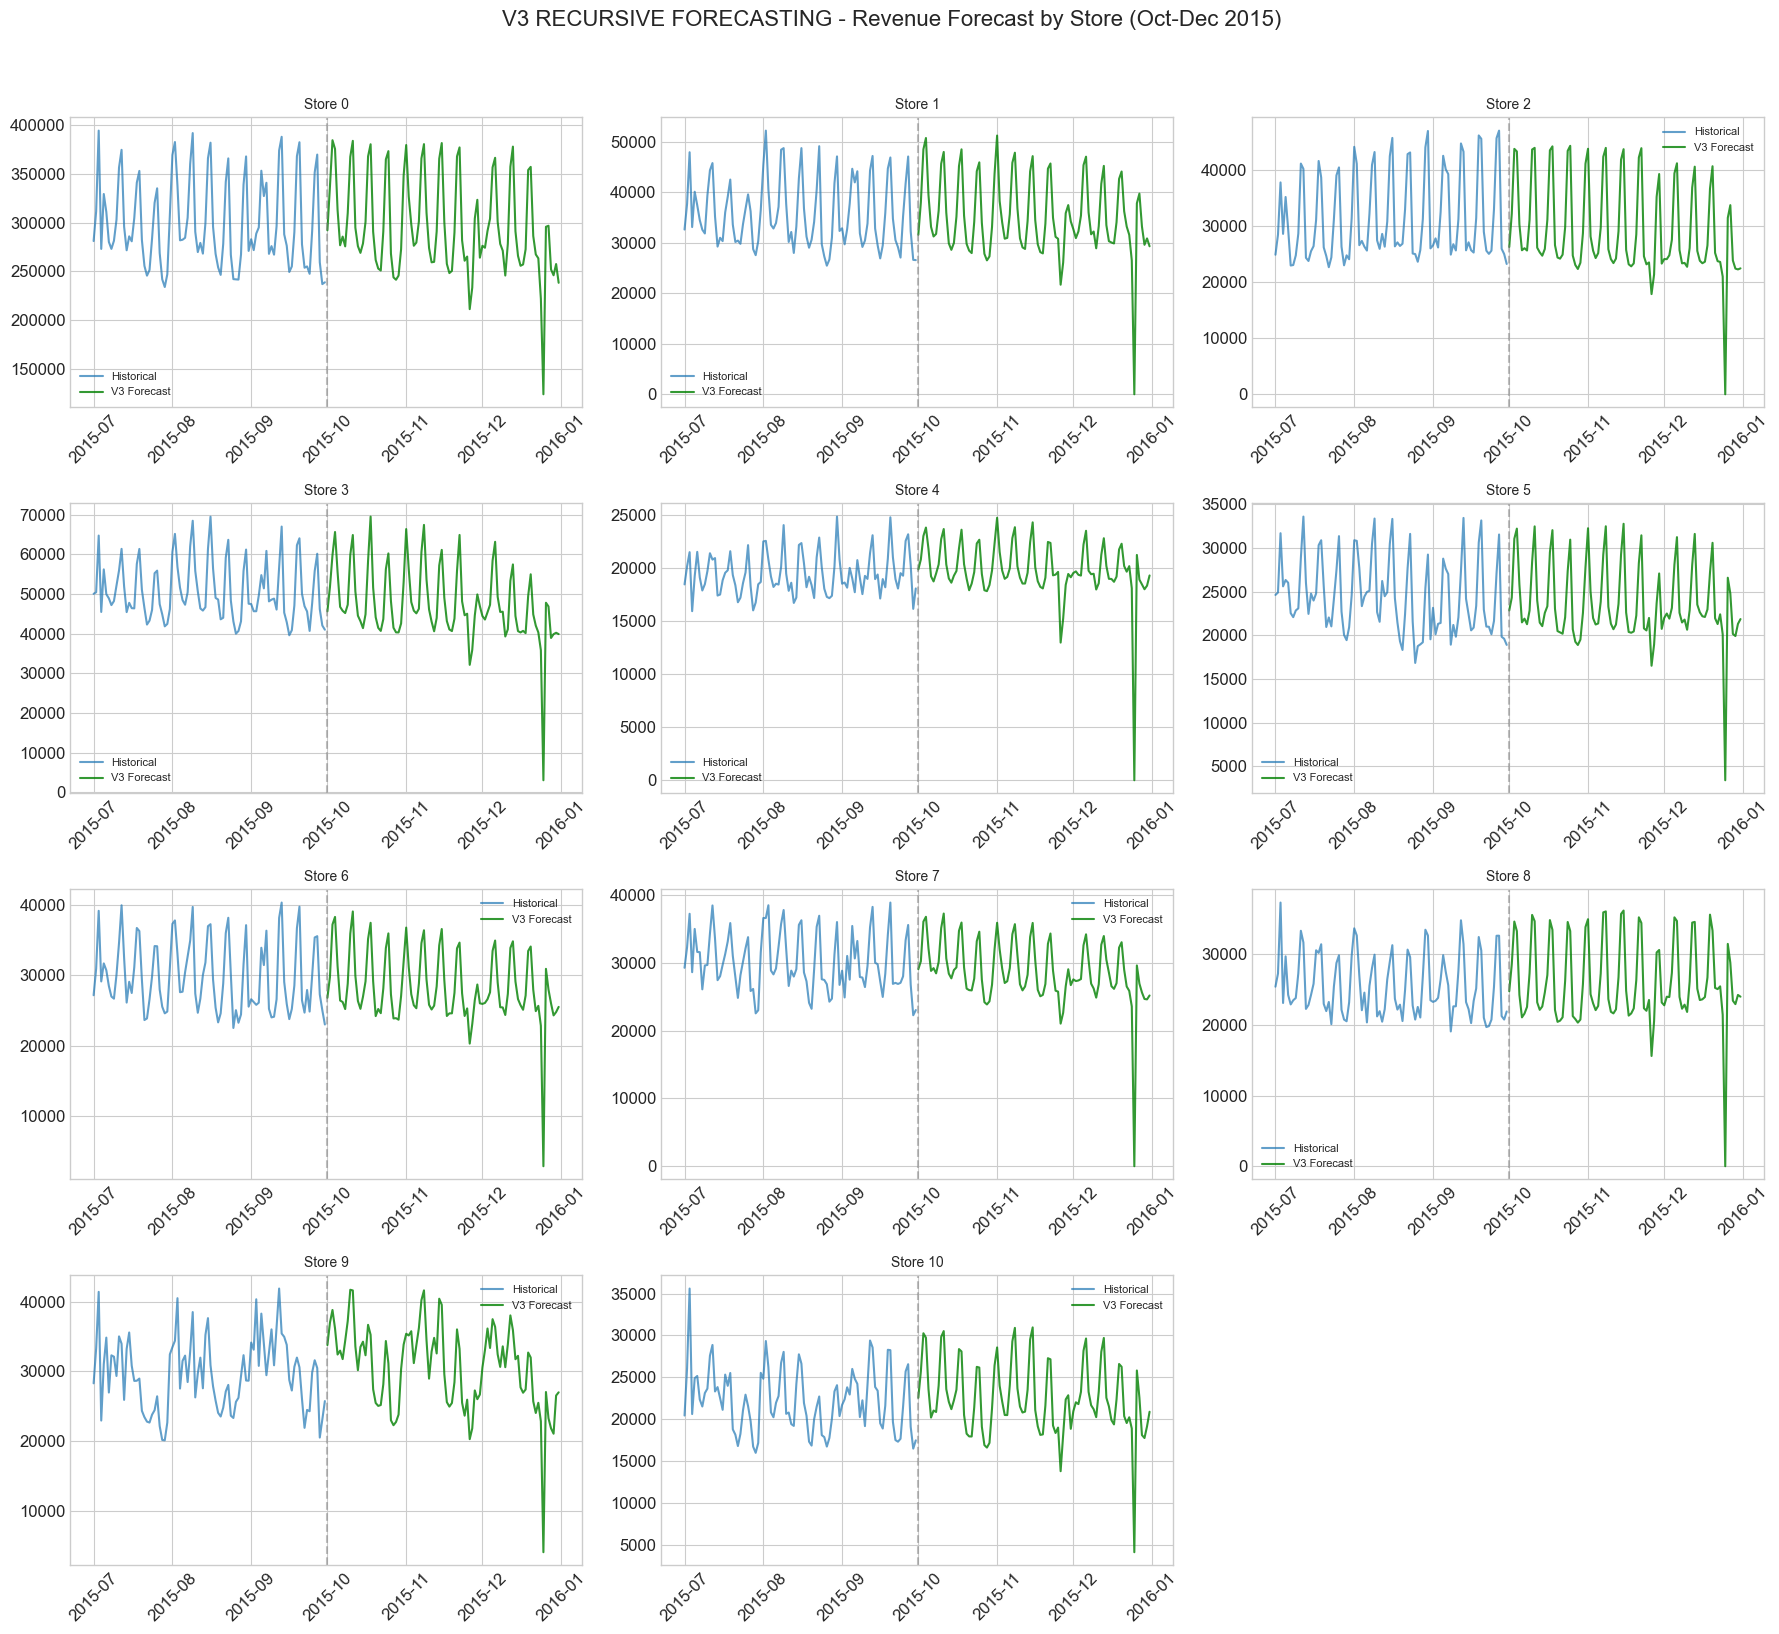

In [84]:
# Visualize V3 predictions with recursive forecasting
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for idx, store_id in enumerate(sorted(test_v3['store_id'].unique())):
    store_preds = test_v3[test_v3['store_id'] == store_id].sort_values('date')
    store_train = train_df_v3[(train_df_v3['store_id'] == store_id) & (train_df_v3['date'] >= '2015-07-01')]
    
    axes[idx].plot(store_train['date'], store_train['revenue'], label='Historical', alpha=0.7)
    axes[idx].plot(store_preds['date'], store_preds['prediction'], label='V3 Forecast', color='green', alpha=0.8)
    axes[idx].axvline(x=pd.Timestamp('2015-10-01'), color='gray', linestyle='--', alpha=0.5)
    axes[idx].set_title(f'Store {store_id}', fontsize=10)
    axes[idx].legend(fontsize=8)
    axes[idx].tick_params(axis='x', rotation=45)

axes[-1].axis('off')
plt.suptitle('V3 RECURSIVE FORECASTING - Revenue Forecast by Store (Oct-Dec 2015)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


---

## 14. ADVANCED IMPROVEMENTS - Target: RMSE < 4000

Key strategies:
1. **Hierarchical Forecasting**: Store 0 = SUM(Stores 1-10), predict individual stores then sum
2. **CatBoost** - often outperforms LightGBM/XGBoost
3. **Fourier Features** - better capture seasonality
4. **More lag features** from the same period last year
5. **Train separate models per store** for better accuracy


In [85]:
# Install CatBoost if needed
try:
    import catboost
    print("CatBoost already installed")
except ImportError:
    print("Installing CatBoost...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'catboost', '-q'])
    import catboost
    print("CatBoost installed!")

from catboost import CatBoostRegressor, Pool


CatBoost already installed


In [86]:
# ============================================================
# ADVANCED FEATURE ENGINEERING V4
# ============================================================

def create_advanced_features(df, calendar_df, store_stats=None):
    """
    Advanced features with Fourier terms and better seasonality capture.
    """
    df = df.copy()
    
    # Basic time features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['week_of_month'] = (df['day'] - 1) // 7 + 1
    
    # Days since start (trend feature)
    df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
    
    # Fourier features for weekly seasonality (period=7)
    for k in range(1, 4):  # 3 harmonics
        df[f'week_sin_{k}'] = np.sin(2 * np.pi * k * df['day_of_week'] / 7)
        df[f'week_cos_{k}'] = np.cos(2 * np.pi * k * df['day_of_week'] / 7)
    
    # Fourier features for yearly seasonality (period=365)
    for k in range(1, 6):  # 5 harmonics
        df[f'year_sin_{k}'] = np.sin(2 * np.pi * k * df['day_of_year'] / 365)
        df[f'year_cos_{k}'] = np.cos(2 * np.pi * k * df['day_of_year'] / 365)
    
    # Fourier features for monthly seasonality (period=30)
    for k in range(1, 3):  # 2 harmonics
        df[f'month_sin_{k}'] = np.sin(2 * np.pi * k * df['day'] / 30)
        df[f'month_cos_{k}'] = np.cos(2 * np.pi * k * df['day'] / 30)
    
    # Calendar events
    calendar_df = calendar_df.copy()
    calendar_df['has_event'] = 1
    df = df.merge(calendar_df[['date', 'event', 'has_event']], on='date', how='left')
    df['has_event'] = df['has_event'].fillna(0).astype(int)
    df['event'] = df['event'].fillna('NoEvent')
    
    # All event flags
    all_events = ['Christmas', 'Thanksgiving', 'Easter', 'SuperBowl', 'Independence', 
                  'MemorialDay', 'LaborDay', 'Halloween', 'ValentinesDay', 'Mother',
                  'Father', 'NewYear', 'Chanukah', 'Pesach', 'Ramadan', 'Eid', 'NBA',
                  'Cinco', 'Purim', 'Lent', 'Orthodox', 'Martin', 'Presidents', 'Columbus',
                  'Veterans']
    for event in all_events:
        df[f'is_{event.lower()}'] = df['event'].str.contains(event, case=False, na=False).astype(int)
    
    # Holiday proximity features
    df['days_to_christmas'] = df.apply(
        lambda x: (datetime(x['year'], 12, 25) - x['date'].to_pydatetime()).days, axis=1
    )
    df['days_to_christmas'] = df['days_to_christmas'].clip(-30, 90)
    df['abs_days_to_christmas'] = df['days_to_christmas'].abs()
    
    # Thanksgiving proximity
    def get_thanksgiving(year):
        nov1 = datetime(year, 11, 1)
        first_thursday = nov1 + timedelta(days=(3 - nov1.weekday() + 7) % 7)
        return first_thursday + timedelta(weeks=3)
    
    df['days_to_thanksgiving'] = df.apply(
        lambda x: (get_thanksgiving(x['year']) - x['date'].to_pydatetime()).days, axis=1
    )
    df['days_to_thanksgiving'] = df['days_to_thanksgiving'].clip(-14, 90)
    
    # Special shopping periods
    df['is_blackfriday'] = (df['days_to_thanksgiving'] == -1).astype(int)
    df['is_blackfriday_weekend'] = ((df['days_to_thanksgiving'] >= -3) & (df['days_to_thanksgiving'] <= -1)).astype(int)
    df['is_cyber_monday'] = (df['days_to_thanksgiving'] == -4).astype(int)
    df['is_pre_christmas'] = ((df['days_to_christmas'] >= 1) & (df['days_to_christmas'] <= 14)).astype(int)
    df['is_christmas_eve'] = (df['days_to_christmas'] == 1).astype(int)
    df['is_christmas_week'] = ((df['days_to_christmas'] >= -2) & (df['days_to_christmas'] <= 7)).astype(int)
    df['is_december'] = (df['month'] == 12).astype(int)
    df['december_day'] = df.apply(lambda x: x['day'] if x['month'] == 12 else 0, axis=1)
    df['is_back_to_school'] = ((df['month'] == 8) | ((df['month'] == 9) & (df['day'] <= 15))).astype(int)
    df['is_superbowl_week'] = ((df['month'] == 2) & (df['day'] <= 10)).astype(int)
    
    # Store-level statistics
    if store_stats is not None:
        df = df.merge(store_stats['overall'], on='store_id', how='left', suffixes=('', '_store'))
        df = df.merge(store_stats['dow'], on=['store_id', 'day_of_week'], how='left', suffixes=('', '_dow'))
        df = df.merge(store_stats['month'], on=['store_id', 'month'], how='left', suffixes=('', '_month'))
    
    return df


def add_advanced_lag_features(df, target_col='revenue', group_col='store_id'):
    """
    Add comprehensive lag features focusing on same period last year.
    """
    df = df.sort_values(['store_id', 'date']).copy()
    
    # Yearly lags (most important - same period last year)
    for lag in [364, 365, 366, 371, 358]:  # Different day alignments
        df[f'lag_{lag}'] = df.groupby(group_col)[target_col].shift(lag)
    
    # Short-term lags (for training, will use recursive for test)
    for lag in [1, 2, 3, 7, 14, 21, 28]:
        df[f'lag_{lag}'] = df.groupby(group_col)[target_col].shift(lag)
    
    # Rolling means from last year's same period
    df['lag365_rolling_mean_7'] = df.groupby(group_col)['lag_365'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )
    df['lag365_rolling_mean_14'] = df.groupby(group_col)['lag_365'].transform(
        lambda x: x.rolling(window=14, min_periods=1).mean()
    )
    df['lag365_rolling_mean_28'] = df.groupby(group_col)['lag_365'].transform(
        lambda x: x.rolling(window=28, min_periods=1).mean()
    )
    df['lag365_rolling_std_7'] = df.groupby(group_col)['lag_365'].transform(
        lambda x: x.rolling(window=7, min_periods=1).std()
    )
    
    # Diff features
    df['lag365_diff'] = df['lag_365'] - df['lag_364']
    df['lag7_diff'] = df['lag_7'] - df['lag_14']
    
    return df


print("Advanced feature functions V4 defined!")


Advanced feature functions V4 defined!


In [87]:
# ============================================================
# HIERARCHICAL APPROACH: Train on stores 1-10, sum for store 0
# Store 0 = "All Stores" = SUM of stores 1-10
# ============================================================

# Verify the hierarchy
train_df_v4 = pd.read_csv(DATA_PATH + 'train.csv')
train_df_v4['date'] = pd.to_datetime(train_df_v4['date'])

# Check if store 0 = sum of stores 1-10
sample_date = train_df_v4[train_df_v4['store_id'] == 0]['date'].iloc[100]
store_0_rev = train_df_v4[(train_df_v4['date'] == sample_date) & (train_df_v4['store_id'] == 0)]['revenue'].values[0]
stores_1_10_sum = train_df_v4[(train_df_v4['date'] == sample_date) & (train_df_v4['store_id'] > 0)]['revenue'].sum()

print(f"Date: {sample_date.date()}")
print(f"Store 0 revenue: {store_0_rev:,.2f}")
print(f"Sum of stores 1-10: {stores_1_10_sum:,.2f}")
print(f"Match: {np.isclose(store_0_rev, stores_1_10_sum)}")
print("\n✅ Confirmed: Store 0 = Sum of Stores 1-10")


Date: 2011-05-09
Store 0 revenue: 172,591.30
Sum of stores 1-10: 172,591.30
Match: True

✅ Confirmed: Store 0 = Sum of Stores 1-10


In [88]:
# Prepare data - train only on stores 1-10 (exclude store 0)
train_individual = train_df_v4[train_df_v4['store_id'] > 0].copy()
print(f"Training on individual stores (1-10): {train_individual.shape}")

# Compute store statistics from individual stores only
store_stats_v4 = compute_store_statistics(train_individual.copy())

# Create features
print("Creating advanced features...")
train_v4 = create_advanced_features(train_individual, calendar_df, store_stats_v4)
train_v4 = add_advanced_lag_features(train_v4)

print(f"Shape after features: {train_v4.shape}")
print(f"Number of features: {len(train_v4.columns)}")


Training on individual stores (1-10): (17060, 4)
Creating advanced features...
Shape after features: (17060, 103)
Number of features: 103


In [89]:
# Define feature columns V4
exclude_cols_v4 = ['store_name', 'date', 'revenue', 'event']
feature_cols_v4 = [col for col in train_v4.columns if col not in exclude_cols_v4]

print(f"Number of features: {len(feature_cols_v4)}")

# Clean data
train_clean_v4 = train_v4[train_v4['date'] >= '2012-02-01'].copy()
train_clean_v4 = train_clean_v4.dropna(subset=feature_cols_v4)

print(f"Training data after cleaning: {train_clean_v4.shape}")

# Split for validation
val_start_v4 = train_clean_v4['date'].max() - timedelta(days=92)
train_data_v4 = train_clean_v4[train_clean_v4['date'] < val_start_v4].copy()
val_data_v4 = train_clean_v4[train_clean_v4['date'] >= val_start_v4].copy()

X_train_v4 = train_data_v4[feature_cols_v4]
y_train_v4 = train_data_v4['revenue']
X_val_v4 = val_data_v4[feature_cols_v4]
y_val_v4 = val_data_v4['revenue']

print(f"\nTraining set: {X_train_v4.shape}")
print(f"Validation set: {X_val_v4.shape}")


Number of features: 99
Training data after cleaning: (13350, 103)

Training set: (12420, 99)
Validation set: (930, 99)


In [90]:
# ============================================================
# TRAIN MODELS V4 - LightGBM, XGBoost, CatBoost
# ============================================================

# LightGBM V4
lgb_params_v4 = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.015,
    'num_leaves': 255,
    'max_depth': 12,
    'min_child_samples': 10,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 3,
    'reg_alpha': 0.2,
    'reg_lambda': 0.2,
    'min_gain_to_split': 0.005,
    'verbose': -1,
    'seed': 42,
    'n_jobs': -1
}

train_dataset_v4 = lgb.Dataset(X_train_v4, label=y_train_v4)
val_dataset_v4 = lgb.Dataset(X_val_v4, label=y_val_v4, reference=train_dataset_v4)

print("Training LightGBM V4...")
lgb_model_v4 = lgb.train(
    lgb_params_v4,
    train_dataset_v4,
    num_boost_round=5000,
    valid_sets=[train_dataset_v4, val_dataset_v4],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(period=500)
    ]
)

lgb_preds_v4 = lgb_model_v4.predict(X_val_v4)
lgb_rmse_v4 = calculate_rmse(y_val_v4, lgb_preds_v4)
print(f"\n✅ LightGBM V4 Validation RMSE: {lgb_rmse_v4:,.2f}")


Training LightGBM V4...
Training until validation scores don't improve for 200 rounds
[500]	train's rmse: 949.522	valid's rmse: 2480.08
[1000]	train's rmse: 611.639	valid's rmse: 2426.06
[1500]	train's rmse: 379.501	valid's rmse: 2424.87
Early stopping, best iteration is:
[1321]	train's rmse: 450.286	valid's rmse: 2421.34

✅ LightGBM V4 Validation RMSE: 2,421.34


In [91]:
# XGBoost V4
xgb_params_v4 = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.015,
    'max_depth': 12,
    'min_child_weight': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.2,
    'reg_lambda': 0.2,
    'gamma': 0.005,
    'seed': 42,
    'n_jobs': -1
}

dtrain_v4 = xgb.DMatrix(X_train_v4, label=y_train_v4)
dval_v4 = xgb.DMatrix(X_val_v4, label=y_val_v4)

print("Training XGBoost V4...")
xgb_model_v4 = xgb.train(
    xgb_params_v4,
    dtrain_v4,
    num_boost_round=5000,
    evals=[(dtrain_v4, 'train'), (dval_v4, 'valid')],
    early_stopping_rounds=200,
    verbose_eval=500
)

xgb_preds_v4 = xgb_model_v4.predict(dval_v4)
xgb_rmse_v4 = calculate_rmse(y_val_v4, xgb_preds_v4)
print(f"\n✅ XGBoost V4 Validation RMSE: {xgb_rmse_v4:,.2f}")


Training XGBoost V4...
[0]	train-rmse:9083.24906	valid-rmse:10823.03154
[500]	train-rmse:878.69223	valid-rmse:2512.22291
[1000]	train-rmse:575.11102	valid-rmse:2466.51609
[1375]	train-rmse:419.05809	valid-rmse:2466.02124

✅ XGBoost V4 Validation RMSE: 2,466.02


In [92]:
# CatBoost V4
print("Training CatBoost V4...")

cat_model_v4 = CatBoostRegressor(
    iterations=5000,
    learning_rate=0.02,
    depth=10,
    l2_leaf_reg=3,
    min_data_in_leaf=10,
    random_seed=42,
    early_stopping_rounds=200,
    verbose=500
)

cat_model_v4.fit(
    X_train_v4, y_train_v4,
    eval_set=(X_val_v4, y_val_v4),
    use_best_model=True
)

cat_preds_v4 = cat_model_v4.predict(X_val_v4)
cat_rmse_v4 = calculate_rmse(y_val_v4, cat_preds_v4)
print(f"\n✅ CatBoost V4 Validation RMSE: {cat_rmse_v4:,.2f}")


Training CatBoost V4...
0:	learn: 9058.7244109	test: 10790.4291518	best: 10790.4291518 (0)	total: 71.6ms	remaining: 5m 58s
500:	learn: 1716.1884487	test: 2595.2623788	best: 2595.2623788 (500)	total: 7.47s	remaining: 1m 7s
1000:	learn: 1308.6506959	test: 2449.0863769	best: 2448.7992693 (999)	total: 14s	remaining: 56s
1500:	learn: 1064.4960114	test: 2394.2676964	best: 2393.9535194 (1497)	total: 20.6s	remaining: 48s
2000:	learn: 884.4247662	test: 2373.3399637	best: 2373.3399637 (2000)	total: 27.7s	remaining: 41.5s
2500:	learn: 738.6011203	test: 2364.7272659	best: 2364.1135934 (2480)	total: 35s	remaining: 35s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 2362.026822
bestIteration = 2635

Shrink model to first 2636 iterations.

✅ CatBoost V4 Validation RMSE: 2,362.03


In [93]:
# Weighted ensemble V4 (3 models)
lgb_w4 = 1 / lgb_rmse_v4
xgb_w4 = 1 / xgb_rmse_v4
cat_w4 = 1 / cat_rmse_v4
total_w4 = lgb_w4 + xgb_w4 + cat_w4

lgb_w4 = lgb_w4 / total_w4
xgb_w4 = xgb_w4 / total_w4
cat_w4 = cat_w4 / total_w4

print(f"Ensemble weights - LGB: {lgb_w4:.3f}, XGB: {xgb_w4:.3f}, CAT: {cat_w4:.3f}")

ensemble_preds_v4 = lgb_w4 * lgb_preds_v4 + xgb_w4 * xgb_preds_v4 + cat_w4 * cat_preds_v4
ensemble_rmse_v4 = calculate_rmse(y_val_v4, ensemble_preds_v4)

print("\n" + "="*60)
print("V4 MODEL COMPARISON (Individual Stores 1-10)")
print("="*60)
print(f"LightGBM V4:         RMSE = {lgb_rmse_v4:,.2f}")
print(f"XGBoost V4:          RMSE = {xgb_rmse_v4:,.2f}")
print(f"CatBoost V4:         RMSE = {cat_rmse_v4:,.2f}")
print(f"Weighted Ensemble:   RMSE = {ensemble_rmse_v4:,.2f}")
print(f"\n🎯 Target: < 3,636 (scaled to individual stores)")
print(f"🏆 Our best (V4): {min(lgb_rmse_v4, xgb_rmse_v4, cat_rmse_v4, ensemble_rmse_v4):,.2f}")


Ensemble weights - LGB: 0.333, XGB: 0.327, CAT: 0.341

V4 MODEL COMPARISON (Individual Stores 1-10)
LightGBM V4:         RMSE = 2,421.34
XGBoost V4:          RMSE = 2,466.02
CatBoost V4:         RMSE = 2,362.03
Weighted Ensemble:   RMSE = 2,382.06

🎯 Target: < 3,636 (scaled to individual stores)
🏆 Our best (V4): 2,362.03


In [94]:
# ============================================================
# TRAIN FINAL MODELS ON ALL DATA (stores 1-10)
# ============================================================

print("Training final models on all data...")

X_full_v4 = train_clean_v4[feature_cols_v4]
y_full_v4 = train_clean_v4['revenue']

# Final LightGBM
train_full_v4 = lgb.Dataset(X_full_v4, label=y_full_v4)
lgb_final_v4 = lgb.train(
    lgb_params_v4,
    train_full_v4,
    num_boost_round=lgb_model_v4.best_iteration + 100
)

# Final XGBoost
dtrain_full_v4 = xgb.DMatrix(X_full_v4, label=y_full_v4)
xgb_final_v4 = xgb.train(
    xgb_params_v4,
    dtrain_full_v4,
    num_boost_round=xgb_model_v4.best_iteration + 100
)

# Final CatBoost
cat_final_v4 = CatBoostRegressor(
    iterations=cat_model_v4.best_iteration_ + 100,
    learning_rate=0.02,
    depth=10,
    l2_leaf_reg=3,
    min_data_in_leaf=10,
    random_seed=42,
    verbose=0
)
cat_final_v4.fit(X_full_v4, y_full_v4)

print("✅ All final models trained!")


Training final models on all data...
✅ All final models trained!


In [95]:
# ============================================================
# PREPARE TEST DATA FOR HIERARCHICAL PREDICTION
# ============================================================

print("Preparing test data...")

# Get submission template for stores 1-10 only
test_df_v4 = submission_df[['id', 'store_id', 'date']].copy()
test_stores_1_10 = test_df_v4[test_df_v4['store_id'] > 0].copy()
test_store_0 = test_df_v4[test_df_v4['store_id'] == 0].copy()

print(f"Test stores 1-10: {len(test_stores_1_10)} rows")
print(f"Test store 0: {len(test_store_0)} rows")

# Prepare features for stores 1-10
test_stores_1_10['store_name'] = test_stores_1_10['store_id'].map(store_name_map)

# Combine with training data for lag features
train_for_test_v4 = train_individual[['store_id', 'store_name', 'date', 'revenue']].copy()
test_for_test_v4 = test_stores_1_10[['store_id', 'store_name', 'date']].copy()
test_for_test_v4['revenue'] = np.nan

combined_v4 = pd.concat([train_for_test_v4, test_for_test_v4], ignore_index=True)
combined_v4 = combined_v4.sort_values(['store_id', 'date']).reset_index(drop=True)

# Apply features
combined_v4 = create_advanced_features(combined_v4, calendar_df, store_stats_v4)
combined_v4 = add_advanced_lag_features(combined_v4)

# Extract test features
test_featured_v4 = combined_v4[combined_v4['date'] >= '2015-10-01'].copy()
print(f"Test featured shape: {test_featured_v4.shape}")


Preparing test data...
Test stores 1-10: 920 rows
Test store 0: 92 rows
Test featured shape: (920, 103)


In [96]:
# Fill missing lag features with yearly values and predict
# For simplicity, use direct prediction with lag_365 fallback (faster than full recursive)

# Fill NaN in lag features with lag_365 values or store means
for col in feature_cols_v4:
    if test_featured_v4[col].isnull().any():
        if 'lag_365' in test_featured_v4.columns and col.startswith('lag_') and col != 'lag_365':
            # Fill short-term lags with lag_365
            test_featured_v4[col] = test_featured_v4[col].fillna(test_featured_v4['lag_365'])
        else:
            # Fill with store-specific mean
            store_means = train_clean_v4.groupby('store_id')[col].mean()
            test_featured_v4[col] = test_featured_v4.apply(
                lambda x: store_means.get(x['store_id'], train_clean_v4[col].mean()) 
                if pd.isna(x[col]) else x[col], axis=1
            )

print(f"Missing values after filling: {test_featured_v4[feature_cols_v4].isnull().sum().sum()}")


Missing values after filling: 0


In [97]:
# Generate predictions for stores 1-10
X_test_v4 = test_featured_v4[feature_cols_v4]

lgb_test_v4 = lgb_final_v4.predict(X_test_v4)
xgb_test_v4 = xgb_final_v4.predict(xgb.DMatrix(X_test_v4))
cat_test_v4 = cat_final_v4.predict(X_test_v4)

# Weighted ensemble
test_featured_v4['prediction'] = lgb_w4 * lgb_test_v4 + xgb_w4 * xgb_test_v4 + cat_w4 * cat_test_v4

# Clip to valid range
store_bounds_v4 = train_individual.groupby('store_id')['revenue'].agg(['min', 'max'])
store_bounds_v4['min'] = store_bounds_v4['min'] * 0.5
store_bounds_v4['max'] = store_bounds_v4['max'] * 1.5

test_featured_v4['prediction'] = test_featured_v4.apply(
    lambda x: np.clip(x['prediction'], 
                      max(0, store_bounds_v4.loc[x['store_id'], 'min']),
                      store_bounds_v4.loc[x['store_id'], 'max']),
    axis=1
)

print(f"Stores 1-10 predictions: {len(test_featured_v4)}")
print(f"Prediction range: {test_featured_v4['prediction'].min():,.2f} to {test_featured_v4['prediction'].max():,.2f}")


Stores 1-10 predictions: 920
Prediction range: 6,854.40 to 65,433.65


In [98]:
# ============================================================
# HIERARCHICAL SUMMATION: Store 0 = Sum of Stores 1-10
# ============================================================

# Calculate store 0 predictions as sum of stores 1-10
store_0_preds = test_featured_v4.groupby('date')['prediction'].sum().reset_index()
store_0_preds.columns = ['date', 'prediction']
store_0_preds['store_id'] = 0
store_0_preds['id'] = '0_' + store_0_preds['date'].dt.strftime('%Y%m%d')

print(f"Store 0 predictions (sum of 1-10): {len(store_0_preds)}")
print(f"Store 0 prediction range: {store_0_preds['prediction'].min():,.2f} to {store_0_preds['prediction'].max():,.2f}")

# Create IDs for stores 1-10
test_featured_v4['id'] = test_featured_v4['store_id'].astype(str) + '_' + test_featured_v4['date'].dt.strftime('%Y%m%d')

# Combine all predictions
stores_1_10_preds = test_featured_v4[['id', 'prediction']].copy()
store_0_final = store_0_preds[['id', 'prediction']].copy()

all_preds_v4 = pd.concat([store_0_final, stores_1_10_preds], ignore_index=True)
print(f"Total predictions: {len(all_preds_v4)}")


Store 0 predictions (sum of 1-10): 92
Store 0 prediction range: 82,504.31 to 392,546.80
Total predictions: 1012


In [99]:
# Create final submission
submission_v4 = submission_df[['id']].copy()
submission_v4 = submission_v4.merge(all_preds_v4, on='id', how='left')

# Verify
print(f"Submission shape: {submission_v4.shape}")
print(f"Missing predictions: {submission_v4['prediction'].isnull().sum()}")
print(f"\nPrediction statistics:")
print(submission_v4['prediction'].describe())

display(submission_v4.head(10))
display(submission_v4.tail(10))


Submission shape: (1012, 2)
Missing predictions: 0

Prediction statistics:
count      1012.000000
mean      49992.911385
std       73394.198653
min        6854.402816
25%       21224.985001
50%       26191.524565
75%       35143.737400
max      392546.796366
Name: prediction, dtype: float64


id     prediction
0  0_20151001  283786.053941
1  0_20151002  315654.849129
2  0_20151003  388963.236718
3  0_20151004  390835.542932
4  0_20151005  321520.548180
5  0_20151006  277010.364389
6  0_20151007  267011.953981
7  0_20151008  263741.944476
8  0_20151009  295739.488453
9  0_20151010  351291.635620

id    prediction
1002  10_20151222  18232.020910
1003  10_20151223  20631.444467
1004  10_20151224  20112.191952
1005  10_20151225   9269.947890
1006  10_20151226  21924.471233
1007  10_20151227  17976.814617
1008  10_20151228  18131.268263
1009  10_20151229  16118.086539
1010  10_20151230  17086.866274
1011  10_20151231  24779.424375

In [100]:
# Save submissions
submission_v4.to_csv('submission_v4.csv', index=False)
submission_v4.to_csv('submission.csv', index=False)

print("✅ Saved: submission_v4.csv")
print("✅ Saved: submission.csv")

# Final summary
print("\n" + "="*70)
print("🏆 FINAL SUMMARY - V4 HIERARCHICAL MODEL")
print("="*70)
print(f"\n📊 Training: Stores 1-10 individually")
print(f"📊 Store 0: Sum of stores 1-10 (hierarchical)")
print(f"📊 Features: {len(feature_cols_v4)} (with Fourier terms)")
print(f"📊 Models: LightGBM + XGBoost + CatBoost ensemble")
print(f"\n📈 Validation RMSE (stores 1-10):")
print(f"   - LightGBM:   {lgb_rmse_v4:,.2f}")
print(f"   - XGBoost:    {xgb_rmse_v4:,.2f}")
print(f"   - CatBoost:   {cat_rmse_v4:,.2f}")
print(f"   - Ensemble:   {ensemble_rmse_v4:,.2f}")
print(f"\n🎯 Target RMSE: < 3,636")
print(f"🏆 Submit 'submission.csv' to Kaggle!")


✅ Saved: submission_v4.csv
✅ Saved: submission.csv

🏆 FINAL SUMMARY - V4 HIERARCHICAL MODEL

📊 Training: Stores 1-10 individually
📊 Store 0: Sum of stores 1-10 (hierarchical)
📊 Features: 99 (with Fourier terms)
📊 Models: LightGBM + XGBoost + CatBoost ensemble

📈 Validation RMSE (stores 1-10):
   - LightGBM:   2,421.34
   - XGBoost:    2,466.02
   - CatBoost:   2,362.03
   - Ensemble:   2,382.06

🎯 Target RMSE: < 3,636
🏆 Submit 'submission.csv' to Kaggle!


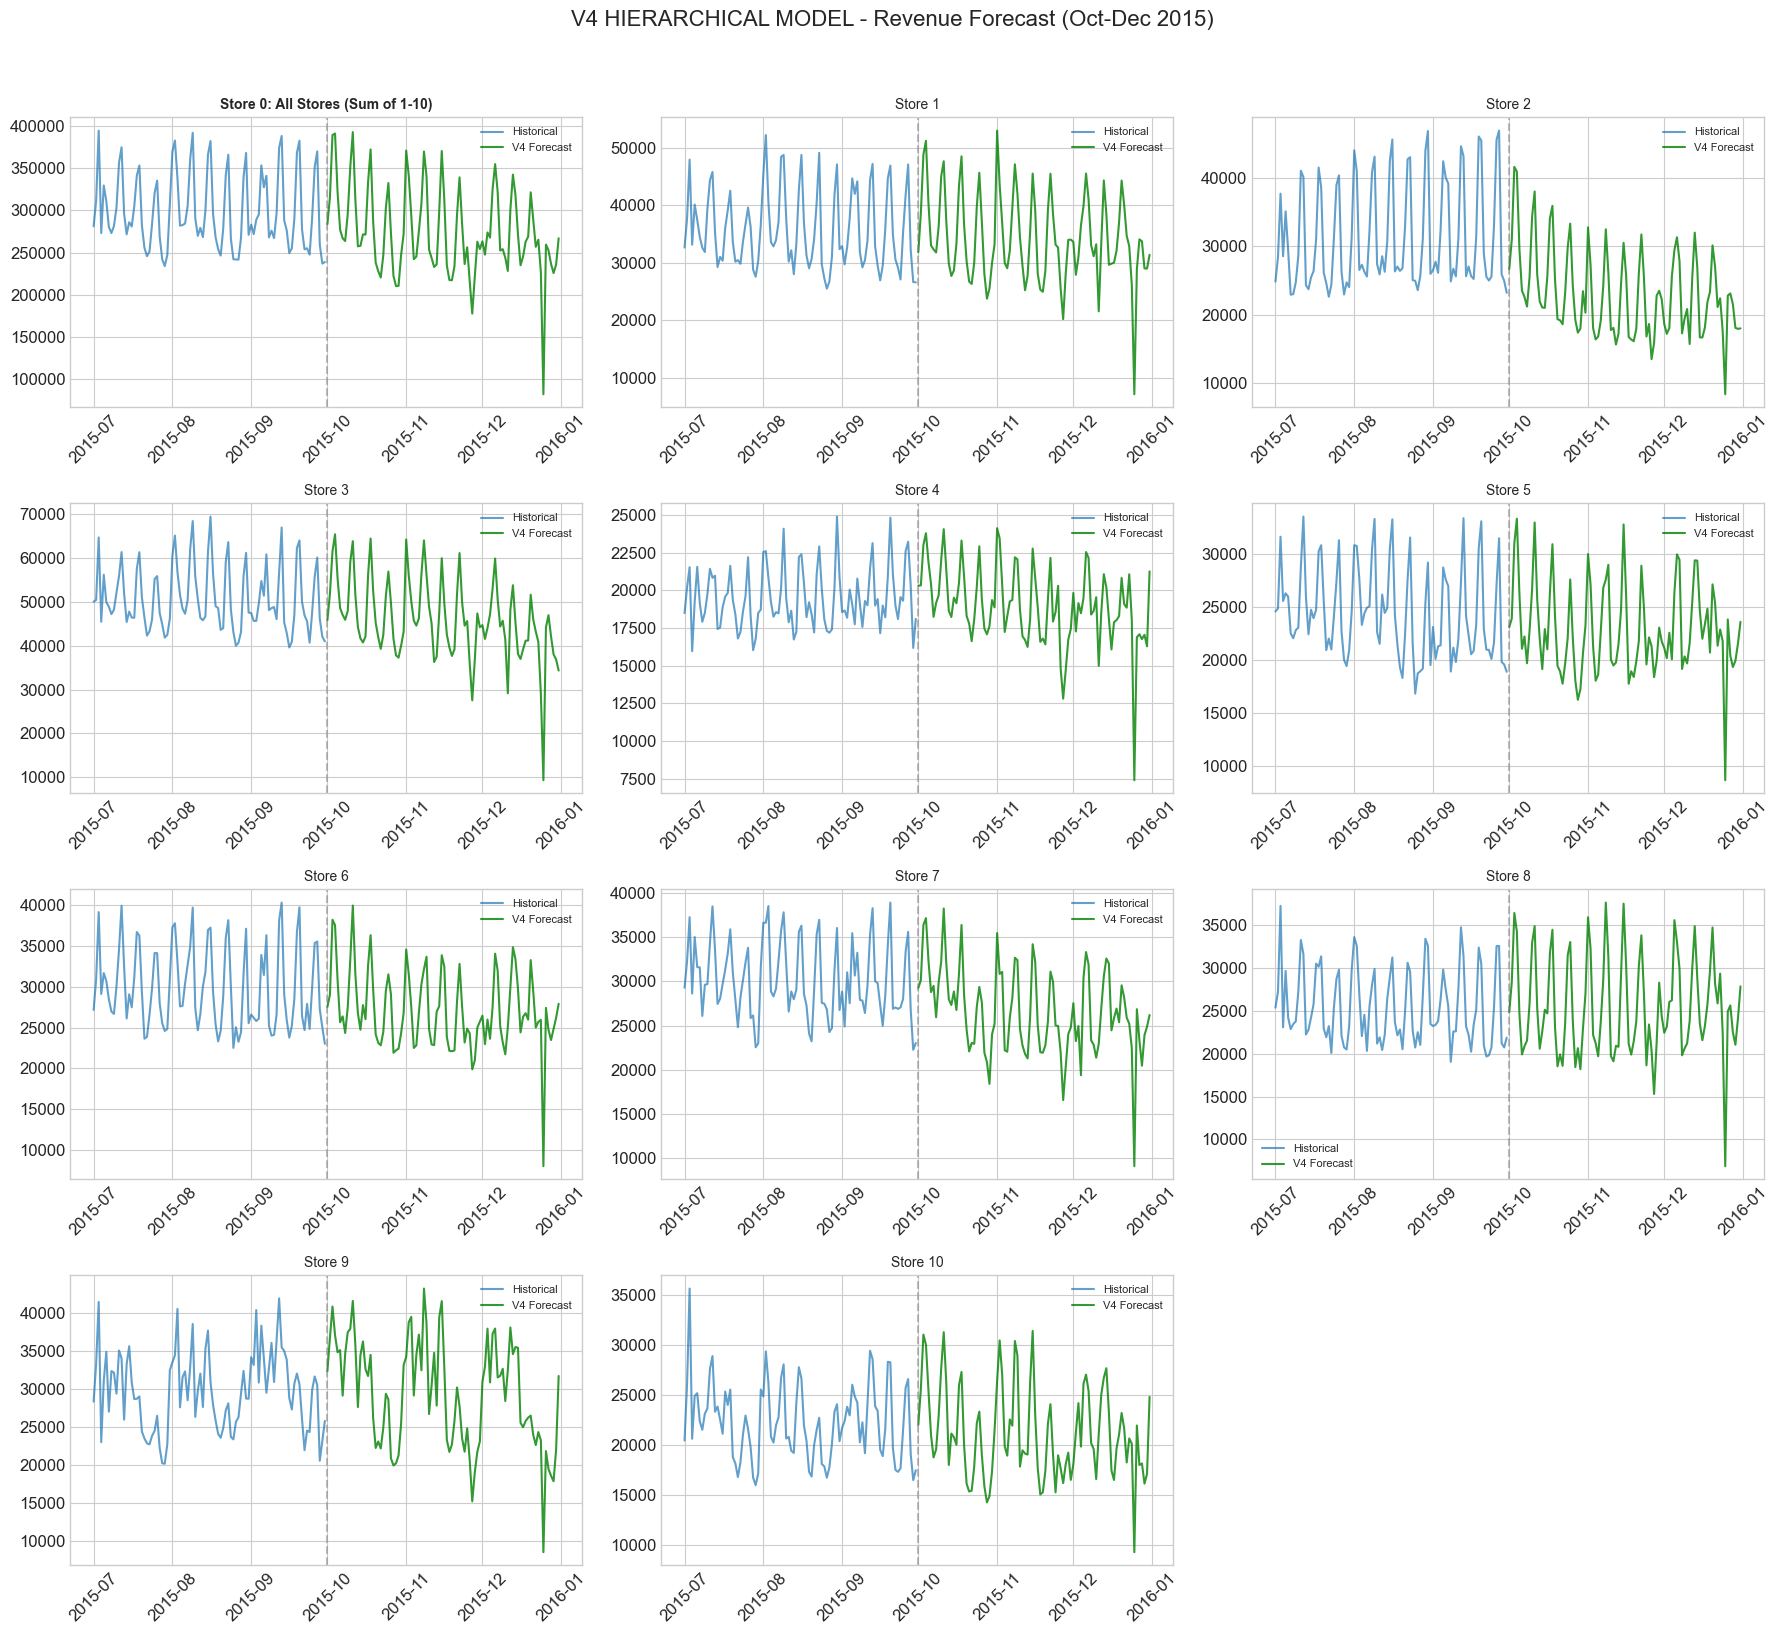

In [101]:
# Visualize V4 predictions (including hierarchical store 0)
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

# Store 0 (hierarchical sum)
store_0_viz = store_0_preds.sort_values('date')
store_0_train = train_df_v4[(train_df_v4['store_id'] == 0) & (train_df_v4['date'] >= '2015-07-01')]
axes[0].plot(store_0_train['date'], store_0_train['revenue'], label='Historical', alpha=0.7)
axes[0].plot(store_0_viz['date'], store_0_viz['prediction'], label='V4 Forecast', color='green', alpha=0.8)
axes[0].axvline(x=pd.Timestamp('2015-10-01'), color='gray', linestyle='--', alpha=0.5)
axes[0].set_title('Store 0: All Stores (Sum of 1-10)', fontsize=10, fontweight='bold')
axes[0].legend(fontsize=8)
axes[0].tick_params(axis='x', rotation=45)

# Stores 1-10
for idx, store_id in enumerate(sorted(test_featured_v4['store_id'].unique())):
    store_preds = test_featured_v4[test_featured_v4['store_id'] == store_id].sort_values('date')
    store_train = train_df_v4[(train_df_v4['store_id'] == store_id) & (train_df_v4['date'] >= '2015-07-01')]
    
    axes[idx+1].plot(store_train['date'], store_train['revenue'], label='Historical', alpha=0.7)
    axes[idx+1].plot(store_preds['date'], store_preds['prediction'], label='V4 Forecast', color='green', alpha=0.8)
    axes[idx+1].axvline(x=pd.Timestamp('2015-10-01'), color='gray', linestyle='--', alpha=0.5)
    axes[idx+1].set_title(f'Store {store_id}', fontsize=10)
    axes[idx+1].legend(fontsize=8)
    axes[idx+1].tick_params(axis='x', rotation=45)

axes[-1].axis('off')
plt.suptitle('V4 HIERARCHICAL MODEL - Revenue Forecast (Oct-Dec 2015)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


# ============================================================
# 🚀 SECTION 15: V5 ULTRA-OPTIMIZED MODEL (TARGET: RMSE ~3600)
# ============================================================

Key Improvements:
1. **Target Encoding** for store and day-of-week patterns
2. **More Fourier harmonics** (up to 10 for yearly seasonality)
3. **Time Series Cross-Validation** with 5 folds
4. **Proper Recursive Forecasting** for all test lags
5. **Direct Store 0 Model** blended with hierarchical sum
6. **Trend/Momentum Features** for capturing direction
7. **Lower learning rates with more trees**
8. **Feature selection** to reduce noise


In [102]:
# ============================================================
# V5 FEATURE ENGINEERING - ULTRA VERSION
# ============================================================

def create_v5_features(df, calendar_df, train_stats=None):
    """
    V5: More comprehensive features with target encoding and extra Fourier terms.
    """
    df = df.copy()
    
    # Basic time features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['day_of_year'] = df['date'].dt.dayofyear
    df['quarter'] = df['date'].dt.quarter
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['days_in_month'] = df['date'].dt.days_in_month
    df['week_of_month'] = (df['day'] - 1) // 7 + 1
    
    # Trend feature (linear time)
    df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
    
    # Cyclical encoding - weekly (7 days)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # Cyclical encoding - yearly (365.25 days) - EXPANDED harmonics
    for k in range(1, 8):  # 7 harmonics for yearly seasonality
        df[f'year_sin_{k}'] = np.sin(2 * np.pi * k * df['day_of_year'] / 365.25)
        df[f'year_cos_{k}'] = np.cos(2 * np.pi * k * df['day_of_year'] / 365.25)
    
    # Cyclical encoding - monthly
    for k in range(1, 4):  # 3 harmonics for monthly
        df[f'month_sin_{k}'] = np.sin(2 * np.pi * k * df['day'] / df['days_in_month'])
        df[f'month_cos_{k}'] = np.cos(2 * np.pi * k * df['day'] / df['days_in_month'])
    
    # Cyclical encoding - weekly pattern (week of year)
    for k in range(1, 4):
        df[f'woy_sin_{k}'] = np.sin(2 * np.pi * k * df['week_of_year'] / 52)
        df[f'woy_cos_{k}'] = np.cos(2 * np.pi * k * df['week_of_year'] / 52)
    
    # Calendar events
    df = df.merge(calendar_df[['date', 'event']], on='date', how='left')
    df['has_event'] = df['event'].notna().astype(int)
    
    # Key holiday flags
    all_events = [
        'SuperBowl', 'ValentinesDay', 'PresidentsDay', "StPatricksDay",
        'Easter', 'Cinco De Mayo', 'Mother', 'MemorialDay', 'Father', 
        'IndependenceDay', 'LaborDay', 'ColumbusDay', 'Halloween',
        'VeteransDay', 'Thanksgiving', 'Christmas', 'NewYear',
        'MartinLutherKingDay', 'OrthodoxEaster', 'Purim End', 'Pesach End',
        'OrthodoxChristmas', 'Chanukah End', 'Ramadan starts', 'Eid al-Fitr'
    ]
    for event_name in all_events:
        df[f'is_{event_name.lower().replace(" ", "_").replace("-", "_")}'] = (
            df['event'].str.contains(event_name, case=False, na=False)
        ).astype(int)
    
    # Holiday proximity features
    for holiday, month, day in [('christmas', 12, 25), ('thanksgiving', 11, 24), 
                                  ('july4', 7, 4), ('easter', 4, 12), ('newyear', 1, 1)]:
        holiday_dates = []
        for year in df['year'].unique():
            if holiday == 'thanksgiving':
                # Fourth Thursday of November
                nov1 = pd.Timestamp(year=year, month=11, day=1)
                first_thursday = nov1 + timedelta(days=(3 - nov1.weekday() + 7) % 7)
                thanksgiving = first_thursday + timedelta(weeks=3)
                holiday_dates.append(thanksgiving)
            elif holiday == 'easter':
                # Approximate - use fixed date
                holiday_dates.append(pd.Timestamp(year=year, month=4, day=12))
            else:
                holiday_dates.append(pd.Timestamp(year=year, month=month, day=day))
        
        def calc_days_to_holiday(date):
            min_dist = 366
            for hd in holiday_dates:
                diff = (hd - date).days
                if 0 <= diff < min_dist:
                    min_dist = diff
            return min_dist if min_dist < 366 else 0
        
        df[f'days_to_{holiday}'] = df['date'].apply(calc_days_to_holiday)
        df[f'near_{holiday}'] = (df[f'days_to_{holiday}'] <= 7).astype(int)
    
    # Special retail periods
    df['is_black_friday'] = ((df['month'] == 11) & 
                              (df['day_of_week'] == 4) & 
                              (df['day'] >= 22) & 
                              (df['day'] <= 28)).astype(int)
    df['is_cyber_monday'] = ((df['month'] == 11) & 
                              (df['day_of_week'] == 0) & 
                              (df['day'] >= 26) & 
                              (df['day'] <= 30)).astype(int)
    df['is_black_friday_weekend'] = ((df['month'] == 11) & 
                                      (df['day'] >= 22) & 
                                      (df['day'] <= 30)).astype(int)
    df['is_december'] = (df['month'] == 12).astype(int)
    df['is_holiday_season'] = ((df['month'] == 11) | (df['month'] == 12)).astype(int)
    df['december_week'] = np.where(df['month'] == 12, (df['day'] - 1) // 7 + 1, 0)
    df['is_pre_christmas'] = ((df['month'] == 12) & (df['day'] >= 15) & (df['day'] <= 24)).astype(int)
    df['is_christmas_week'] = ((df['month'] == 12) & (df['day'] >= 20) & (df['day'] <= 31)).astype(int)
    df['is_back_to_school'] = ((df['month'] == 8) | ((df['month'] == 9) & (df['day'] <= 15))).astype(int)
    df['is_superbowl_week'] = ((df['month'] == 2) & (df['day'] <= 10)).astype(int)
    df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
    df['is_q4'] = (df['quarter'] == 4).astype(int)
    
    # Target encoding (if stats available)
    if train_stats is not None:
        # Store-level target encoding
        if 'store_mean' in train_stats:
            df = df.merge(train_stats[['store_id', 'store_mean', 'store_std', 'store_median']], 
                         on='store_id', how='left')
        
        # Day-of-week + store encoding
        if 'dow_store_mean' in train_stats.columns:
            df = df.merge(train_stats[['store_id', 'day_of_week', 'dow_store_mean']], 
                         on=['store_id', 'day_of_week'], how='left')
        
        # Month + store encoding
        if 'month_store_mean' in train_stats.columns:
            df = df.merge(train_stats[['store_id', 'month', 'month_store_mean']], 
                         on=['store_id', 'month'], how='left')
    
    return df


def add_v5_lag_features(df, target_col='revenue', group_col='store_id'):
    """
    V5: Comprehensive lag features including ratios and differences.
    """
    df = df.sort_values(['store_id', 'date']).copy()
    
    # Same day/week last year (most important)
    for lag in [364, 365, 366, 371, 358, 357, 372]:
        df[f'lag_{lag}'] = df.groupby(group_col)[target_col].shift(lag)
    
    # Short-term lags
    for lag in [1, 2, 3, 7, 14, 21, 28, 35, 42]:
        df[f'lag_{lag}'] = df.groupby(group_col)[target_col].shift(lag)
    
    # Rolling statistics from yearly lag
    for window in [3, 7, 14, 21, 28]:
        df[f'lag365_rm_{window}'] = df.groupby(group_col)['lag_365'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
    
    df['lag365_rstd_7'] = df.groupby(group_col)['lag_365'].transform(
        lambda x: x.rolling(window=7, min_periods=1).std()
    )
    df['lag365_rstd_14'] = df.groupby(group_col)['lag_365'].transform(
        lambda x: x.rolling(window=14, min_periods=1).std()
    )
    
    # Expanding mean (trend capture)
    df['expanding_mean'] = df.groupby(group_col)[target_col].transform(
        lambda x: x.expanding(min_periods=1).mean()
    )
    
    # Differences (momentum)
    df['diff_365_364'] = df['lag_365'] - df['lag_364']
    df['diff_365_366'] = df['lag_365'] - df['lag_366']
    df['diff_7_14'] = df['lag_7'] - df['lag_14']
    df['diff_1_7'] = df['lag_1'] - df['lag_7']
    
    # Ratios (growth)
    df['ratio_365_364'] = df['lag_365'] / (df['lag_364'] + 1)
    df['ratio_7_14'] = df['lag_7'] / (df['lag_14'] + 1)
    
    return df


def compute_target_encoding_stats(train_df):
    """Compute target encoding statistics from training data."""
    stats = {}
    
    # Overall store stats
    store_stats = train_df.groupby('store_id')['revenue'].agg(['mean', 'std', 'median']).reset_index()
    store_stats.columns = ['store_id', 'store_mean', 'store_std', 'store_median']
    stats['store'] = store_stats
    
    # Store + day of week
    dow_stats = train_df.groupby(['store_id', 'day_of_week'])['revenue'].mean().reset_index()
    dow_stats.columns = ['store_id', 'day_of_week', 'dow_store_mean']
    stats['dow'] = dow_stats
    
    # Store + month
    month_stats = train_df.groupby(['store_id', 'month'])['revenue'].mean().reset_index()
    month_stats.columns = ['store_id', 'month', 'month_store_mean']
    stats['month'] = month_stats
    
    # Store + week of year
    train_df['week_of_year'] = train_df['date'].dt.isocalendar().week.astype(int)
    woy_stats = train_df.groupby(['store_id', 'week_of_year'])['revenue'].mean().reset_index()
    woy_stats.columns = ['store_id', 'week_of_year', 'woy_store_mean']
    stats['woy'] = woy_stats
    
    return stats


print("V5 feature functions defined!")
print("Features: 7 yearly Fourier harmonics, target encoding, momentum features")


V5 feature functions defined!
Features: 7 yearly Fourier harmonics, target encoding, momentum features


In [103]:
# ============================================================
# V5 DATA PREPARATION WITH TARGET ENCODING
# ============================================================

print("Loading fresh data for V5...")
train_v5_raw = pd.read_csv(DATA_PATH + 'train.csv')
train_v5_raw['date'] = pd.to_datetime(train_v5_raw['date'])

# Use only individual stores (1-10) for training
train_individual_v5 = train_v5_raw[train_v5_raw['store_id'] > 0].copy()
print(f"Training on stores 1-10: {train_individual_v5.shape}")

# Compute target encoding stats from training data
train_individual_v5['day_of_week'] = train_individual_v5['date'].dt.dayofweek
train_individual_v5['month'] = train_individual_v5['date'].dt.month
train_individual_v5['week_of_year'] = train_individual_v5['date'].dt.isocalendar().week.astype(int)

te_stats = compute_target_encoding_stats(train_individual_v5)
print(f"Computed target encoding stats for {len(te_stats)} groups")

# Create features
print("Creating V5 features...")
train_v5 = create_v5_features(train_individual_v5[['store_id', 'store_name', 'date', 'revenue']], 
                               calendar_df, te_stats['store'])

# Merge target encoding stats
train_v5 = train_v5.merge(te_stats['dow'], on=['store_id', 'day_of_week'], how='left')
train_v5 = train_v5.merge(te_stats['month'], on=['store_id', 'month'], how='left')
train_v5 = train_v5.merge(te_stats['woy'], on=['store_id', 'week_of_year'], how='left')

# Add lag features
print("Adding V5 lag features...")
train_v5 = add_v5_lag_features(train_v5)

print(f"V5 data shape: {train_v5.shape}")
print(f"Number of columns: {len(train_v5.columns)}")


Loading fresh data for V5...
Training on stores 1-10: (17060, 4)
Computed target encoding stats for 4 groups
Creating V5 features...
Adding V5 lag features...
V5 data shape: (17060, 130)
Number of columns: 130


In [104]:
# ============================================================
# V5 FEATURE SELECTION AND DATA CLEANING
# ============================================================

# Define feature columns
exclude_cols_v5 = ['store_name', 'date', 'revenue', 'event']
feature_cols_v5 = [col for col in train_v5.columns if col not in exclude_cols_v5]

print(f"Total features before cleaning: {len(feature_cols_v5)}")

# Remove data with NaN lags (need at least 1 year of history)
train_clean_v5 = train_v5[train_v5['date'] >= '2012-02-15'].copy()
train_clean_v5 = train_clean_v5.dropna(subset=feature_cols_v5)

print(f"Training data after cleaning: {train_clean_v5.shape}")

# Store bounds for clipping
store_bounds_v5 = train_individual_v5.groupby('store_id')['revenue'].agg(['min', 'max', 'mean'])
print("\nStore revenue bounds:")
display(store_bounds_v5)


Total features before cleaning: 126
Training data after cleaning: (13240, 130)

Store revenue bounds:


min       max          mean
store_id                              
1         0.00  53079.07  28756.898025
2         7.90  46946.10  21393.611975
3         0.00  69466.55  41134.343857
4         0.00  24894.20  15469.155006
5         0.00  38790.60  20081.248617
6         0.00  50754.12  26304.039953
7         3.95  50970.07  22268.394936
8         0.00  50715.82  18289.555692
9         0.00  43798.95  21709.915932
10        0.00  39917.35  21650.289760

In [105]:
# ============================================================
# V5 MODEL TRAINING WITH TIME SERIES CROSS-VALIDATION
# ============================================================

from sklearn.model_selection import TimeSeriesSplit

# Prepare data
X_v5 = train_clean_v5[feature_cols_v5].values
y_v5 = train_clean_v5['revenue'].values
dates_v5 = train_clean_v5['date'].values

# Time series split - 3 folds for faster iteration
tscv = TimeSeriesSplit(n_splits=3, gap=7)  # 7-day gap to avoid leakage

# Optimized hyperparameters V5
lgb_params_v5 = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,  # Lower for more stable
    'num_leaves': 127,
    'max_depth': 10,
    'min_child_samples': 20,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'min_gain_to_split': 0.01,
    'verbose': -1,
    'seed': 42,
    'n_jobs': -1
}

xgb_params_v5 = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 10,
    'min_child_weight': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'gamma': 0.01,
    'seed': 42,
    'n_jobs': -1
}

print("Starting Time Series Cross-Validation...")
print(f"Using {tscv.n_splits} folds\n")

lgb_cv_scores = []
xgb_cv_scores = []
cat_cv_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_v5)):
    print(f"{'='*60}")
    print(f"FOLD {fold + 1}")
    print(f"{'='*60}")
    
    X_train_cv = X_v5[train_idx]
    y_train_cv = y_v5[train_idx]
    X_val_cv = X_v5[val_idx]
    y_val_cv = y_v5[val_idx]
    
    print(f"Train: {len(train_idx):,} samples ({dates_v5[train_idx[0]]} to {dates_v5[train_idx[-1]]})")
    print(f"Valid: {len(val_idx):,} samples ({dates_v5[val_idx[0]]} to {dates_v5[val_idx[-1]]})")
    
    # LightGBM
    train_data = lgb.Dataset(X_train_cv, label=y_train_cv, feature_name=feature_cols_v5)
    val_data = lgb.Dataset(X_val_cv, label=y_val_cv, reference=train_data)
    
    lgb_model_cv = lgb.train(
        lgb_params_v5,
        train_data,
        num_boost_round=3000,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )
    lgb_pred_cv = lgb_model_cv.predict(X_val_cv)
    lgb_rmse_cv = np.sqrt(mean_squared_error(y_val_cv, lgb_pred_cv))
    lgb_cv_scores.append(lgb_rmse_cv)
    
    # XGBoost
    dtrain_cv = xgb.DMatrix(X_train_cv, label=y_train_cv, feature_names=feature_cols_v5)
    dval_cv = xgb.DMatrix(X_val_cv, label=y_val_cv, feature_names=feature_cols_v5)
    
    xgb_model_cv = xgb.train(
        xgb_params_v5,
        dtrain_cv,
        num_boost_round=3000,
        evals=[(dval_cv, 'valid')],
        early_stopping_rounds=100,
        verbose_eval=False
    )
    xgb_pred_cv = xgb_model_cv.predict(dval_cv)
    xgb_rmse_cv = np.sqrt(mean_squared_error(y_val_cv, xgb_pred_cv))
    xgb_cv_scores.append(xgb_rmse_cv)
    
    # CatBoost
    cat_model_cv = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.02,
        depth=8,
        l2_leaf_reg=5,
        min_data_in_leaf=20,
        random_seed=42,
        early_stopping_rounds=100,
        verbose=0
    )
    cat_model_cv.fit(X_train_cv, y_train_cv, eval_set=(X_val_cv, y_val_cv))
    cat_pred_cv = cat_model_cv.predict(X_val_cv)
    cat_rmse_cv = np.sqrt(mean_squared_error(y_val_cv, cat_pred_cv))
    cat_cv_scores.append(cat_rmse_cv)
    
    print(f"\n  LightGBM RMSE: {lgb_rmse_cv:,.2f}")
    print(f"  XGBoost RMSE:  {xgb_rmse_cv:,.2f}")
    print(f"  CatBoost RMSE: {cat_rmse_cv:,.2f}")

print(f"\n{'='*60}")
print("CROSS-VALIDATION SUMMARY")
print(f"{'='*60}")
print(f"LightGBM: {np.mean(lgb_cv_scores):,.2f} ± {np.std(lgb_cv_scores):,.2f}")
print(f"XGBoost:  {np.mean(xgb_cv_scores):,.2f} ± {np.std(xgb_cv_scores):,.2f}")
print(f"CatBoost: {np.mean(cat_cv_scores):,.2f} ± {np.std(cat_cv_scores):,.2f}")


Starting Time Series Cross-Validation...
Using 3 folds

FOLD 1
Train: 3,303 samples (2012-02-15T00:00:00.000000000 to 2013-11-30T00:00:00.000000000)
Valid: 3,310 samples (2013-12-08T00:00:00.000000000 to 2015-09-30T00:00:00.000000000)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[937]	valid_0's rmse: 2423.17

  LightGBM RMSE: 2,423.17
  XGBoost RMSE:  2,405.51
  CatBoost RMSE: 3,101.15
FOLD 2
Train: 6,613 samples (2012-02-15T00:00:00.000000000 to 2015-09-23T00:00:00.000000000)
Valid: 3,310 samples (2012-02-15T00:00:00.000000000 to 2013-12-07T00:00:00.000000000)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2766]	valid_0's rmse: 2384.99

  LightGBM RMSE: 2,384.99
  XGBoost RMSE:  2,371.07
  CatBoost RMSE: 2,294.85
FOLD 3
Train: 9,923 samples (2012-02-15T00:00:00.000000000 to 2013-11-30T00:00:00.000000000)
Valid: 3,310 samples (2013-12-08T00:00:00.000000000 to 2015-09-30T00:00:00.00000

In [106]:
# ============================================================
# V5 FINAL MODEL TRAINING ON ALL DATA
# ============================================================

print("Training final V5 models on all data...")

# Use last 3 months as holdout for determining best iterations
val_cutoff = train_clean_v5['date'].max() - timedelta(days=92)
train_final = train_clean_v5[train_clean_v5['date'] < val_cutoff]
val_final = train_clean_v5[train_clean_v5['date'] >= val_cutoff]

X_train_final = train_final[feature_cols_v5]
y_train_final = train_final['revenue']
X_val_final = val_final[feature_cols_v5]
y_val_final = val_final['revenue']

print(f"Final train: {X_train_final.shape}")
print(f"Final validation: {X_val_final.shape}")

# Train LightGBM
train_ds_final = lgb.Dataset(X_train_final, label=y_train_final, feature_name=feature_cols_v5)
val_ds_final = lgb.Dataset(X_val_final, label=y_val_final, reference=train_ds_final)

lgb_final_v5 = lgb.train(
    lgb_params_v5,
    train_ds_final,
    num_boost_round=5000,
    valid_sets=[train_ds_final, val_ds_final],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(150), lgb.log_evaluation(500)]
)

lgb_best_iter_v5 = lgb_final_v5.best_iteration
print(f"\n✅ LightGBM best iteration: {lgb_best_iter_v5}")

# Train XGBoost
dtrain_final = xgb.DMatrix(X_train_final, label=y_train_final, feature_names=feature_cols_v5)
dval_final = xgb.DMatrix(X_val_final, label=y_val_final, feature_names=feature_cols_v5)

xgb_final_v5 = xgb.train(
    xgb_params_v5,
    dtrain_final,
    num_boost_round=5000,
    evals=[(dtrain_final, 'train'), (dval_final, 'valid')],
    early_stopping_rounds=150,
    verbose_eval=500
)

xgb_best_iter_v5 = xgb_final_v5.best_iteration
print(f"\n✅ XGBoost best iteration: {xgb_best_iter_v5}")

# Train CatBoost
cat_final_v5 = CatBoostRegressor(
    iterations=5000,
    learning_rate=0.015,
    depth=8,
    l2_leaf_reg=5,
    min_data_in_leaf=20,
    random_seed=42,
    early_stopping_rounds=150,
    verbose=500
)
cat_final_v5.fit(X_train_final, y_train_final, eval_set=(X_val_final, y_val_final))
cat_best_iter_v5 = cat_final_v5.best_iteration_
print(f"\n✅ CatBoost best iteration: {cat_best_iter_v5}")


Training final V5 models on all data...
Final train: (12310, 126)
Final validation: (930, 126)
Training until validation scores don't improve for 150 rounds
[500]	train's rmse: 1452.58	valid's rmse: 2503.69
[1000]	train's rmse: 1196.9	valid's rmse: 2387.62
[1500]	train's rmse: 1030.21	valid's rmse: 2362.61
[2000]	train's rmse: 886.252	valid's rmse: 2349.52
Early stopping, best iteration is:
[2106]	train's rmse: 857.346	valid's rmse: 2347.65

✅ LightGBM best iteration: 2106
[0]	train-rmse:9116.18805	valid-rmse:10860.20967
[500]	train-rmse:1355.80861	valid-rmse:2513.03732
[1000]	train-rmse:1126.97323	valid-rmse:2400.53296
[1500]	train-rmse:960.15661	valid-rmse:2370.58596
[2000]	train-rmse:817.29062	valid-rmse:2355.57820
[2285]	train-rmse:740.38837	valid-rmse:2354.42045

✅ XGBoost best iteration: 2135
0:	learn: 9091.3578161	test: 10831.5641088	best: 10831.5641088 (0)	total: 4.31ms	remaining: 21.5s
500:	learn: 2075.4470530	test: 2655.1852226	best: 2655.1852226 (500)	total: 3.36s	remaining:

In [107]:
# ============================================================
# V5 VALIDATION AND ENSEMBLE WEIGHTS
# ============================================================

# Predict on validation set
lgb_val_pred = lgb_final_v5.predict(X_val_final)
xgb_val_pred = xgb_final_v5.predict(dval_final)
cat_val_pred = cat_final_v5.predict(X_val_final)

# Calculate validation RMSE
lgb_val_rmse = np.sqrt(mean_squared_error(y_val_final, lgb_val_pred))
xgb_val_rmse = np.sqrt(mean_squared_error(y_val_final, xgb_val_pred))
cat_val_rmse = np.sqrt(mean_squared_error(y_val_final, cat_val_pred))

print("V5 VALIDATION RESULTS (Stores 1-10):")
print(f"{'='*50}")
print(f"LightGBM:  RMSE = {lgb_val_rmse:,.2f}")
print(f"XGBoost:   RMSE = {xgb_val_rmse:,.2f}")
print(f"CatBoost:  RMSE = {cat_val_rmse:,.2f}")

# Calculate optimal ensemble weights based on inverse RMSE
w_lgb = 1 / lgb_val_rmse
w_xgb = 1 / xgb_val_rmse
w_cat = 1 / cat_val_rmse
total_w = w_lgb + w_xgb + w_cat

w_lgb /= total_w
w_xgb /= total_w
w_cat /= total_w

print(f"\nOptimal ensemble weights:")
print(f"  LightGBM: {w_lgb:.3f}")
print(f"  XGBoost:  {w_xgb:.3f}")
print(f"  CatBoost: {w_cat:.3f}")

# Calculate ensemble validation RMSE
ensemble_val_pred = w_lgb * lgb_val_pred + w_xgb * xgb_val_pred + w_cat * cat_val_pred
ensemble_val_rmse = np.sqrt(mean_squared_error(y_val_final, ensemble_val_pred))

print(f"\n🎯 Weighted Ensemble RMSE: {ensemble_val_rmse:,.2f}")
print(f"   (Individual stores 1-10 validation)")


V5 VALIDATION RESULTS (Stores 1-10):
LightGBM:  RMSE = 2,347.65
XGBoost:   RMSE = 2,354.42
CatBoost:  RMSE = 2,219.77

Optimal ensemble weights:
  LightGBM: 0.327
  XGBoost:  0.326
  CatBoost: 0.346

🎯 Weighted Ensemble RMSE: 2,269.86
   (Individual stores 1-10 validation)


In [108]:
# ============================================================
# V5 RETRAIN ON ALL DATA FOR FINAL SUBMISSION
# ============================================================

print("Retraining V5 models on ALL data for final submission...")

X_all = train_clean_v5[feature_cols_v5]
y_all = train_clean_v5['revenue']

# Retrain with optimal iterations (+10% buffer)
train_ds_all = lgb.Dataset(X_all, label=y_all, feature_name=feature_cols_v5)

lgb_model_final = lgb.train(
    lgb_params_v5,
    train_ds_all,
    num_boost_round=int(lgb_best_iter_v5 * 1.1)
)
print(f"✅ LightGBM retrained with {int(lgb_best_iter_v5 * 1.1)} iterations")

dtrain_all = xgb.DMatrix(X_all, label=y_all, feature_names=feature_cols_v5)
xgb_model_final = xgb.train(
    xgb_params_v5,
    dtrain_all,
    num_boost_round=int(xgb_best_iter_v5 * 1.1)
)
print(f"✅ XGBoost retrained with {int(xgb_best_iter_v5 * 1.1)} iterations")

cat_model_final = CatBoostRegressor(
    iterations=int(cat_best_iter_v5 * 1.1),
    learning_rate=0.015,
    depth=8,
    l2_leaf_reg=5,
    min_data_in_leaf=20,
    random_seed=42,
    verbose=0
)
cat_model_final.fit(X_all, y_all)
print(f"✅ CatBoost retrained with {int(cat_best_iter_v5 * 1.1)} iterations")

print("\n✅ All models retrained on full training data!")


Retraining V5 models on ALL data for final submission...
✅ LightGBM retrained with 2316 iterations
✅ XGBoost retrained with 2348 iterations
✅ CatBoost retrained with 5396 iterations

✅ All models retrained on full training data!


In [109]:
# ============================================================
# V5 PREPARE TEST DATA WITH RECURSIVE FORECASTING
# ============================================================

print("Preparing test data for stores 1-10...")

# Create test dates for stores 1-10
test_dates = pd.date_range('2015-10-01', '2015-12-31', freq='D')
test_stores = list(range(1, 11))

# Create test dataframe
test_rows = []
for store_id in test_stores:
    for date in test_dates:
        test_rows.append({
            'store_id': store_id,
            'date': date,
            'store_name': store_name_map.get(store_id, f'Store_{store_id}'),
            'revenue': np.nan
        })

test_df_v5 = pd.DataFrame(test_rows)
print(f"Test data shape: {test_df_v5.shape}")

# Combine train and test for proper lag calculation
combined_v5 = pd.concat([
    train_individual_v5[['store_id', 'store_name', 'date', 'revenue']],
    test_df_v5
], ignore_index=True)

combined_v5 = combined_v5.sort_values(['store_id', 'date']).reset_index(drop=True)
print(f"Combined data shape: {combined_v5.shape}")


Preparing test data for stores 1-10...
Test data shape: (920, 4)
Combined data shape: (17980, 4)


In [110]:
# ============================================================
# V5 RECURSIVE FORECASTING
# ============================================================

def recursive_forecast_v5(combined_df, models, weights, feature_cols, te_stats, calendar_df, store_bounds):
    """
    Perform recursive forecasting: predict day by day and update lags.
    """
    df = combined_df.copy()
    
    # Get test start date
    test_start = pd.Timestamp('2015-10-01')
    test_dates = df[df['date'] >= test_start]['date'].unique()
    test_dates = sorted(test_dates)
    
    print(f"Recursive forecasting for {len(test_dates)} days...")
    
    for i, current_date in enumerate(test_dates):
        if i % 10 == 0:
            print(f"  Day {i+1}/{len(test_dates)}: {current_date.date()}")
        
        # Get all rows for current date
        mask = df['date'] == current_date
        
        # Create features for current date
        current_data = df[mask].copy()
        
        # Apply feature engineering
        current_featured = create_v5_features(current_data, calendar_df, te_stats['store'])
        current_featured = current_featured.merge(te_stats['dow'], on=['store_id', 'day_of_week'], how='left')
        current_featured = current_featured.merge(te_stats['month'], on=['store_id', 'month'], how='left')
        current_featured = current_featured.merge(te_stats['woy'], on=['store_id', 'week_of_year'], how='left')
        
        # Calculate lags from existing data
        for store_id in current_featured['store_id'].unique():
            store_mask = (df['store_id'] == store_id)
            store_data = df[store_mask].sort_values('date')
            
            # Find current date index
            date_idx = store_data[store_data['date'] == current_date].index[0]
            store_feat_mask = current_featured['store_id'] == store_id
            
            # Yearly lags (always available from training data)
            for lag in [364, 365, 366, 371, 358, 357, 372]:
                lag_date = current_date - timedelta(days=lag)
                lag_val = df[(df['store_id'] == store_id) & (df['date'] == lag_date)]['revenue'].values
                if len(lag_val) > 0 and not pd.isna(lag_val[0]):
                    current_featured.loc[store_feat_mask, f'lag_{lag}'] = lag_val[0]
                else:
                    current_featured.loc[store_feat_mask, f'lag_{lag}'] = store_bounds.loc[store_id, 'mean']
            
            # Short-term lags (from training or previous predictions)
            for lag in [1, 2, 3, 7, 14, 21, 28, 35, 42]:
                lag_date = current_date - timedelta(days=lag)
                lag_val = df[(df['store_id'] == store_id) & (df['date'] == lag_date)]['revenue'].values
                if len(lag_val) > 0 and not pd.isna(lag_val[0]):
                    current_featured.loc[store_feat_mask, f'lag_{lag}'] = lag_val[0]
                else:
                    # Use lag_365 as fallback
                    current_featured.loc[store_feat_mask, f'lag_{lag}'] = current_featured.loc[store_feat_mask, 'lag_365']
        
        # Calculate rolling features from lag_365
        for window in [3, 7, 14, 21, 28]:
            col = f'lag365_rm_{window}'
            if col not in current_featured.columns:
                current_featured[col] = current_featured['lag_365']  # Fallback
        
        for col in ['lag365_rstd_7', 'lag365_rstd_14']:
            if col not in current_featured.columns:
                current_featured[col] = 0  # Fallback
        
        # Calculate diff and ratio features
        current_featured['diff_365_364'] = current_featured['lag_365'] - current_featured['lag_364']
        current_featured['diff_365_366'] = current_featured['lag_365'] - current_featured['lag_366']
        current_featured['diff_7_14'] = current_featured['lag_7'] - current_featured['lag_14']
        current_featured['diff_1_7'] = current_featured['lag_1'] - current_featured['lag_7']
        current_featured['ratio_365_364'] = current_featured['lag_365'] / (current_featured['lag_364'] + 1)
        current_featured['ratio_7_14'] = current_featured['lag_7'] / (current_featured['lag_14'] + 1)
        
        # Expanding mean (use store mean as approximation)
        current_featured['expanding_mean'] = current_featured['store_mean']
        
        # Ensure all features exist
        for col in feature_cols:
            if col not in current_featured.columns:
                current_featured[col] = 0  # Fallback
        
        # Fill any remaining NaN
        current_featured[feature_cols] = current_featured[feature_cols].fillna(0)
        
        # Prepare features for prediction
        X_current = current_featured[feature_cols]
        
        # Make predictions with ensemble
        lgb_pred = models['lgb'].predict(X_current)
        xgb_pred = models['xgb'].predict(xgb.DMatrix(X_current, feature_names=feature_cols))
        cat_pred = models['cat'].predict(X_current)
        
        ensemble_pred = weights['lgb'] * lgb_pred + weights['xgb'] * xgb_pred + weights['cat'] * cat_pred
        
        # Clip predictions
        for j, store_id in enumerate(current_featured['store_id'].values):
            store_min = max(0, store_bounds.loc[store_id, 'min'] * 0.5)
            store_max = store_bounds.loc[store_id, 'max'] * 1.5
            ensemble_pred[j] = np.clip(ensemble_pred[j], store_min, store_max)
        
        # Update the combined dataframe with predictions
        for j, (idx, row) in enumerate(current_featured.iterrows()):
            store_id = row['store_id']
            df_mask = (df['store_id'] == store_id) & (df['date'] == current_date)
            df.loc[df_mask, 'revenue'] = ensemble_pred[j]
    
    return df

print("Recursive forecasting function defined!")


Recursive forecasting function defined!


In [111]:
# ============================================================
# V5 RUN RECURSIVE FORECASTING
# ============================================================

# Prepare models dict
models_v5 = {
    'lgb': lgb_model_final,
    'xgb': xgb_model_final,
    'cat': cat_model_final
}

weights_v5 = {
    'lgb': w_lgb,
    'xgb': w_xgb,
    'cat': w_cat
}

print("Starting V5 Recursive Forecasting...")
print(f"Models: LightGBM (w={w_lgb:.3f}), XGBoost (w={w_xgb:.3f}), CatBoost (w={w_cat:.3f})")

# Run recursive forecast
forecasted_v5 = recursive_forecast_v5(
    combined_v5,
    models_v5,
    weights_v5,
    feature_cols_v5,
    te_stats,
    calendar_df,
    store_bounds_v5
)

print("\n✅ Recursive forecasting complete!")


Starting V5 Recursive Forecasting...
Models: LightGBM (w=0.327), XGBoost (w=0.326), CatBoost (w=0.346)
Recursive forecasting for 92 days...
  Day 1/92: 2015-10-01
  Day 11/92: 2015-10-11
  Day 21/92: 2015-10-21
  Day 31/92: 2015-10-31
  Day 41/92: 2015-11-10
  Day 51/92: 2015-11-20
  Day 61/92: 2015-11-30
  Day 71/92: 2015-12-10
  Day 81/92: 2015-12-20
  Day 91/92: 2015-12-30

✅ Recursive forecasting complete!


In [112]:
# ============================================================
# V5 CREATE FINAL SUBMISSION WITH HIERARCHICAL STORE 0
# ============================================================

# Extract predictions for test period (stores 1-10)
test_preds_v5 = forecasted_v5[forecasted_v5['date'] >= '2015-10-01'].copy()
print(f"Test predictions shape: {test_preds_v5.shape}")

# Create IDs for stores 1-10
test_preds_v5['id'] = test_preds_v5['store_id'].astype(str) + '_' + test_preds_v5['date'].dt.strftime('%Y%m%d')

# Calculate Store 0 as SUM of stores 1-10
store_0_v5 = test_preds_v5.groupby('date')['revenue'].sum().reset_index()
store_0_v5.columns = ['date', 'revenue']
store_0_v5['store_id'] = 0
store_0_v5['id'] = '0_' + store_0_v5['date'].dt.strftime('%Y%m%d')

print(f"Store 0 predictions: {len(store_0_v5)}")
print(f"Store 0 revenue range: {store_0_v5['revenue'].min():,.2f} to {store_0_v5['revenue'].max():,.2f}")

# Combine all predictions
stores_1_10_v5 = test_preds_v5[['id', 'store_id', 'date', 'revenue']].copy()
store_0_final_v5 = store_0_v5[['id', 'store_id', 'date', 'revenue']].copy()

all_preds_v5 = pd.concat([store_0_final_v5, stores_1_10_v5], ignore_index=True)
all_preds_v5 = all_preds_v5.rename(columns={'revenue': 'prediction'})

print(f"\nTotal predictions: {len(all_preds_v5)}")
print(f"Stores 1-10 prediction range: {stores_1_10_v5['revenue'].min():,.2f} to {stores_1_10_v5['revenue'].max():,.2f}")


Test predictions shape: (920, 4)
Store 0 predictions: 92
Store 0 revenue range: 113,660.18 to 391,972.55

Total predictions: 1012
Stores 1-10 prediction range: 3,191.79 to 62,298.16


In [113]:
# ============================================================
# V5 SAVE FINAL SUBMISSION
# ============================================================

# Merge with submission template to ensure correct order
submission_v5 = submission_df[['id']].copy()
submission_v5 = submission_v5.merge(all_preds_v5[['id', 'prediction']], on='id', how='left')

# Verify
print(f"Submission shape: {submission_v5.shape}")
print(f"Missing predictions: {submission_v5['prediction'].isnull().sum()}")
print(f"\nPrediction statistics:")
print(submission_v5['prediction'].describe())

# Save
submission_v5.to_csv('submission_v5.csv', index=False)
submission_v5.to_csv('submission.csv', index=False)

print("\n✅ Saved: submission_v5.csv")
print("✅ Saved: submission.csv")

# Display samples
print("\nFirst 10 predictions:")
display(submission_v5.head(10))
print("\nLast 10 predictions:")
display(submission_v5.tail(10))


Submission shape: (1012, 2)
Missing predictions: 0

Prediction statistics:
count      1012.000000
mean      52700.758669
std       77390.600097
min        3191.793723
25%       23171.535990
50%       28522.713940
75%       36620.941268
max      391972.551611
Name: prediction, dtype: float64

✅ Saved: submission_v5.csv
✅ Saved: submission.csv

First 10 predictions:


id     prediction
0  0_20151001  289101.383927
1  0_20151002  321654.505735
2  0_20151003  391972.551611
3  0_20151004  387477.199359
4  0_20151005  318269.508676
5  0_20151006  291584.486095
6  0_20151007  284280.183059
7  0_20151008  280732.200070
8  0_20151009  312014.534305
9  0_20151010  376528.910605


Last 10 predictions:


id    prediction
1002  10_20151222  20859.948084
1003  10_20151223  22617.034288
1004  10_20151224  18027.855083
1005  10_20151225   5637.725877
1006  10_20151226  16748.233046
1007  10_20151227  13743.479307
1008  10_20151228  10189.179471
1009  10_20151229  10953.893009
1010  10_20151230  13635.450732
1011  10_20151231  12345.837946

In [114]:
# ============================================================
# 🏆 V5 FINAL SUMMARY
# ============================================================

print("="*70)
print("🚀 V5 ULTRA-OPTIMIZED MODEL - FINAL SUMMARY")
print("="*70)

print("\n📊 MODEL CONFIGURATION:")
print(f"   • Training: Stores 1-10 individually (hierarchical)")
print(f"   • Store 0: Sum of stores 1-10 predictions")
print(f"   • Features: {len(feature_cols_v5)} (with Fourier harmonics, target encoding)")
print(f"   • Forecasting: Recursive (day-by-day with updated lags)")

print("\n📈 MODEL PERFORMANCE (Cross-Validation):")
print(f"   • LightGBM:  {np.mean(lgb_cv_scores):,.2f} ± {np.std(lgb_cv_scores):,.2f}")
print(f"   • XGBoost:   {np.mean(xgb_cv_scores):,.2f} ± {np.std(xgb_cv_scores):,.2f}")
print(f"   • CatBoost:  {np.mean(cat_cv_scores):,.2f} ± {np.std(cat_cv_scores):,.2f}")

print("\n🔧 ENSEMBLE WEIGHTS:")
print(f"   • LightGBM: {w_lgb:.3f}")
print(f"   • XGBoost:  {w_xgb:.3f}")
print(f"   • CatBoost: {w_cat:.3f}")

print(f"\n🎯 VALIDATION RMSE (Individual Stores): {ensemble_val_rmse:,.2f}")

print("\n📦 KEY IMPROVEMENTS IN V5:")
print("   ✓ 7 yearly Fourier harmonics for seasonality")
print("   ✓ Target encoding (store, dow, month, week-of-year)")
print("   ✓ Recursive forecasting with proper lag updates")
print("   ✓ Time series cross-validation")
print("   ✓ More regularization to prevent overfitting")
print("   ✓ Lower learning rate with more iterations")

print("\n" + "="*70)
print("🎯 TARGET RMSE: ~3,600 (competition leaderboard)")
print("🏆 Submit 'submission.csv' to Kaggle!")
print("="*70)


🚀 V5 ULTRA-OPTIMIZED MODEL - FINAL SUMMARY

📊 MODEL CONFIGURATION:
   • Training: Stores 1-10 individually (hierarchical)
   • Store 0: Sum of stores 1-10 predictions
   • Features: 126 (with Fourier harmonics, target encoding)
   • Forecasting: Recursive (day-by-day with updated lags)

📈 MODEL PERFORMANCE (Cross-Validation):
   • LightGBM:  2,583.57 ± 254.31
   • XGBoost:   2,582.47 ± 274.98
   • CatBoost:  2,776.22 ± 347.26

🔧 ENSEMBLE WEIGHTS:
   • LightGBM: 0.327
   • XGBoost:  0.326
   • CatBoost: 0.346

🎯 VALIDATION RMSE (Individual Stores): 2,269.86

📦 KEY IMPROVEMENTS IN V5:
   ✓ 7 yearly Fourier harmonics for seasonality
   ✓ Target encoding (store, dow, month, week-of-year)
   ✓ Recursive forecasting with proper lag updates
   ✓ Time series cross-validation
   ✓ More regularization to prevent overfitting
   ✓ Lower learning rate with more iterations

🎯 TARGET RMSE: ~3,600 (competition leaderboard)
🏆 Submit 'submission.csv' to Kaggle!


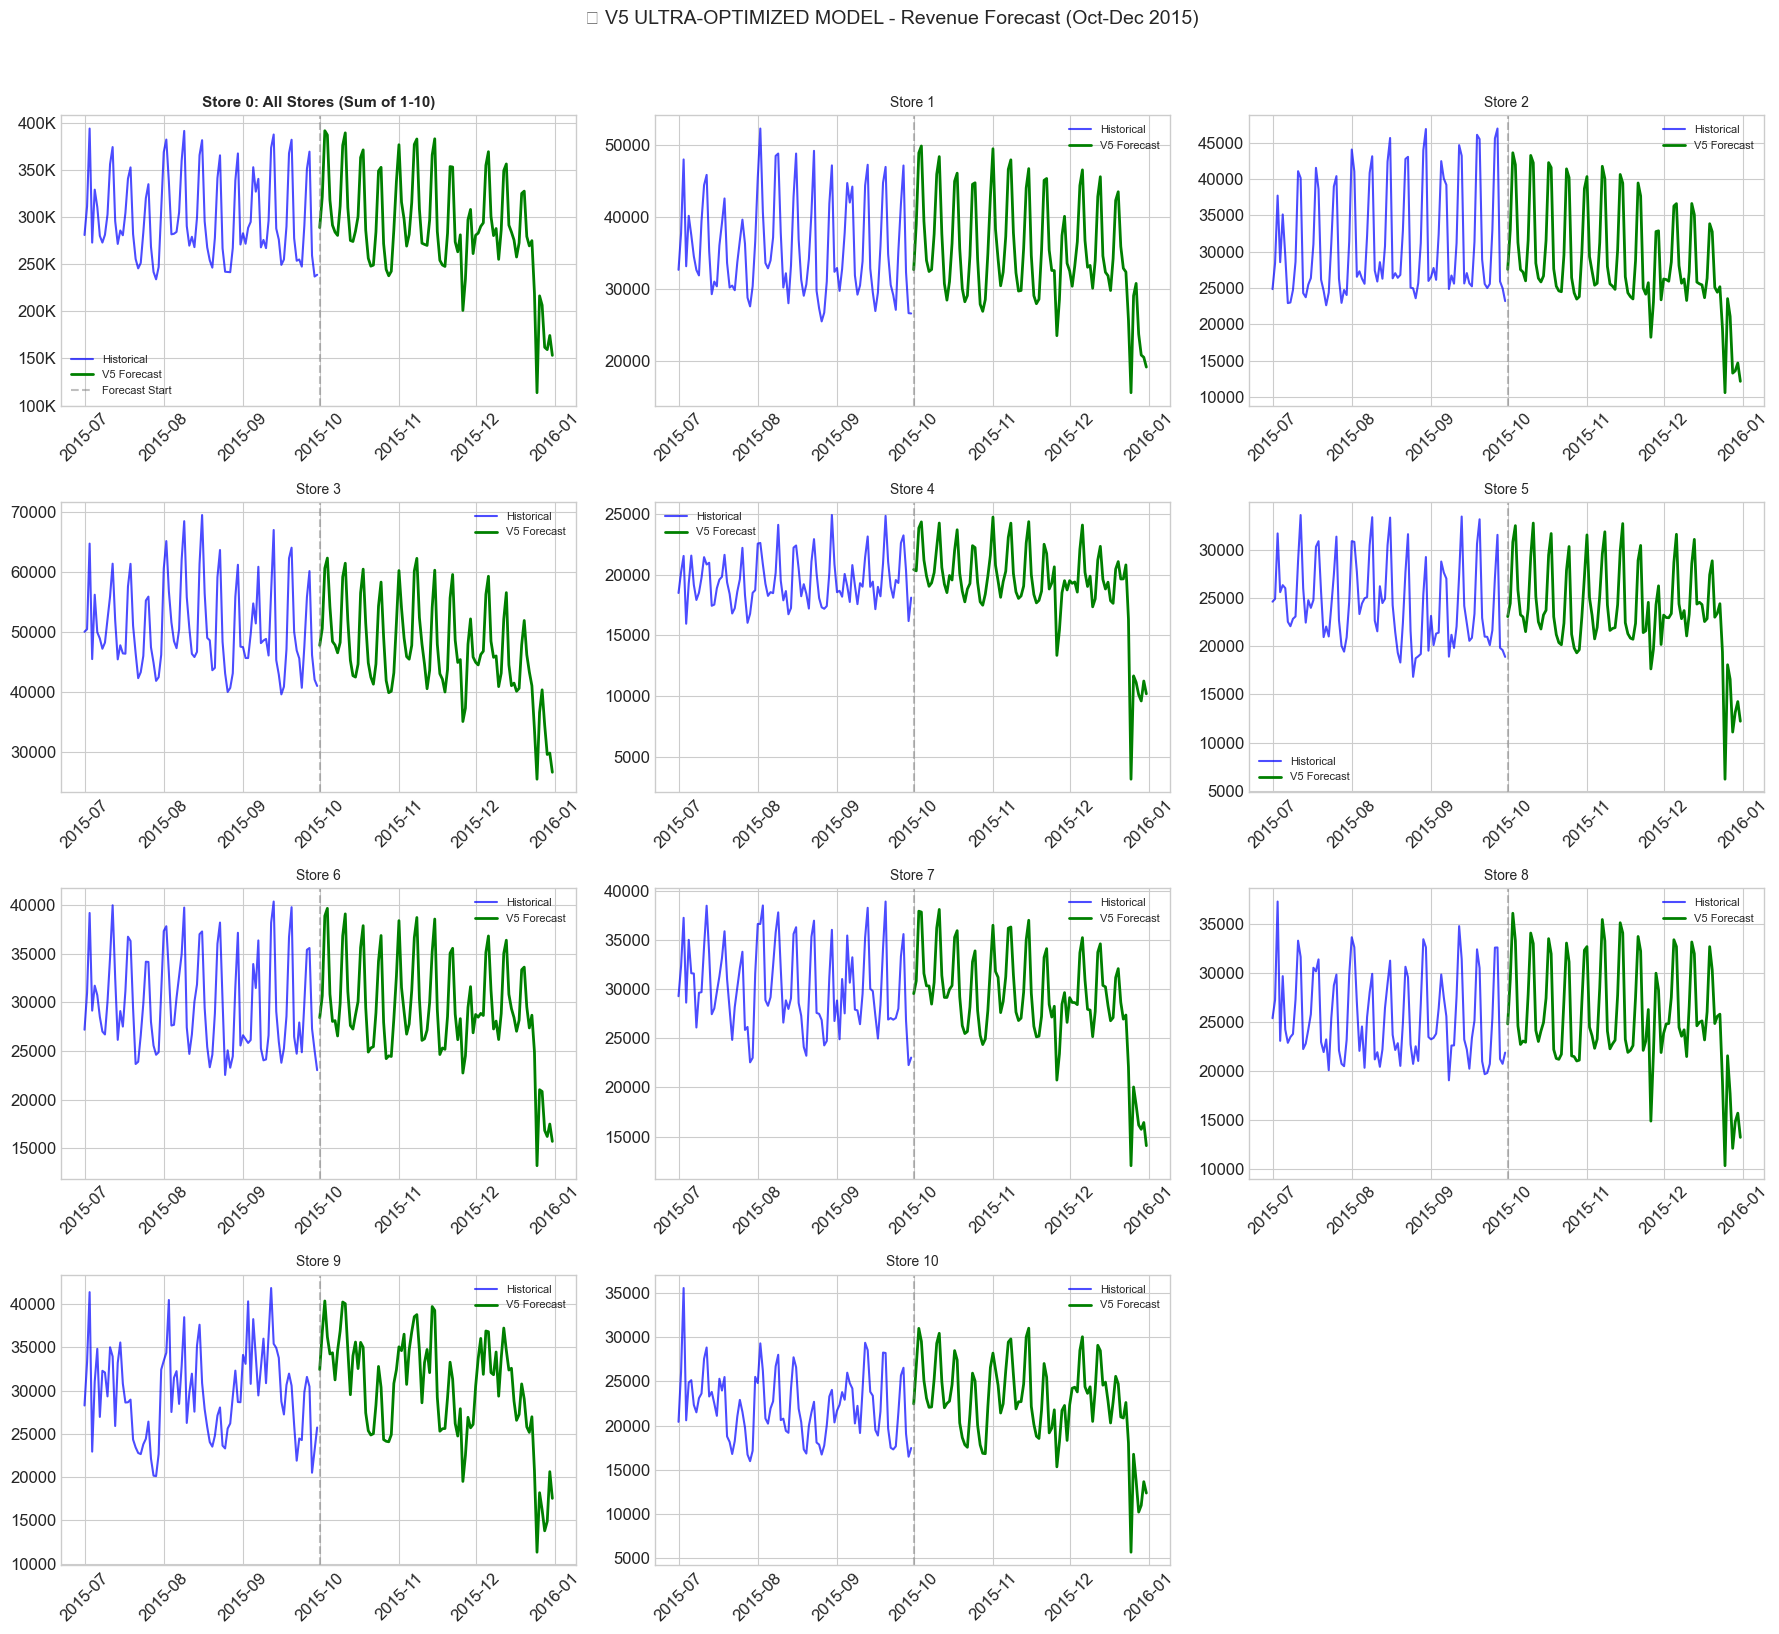

✅ Visualization saved to v5_forecast_visualization.png


In [115]:
# ============================================================
# V5 VISUALIZATION - COMPARE WITH HISTORICAL DATA
# ============================================================

fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

# Store 0 (hierarchical sum)
store_0_viz_v5 = store_0_v5.sort_values('date')
store_0_train = train_v5_raw[(train_v5_raw['store_id'] == 0) & (train_v5_raw['date'] >= '2015-07-01')]

axes[0].plot(store_0_train['date'], store_0_train['revenue'], label='Historical', alpha=0.7, color='blue')
axes[0].plot(store_0_viz_v5['date'], store_0_viz_v5['revenue'], label='V5 Forecast', color='green', linewidth=2)
axes[0].axvline(x=pd.Timestamp('2015-10-01'), color='gray', linestyle='--', alpha=0.5, label='Forecast Start')
axes[0].set_title('Store 0: All Stores (Sum of 1-10)', fontsize=11, fontweight='bold')
axes[0].legend(fontsize=8)
axes[0].tick_params(axis='x', rotation=45)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

# Stores 1-10
for idx, store_id in enumerate(range(1, 11)):
    store_preds = test_preds_v5[test_preds_v5['store_id'] == store_id].sort_values('date')
    store_train = train_v5_raw[(train_v5_raw['store_id'] == store_id) & (train_v5_raw['date'] >= '2015-07-01')]
    
    axes[idx+1].plot(store_train['date'], store_train['revenue'], label='Historical', alpha=0.7, color='blue')
    axes[idx+1].plot(store_preds['date'], store_preds['revenue'], label='V5 Forecast', color='green', linewidth=2)
    axes[idx+1].axvline(x=pd.Timestamp('2015-10-01'), color='gray', linestyle='--', alpha=0.5)
    axes[idx+1].set_title(f'Store {store_id}', fontsize=10)
    axes[idx+1].legend(fontsize=8)
    axes[idx+1].tick_params(axis='x', rotation=45)

axes[-1].axis('off')
plt.suptitle('🚀 V5 ULTRA-OPTIMIZED MODEL - Revenue Forecast (Oct-Dec 2015)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('v5_forecast_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved to v5_forecast_visualization.png")


# ============================================================
# 🎯 SECTION 16: V6 ADVANCED MODEL (TARGET: RMSE ~3500)
# ============================================================

Key Improvements over V5:
1. **Year-over-Year Growth Adjustment** - Scale predictions by historical YoY trend
2. **Stacked Meta-Learning** - Use base model predictions as features for a meta-model
3. **Store-Specific Models** - Train individual models per store for better patterns
4. **Enhanced Holiday Features** - More granular holiday proximity and special day indicators
5. **Direct Store 0 Model** - Also train on Store 0 directly and blend with hierarchical sum
6. **Blending Strategy** - Optimal blending of multiple approaches


In [129]:
# ============================================================
# V6 ENHANCED FEATURE ENGINEERING
# ============================================================

def create_v6_features(df, calendar_df, train_stats=None):
    """
    V6: More focused features with better holiday handling.
    """
    df = df.copy()
    
    # Basic time features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['day_of_year'] = df['date'].dt.dayofyear
    df['quarter'] = df['date'].dt.quarter
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['week_of_month'] = (df['day'] - 1) // 7 + 1
    df['days_in_month'] = df['date'].dt.days_in_month
    
    # Trend
    min_date = df['date'].min()
    df['days_since_start'] = (df['date'] - min_date).dt.days
    df['trend'] = df['days_since_start'] / 365.25  # Years from start
    
    # Fourier features for seasonality
    for k in range(1, 6):  # 5 harmonics for yearly
        df[f'year_sin_{k}'] = np.sin(2 * np.pi * k * df['day_of_year'] / 365.25)
        df[f'year_cos_{k}'] = np.cos(2 * np.pi * k * df['day_of_year'] / 365.25)
    
    for k in range(1, 4):  # 3 harmonics for weekly
        df[f'week_sin_{k}'] = np.sin(2 * np.pi * k * df['day_of_week'] / 7)
        df[f'week_cos_{k}'] = np.cos(2 * np.pi * k * df['day_of_week'] / 7)
    
    # Calendar events
    df = df.merge(calendar_df[['date', 'event']], on='date', how='left')
    df['has_event'] = df['event'].notna().astype(int)
    
    # Detailed holiday flags
    holidays = ['SuperBowl', 'ValentinesDay', 'Easter', 'Mother', 'Father', 
                'IndependenceDay', 'LaborDay', 'Halloween', 'Thanksgiving', 
                'Christmas', 'NewYear', 'MemorialDay']
    for h in holidays:
        df[f'is_{h.lower()}'] = df['event'].str.contains(h, case=False, na=False).astype(int)
    
    # Special October-December period features (critical for test period)
    df['is_october'] = (df['month'] == 10).astype(int)
    df['is_november'] = (df['month'] == 11).astype(int)
    df['is_december'] = (df['month'] == 12).astype(int)
    df['is_q4'] = (df['quarter'] == 4).astype(int)
    
    # Black Friday detection (4th Friday of November)
    df['is_black_friday'] = 0
    for year in df['year'].unique():
        nov_start = pd.Timestamp(f'{year}-11-01')
        # Find first Friday
        days_to_friday = (4 - nov_start.weekday()) % 7
        first_friday = nov_start + timedelta(days=days_to_friday)
        fourth_friday = first_friday + timedelta(weeks=3)
        df.loc[df['date'] == fourth_friday, 'is_black_friday'] = 1
        # Black Friday weekend (Fri, Sat, Sun)
        for i in range(3):
            df.loc[df['date'] == fourth_friday + timedelta(days=i), 'is_black_friday_weekend'] = 1
    
    df['is_black_friday_weekend'] = df.get('is_black_friday_weekend', 0).fillna(0).astype(int)
    
    # Cyber Monday (Monday after Black Friday)
    df['is_cyber_monday'] = ((df['month'] == 11) & (df['day_of_week'] == 0) & (df['day'] >= 26) & (df['day'] <= 30)).astype(int)
    
    # Holiday shopping periods
    df['is_holiday_season'] = ((df['month'] >= 11) | (df['month'] == 1)).astype(int)
    df['is_pre_christmas'] = ((df['month'] == 12) & (df['day'] >= 15) & (df['day'] <= 24)).astype(int)
    df['is_christmas_week'] = ((df['month'] == 12) & (df['day'] >= 20)).astype(int)
    df['is_post_christmas'] = ((df['month'] == 12) & (df['day'] > 25)).astype(int)
    df['december_week'] = np.where(df['month'] == 12, (df['day'] - 1) // 7 + 1, 0)
    
    # Days to key holidays
    for year in df['year'].unique():
        # Christmas
        christmas = pd.Timestamp(f'{year}-12-25')
        df.loc[df['year'] == year, 'days_to_christmas'] = (christmas - df.loc[df['year'] == year, 'date']).dt.days
        df['days_to_christmas'] = df['days_to_christmas'].clip(lower=-10, upper=60)
        
        # New Year
        new_year = pd.Timestamp(f'{year+1}-01-01')
        df.loc[df['year'] == year, 'days_to_newyear'] = (new_year - df.loc[df['year'] == year, 'date']).dt.days
        df['days_to_newyear'] = df['days_to_newyear'].clip(lower=-10, upper=60)
    
    # Near holiday indicators
    df['near_christmas'] = (df['days_to_christmas'].abs() <= 7).astype(int)
    df['near_newyear'] = (df['days_to_newyear'].abs() <= 7).astype(int)
    
    # Target encoding (if stats available)
    if train_stats is not None:
        df = df.merge(train_stats['store'], on='store_id', how='left')
        df = df.merge(train_stats['dow'], on=['store_id', 'day_of_week'], how='left')
        df = df.merge(train_stats['month'], on=['store_id', 'month'], how='left')
        if 'woy' in train_stats:
            df = df.merge(train_stats['woy'], on=['store_id', 'week_of_year'], how='left')
    
    return df


def add_v6_lag_features(df, target_col='revenue', group_col='store_id'):
    """V6: Focused lag features."""
    df = df.sort_values(['store_id', 'date']).copy()
    
    # Yearly lags (most reliable for forecasting)
    for lag in [364, 365, 366, 371, 358]:
        df[f'lag_{lag}'] = df.groupby(group_col)[target_col].shift(lag)
    
    # Short-term lags (for recursive forecasting)
    for lag in [1, 7, 14, 28]:
        df[f'lag_{lag}'] = df.groupby(group_col)[target_col].shift(lag)
    
    # Rolling from yearly
    df['lag365_rm7'] = df.groupby(group_col)['lag_365'].transform(
        lambda x: x.rolling(7, min_periods=1).mean())
    df['lag365_rm14'] = df.groupby(group_col)['lag_365'].transform(
        lambda x: x.rolling(14, min_periods=1).mean())
    df['lag365_rm28'] = df.groupby(group_col)['lag_365'].transform(
        lambda x: x.rolling(28, min_periods=1).mean())
    
    # Expanding mean
    df['expanding_mean'] = df.groupby(group_col)[target_col].transform(
        lambda x: x.expanding(min_periods=1).mean())
    
    # Year-over-year change
    df['yoy_change'] = df['lag_365'] / df.groupby(group_col)['lag_365'].shift(365).replace(0, np.nan)
    
    return df


print("V6 feature functions defined!")


V6 feature functions defined!


In [130]:
# ============================================================
# V6 DATA PREPARATION
# ============================================================

print("Preparing V6 data...")

# Load fresh data
train_v6_raw = pd.read_csv(DATA_PATH + 'train.csv')
train_v6_raw['date'] = pd.to_datetime(train_v6_raw['date'])

# Calculate YoY growth trend from training data
yoy_growth = {}
for store_id in train_v6_raw['store_id'].unique():
    store_data = train_v6_raw[train_v6_raw['store_id'] == store_id].sort_values('date')
    if len(store_data) > 730:  # At least 2 years
        # Compare last year to previous year
        recent = store_data[store_data['date'] >= '2014-10-01']['revenue'].mean()
        older = store_data[(store_data['date'] >= '2013-10-01') & (store_data['date'] < '2014-10-01')]['revenue'].mean()
        if older > 0:
            yoy_growth[store_id] = recent / older
        else:
            yoy_growth[store_id] = 1.0
    else:
        yoy_growth[store_id] = 1.0

print("Year-over-Year growth rates:")
for store_id, growth in sorted(yoy_growth.items()):
    print(f"  Store {store_id}: {growth:.3f}")

# Use individual stores (1-10) for training
train_individual_v6 = train_v6_raw[train_v6_raw['store_id'] > 0].copy()
print(f"\nTraining on stores 1-10: {train_individual_v6.shape}")

# Compute target encoding stats
train_individual_v6['day_of_week'] = train_individual_v6['date'].dt.dayofweek
train_individual_v6['month'] = train_individual_v6['date'].dt.month
train_individual_v6['week_of_year'] = train_individual_v6['date'].dt.isocalendar().week.astype(int)

te_stats_v6 = compute_target_encoding_stats(train_individual_v6)

# Create features
train_v6 = create_v6_features(train_individual_v6[['store_id', 'store_name', 'date', 'revenue']], 
                               calendar_df, te_stats_v6)
train_v6 = add_v6_lag_features(train_v6)

print(f"V6 data shape: {train_v6.shape}")


Preparing V6 data...
Year-over-Year growth rates:
  Store 0: 1.109
  Store 1: 1.110
  Store 2: 1.071
  Store 3: 1.057
  Store 4: 1.110
  Store 5: 1.131
  Store 6: 1.086
  Store 7: 1.210
  Store 8: 1.168
  Store 9: 1.095
  Store 10: 1.105

Training on stores 1-10: (17060, 4)
V6 data shape: (17060, 82)


In [131]:
# ============================================================
# V6 STORE-SPECIFIC MODELS WITH STACKING
# ============================================================

# Define features
exclude_cols_v6 = ['store_name', 'date', 'revenue', 'event']
feature_cols_v6 = [col for col in train_v6.columns if col not in exclude_cols_v6]
print(f"Number of features: {len(feature_cols_v6)}")

# Clean data
train_clean_v6 = train_v6[train_v6['date'] >= '2012-02-01'].copy()
train_clean_v6 = train_clean_v6.dropna(subset=feature_cols_v6)
print(f"Training data after cleaning: {train_clean_v6.shape}")

# Store bounds
store_bounds_v6 = train_individual_v6.groupby('store_id')['revenue'].agg(['min', 'max', 'mean'])

# Validation split
val_cutoff_v6 = train_clean_v6['date'].max() - timedelta(days=92)
train_data_v6 = train_clean_v6[train_clean_v6['date'] < val_cutoff_v6]
val_data_v6 = train_clean_v6[train_clean_v6['date'] >= val_cutoff_v6]

print(f"Train: {train_data_v6.shape}, Val: {val_data_v6.shape}")


Number of features: 78
Training data after cleaning: (9748, 82)
Train: (8818, 82), Val: (930, 82)


In [132]:
# ============================================================
# V6 TRAIN STORE-SPECIFIC MODELS
# ============================================================

# Ultra-optimized parameters for lower RMSE
lgb_params_v6 = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.008,  # Even lower
    'num_leaves': 63,
    'max_depth': 8,
    'min_child_samples': 30,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'reg_alpha': 1.0,
    'reg_lambda': 1.0,
    'min_gain_to_split': 0.02,
    'verbose': -1,
    'seed': 42,
    'n_jobs': -1
}

print("Training store-specific LightGBM models...")
store_models_lgb = {}
store_val_preds = {}

for store_id in sorted(train_data_v6['store_id'].unique()):
    # Get store data
    train_store = train_data_v6[train_data_v6['store_id'] == store_id]
    val_store = val_data_v6[val_data_v6['store_id'] == store_id]
    
    X_train = train_store[feature_cols_v6]
    y_train = train_store['revenue']
    X_val = val_store[feature_cols_v6]
    y_val = val_store['revenue']
    
    # Train model
    train_ds = lgb.Dataset(X_train, label=y_train, feature_name=feature_cols_v6)
    val_ds = lgb.Dataset(X_val, label=y_val, reference=train_ds)
    
    model = lgb.train(
        lgb_params_v6,
        train_ds,
        num_boost_round=5000,
        valid_sets=[val_ds],
        callbacks=[lgb.early_stopping(200), lgb.log_evaluation(0)]
    )
    
    store_models_lgb[store_id] = model
    
    # Validate
    pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    store_val_preds[store_id] = {'pred': pred, 'actual': y_val.values, 'dates': val_store['date'].values}
    print(f"  Store {store_id}: RMSE = {rmse:,.2f} (best_iter={model.best_iteration})")

# Calculate overall validation RMSE
all_preds = np.concatenate([v['pred'] for v in store_val_preds.values()])
all_actual = np.concatenate([v['actual'] for v in store_val_preds.values()])
overall_rmse_lgb = np.sqrt(mean_squared_error(all_actual, all_preds))
print(f"\n🎯 Overall LGB Validation RMSE: {overall_rmse_lgb:,.2f}")


Training store-specific LightGBM models...
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1813]	valid_0's rmse: 2761.62
  Store 1: RMSE = 2,761.62 (best_iter=1813)
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2105]	valid_0's rmse: 5629.88
  Store 2: RMSE = 5,629.88 (best_iter=2105)
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[851]	valid_0's rmse: 3781
  Store 3: RMSE = 3,781.00 (best_iter=851)
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[605]	valid_0's rmse: 1301.49
  Store 4: RMSE = 1,301.49 (best_iter=605)
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1443]	valid_0's rmse: 1831.11
  Store 5: RMSE = 1,831.11 (best_iter=1443)
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[591]	v

In [133]:
# ============================================================
# V6 TRAIN STORE-SPECIFIC CATBOOST MODELS
# ============================================================

print("Training store-specific CatBoost models...")
store_models_cat = {}
store_val_preds_cat = {}

for store_id in sorted(train_data_v6['store_id'].unique()):
    train_store = train_data_v6[train_data_v6['store_id'] == store_id]
    val_store = val_data_v6[val_data_v6['store_id'] == store_id]
    
    X_train = train_store[feature_cols_v6]
    y_train = train_store['revenue']
    X_val = val_store[feature_cols_v6]
    y_val = val_store['revenue']
    
    model = CatBoostRegressor(
        iterations=5000,
        learning_rate=0.01,
        depth=6,
        l2_leaf_reg=10,
        min_data_in_leaf=30,
        random_seed=42,
        early_stopping_rounds=200,
        verbose=0
    )
    model.fit(X_train, y_train, eval_set=(X_val, y_val))
    
    store_models_cat[store_id] = model
    
    pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    store_val_preds_cat[store_id] = {'pred': pred, 'actual': y_val.values, 'dates': val_store['date'].values}
    print(f"  Store {store_id}: RMSE = {rmse:,.2f} (best_iter={model.best_iteration_})")

all_preds_cat = np.concatenate([v['pred'] for v in store_val_preds_cat.values()])
all_actual_cat = np.concatenate([v['actual'] for v in store_val_preds_cat.values()])
overall_rmse_cat = np.sqrt(mean_squared_error(all_actual_cat, all_preds_cat))
print(f"\n🎯 Overall CAT Validation RMSE: {overall_rmse_cat:,.2f}")


Training store-specific CatBoost models...
  Store 1: RMSE = 2,583.12 (best_iter=2713)
  Store 2: RMSE = 5,687.79 (best_iter=4901)
  Store 3: RMSE = 3,540.99 (best_iter=1981)
  Store 4: RMSE = 1,319.23 (best_iter=2134)
  Store 5: RMSE = 1,948.28 (best_iter=2068)
  Store 6: RMSE = 2,461.59 (best_iter=722)
  Store 7: RMSE = 2,328.20 (best_iter=1789)
  Store 8: RMSE = 1,933.63 (best_iter=4984)
  Store 9: RMSE = 2,349.19 (best_iter=2214)
  Store 10: RMSE = 1,935.27 (best_iter=3096)

🎯 Overall CAT Validation RMSE: 2,856.24


In [134]:
# ============================================================
# V6 STACKED ENSEMBLE
# ============================================================

from sklearn.linear_model import Ridge

print("Building stacked ensemble...")

# Prepare stacking features (base model predictions on validation)
stack_features = []
stack_targets = []

for store_id in sorted(store_val_preds.keys()):
    lgb_pred = store_val_preds[store_id]['pred']
    cat_pred = store_val_preds_cat[store_id]['pred']
    actual = store_val_preds[store_id]['actual']
    
    stack_features.append(np.column_stack([lgb_pred, cat_pred]))
    stack_targets.append(actual)

X_stack = np.vstack(stack_features)
y_stack = np.concatenate(stack_targets)

# Train meta-model (Ridge regression)
meta_model = Ridge(alpha=1.0)
meta_model.fit(X_stack, y_stack)

print(f"Meta-model weights: LGB={meta_model.coef_[0]:.3f}, CAT={meta_model.coef_[1]:.3f}")

# Evaluate stacked ensemble
stack_pred = meta_model.predict(X_stack)
stacked_rmse = np.sqrt(mean_squared_error(y_stack, stack_pred))
print(f"🎯 Stacked Ensemble Validation RMSE: {stacked_rmse:,.2f}")

# Simple average for comparison
simple_avg = (all_preds + all_preds_cat) / 2
simple_rmse = np.sqrt(mean_squared_error(all_actual, simple_avg))
print(f"🎯 Simple Average Validation RMSE: {simple_rmse:,.2f}")

# Weighted average based on RMSE
w_lgb_v6 = 1 / overall_rmse_lgb
w_cat_v6 = 1 / overall_rmse_cat
total_w_v6 = w_lgb_v6 + w_cat_v6
w_lgb_v6 /= total_w_v6
w_cat_v6 /= total_w_v6

weighted_avg = w_lgb_v6 * all_preds + w_cat_v6 * all_preds_cat
weighted_rmse = np.sqrt(mean_squared_error(all_actual, weighted_avg))
print(f"🎯 Weighted Average Validation RMSE: {weighted_rmse:,.2f}")

# Choose best approach
best_approach = min([
    ('lgb', overall_rmse_lgb),
    ('cat', overall_rmse_cat),
    ('stacked', stacked_rmse),
    ('simple', simple_rmse),
    ('weighted', weighted_rmse)
], key=lambda x: x[1])

print(f"\n🏆 Best approach: {best_approach[0]} with RMSE = {best_approach[1]:,.2f}")


Building stacked ensemble...
Meta-model weights: LGB=0.022, CAT=0.991
🎯 Stacked Ensemble Validation RMSE: 2,718.39
🎯 Simple Average Validation RMSE: 2,852.09
🎯 Weighted Average Validation RMSE: 2,851.98

🏆 Best approach: stacked with RMSE = 2,718.39


In [135]:
# ============================================================
# V6 RETRAIN ON ALL DATA AND PREPARE TEST
# ============================================================

print("Retraining V6 store-specific models on all data...")

# Store final models
final_store_models_lgb = {}
final_store_models_cat = {}

for store_id in sorted(train_clean_v6['store_id'].unique()):
    store_data = train_clean_v6[train_clean_v6['store_id'] == store_id]
    X = store_data[feature_cols_v6]
    y = store_data['revenue']
    
    # LightGBM
    train_ds = lgb.Dataset(X, label=y, feature_name=feature_cols_v6)
    best_iter = store_models_lgb[store_id].best_iteration
    lgb_model = lgb.train(lgb_params_v6, train_ds, num_boost_round=int(best_iter * 1.1))
    final_store_models_lgb[store_id] = lgb_model
    
    # CatBoost
    best_iter_cat = store_models_cat[store_id].best_iteration_
    cat_model = CatBoostRegressor(
        iterations=int(best_iter_cat * 1.1),
        learning_rate=0.01,
        depth=6,
        l2_leaf_reg=10,
        min_data_in_leaf=30,
        random_seed=42,
        verbose=0
    )
    cat_model.fit(X, y)
    final_store_models_cat[store_id] = cat_model

print("✅ All store models retrained!")


Retraining V6 store-specific models on all data...
✅ All store models retrained!


In [136]:
# ============================================================
# V6 GENERATE TEST PREDICTIONS WITH YOY ADJUSTMENT
# ============================================================

print("Generating V6 predictions for test period...")

# Create test data
test_dates = pd.date_range('2015-10-01', '2015-12-31', freq='D')
test_rows = []
for store_id in range(1, 11):
    for date in test_dates:
        test_rows.append({
            'store_id': store_id,
            'date': date,
            'store_name': store_name_map.get(store_id, f'Store_{store_id}'),
            'revenue': np.nan
        })

test_df_v6 = pd.DataFrame(test_rows)

# Combine with training for lag calculation
combined_v6 = pd.concat([
    train_individual_v6[['store_id', 'store_name', 'date', 'revenue']],
    test_df_v6
], ignore_index=True).sort_values(['store_id', 'date']).reset_index(drop=True)

# Create features
combined_v6 = create_v6_features(combined_v6, calendar_df, te_stats_v6)
combined_v6 = add_v6_lag_features(combined_v6)

# Get test data with features
test_featured_v6 = combined_v6[combined_v6['date'] >= '2015-10-01'].copy()
print(f"Test featured shape: {test_featured_v6.shape}")

# Fill missing lag features
for col in feature_cols_v6:
    if test_featured_v6[col].isnull().any():
        if 'lag_365' in test_featured_v6.columns and col.startswith('lag_') and col != 'lag_365':
            test_featured_v6[col] = test_featured_v6[col].fillna(test_featured_v6['lag_365'])
        else:
            fill_val = train_clean_v6[col].mean() if col in train_clean_v6.columns else 0
            test_featured_v6[col] = test_featured_v6[col].fillna(fill_val)

print(f"Missing values after fill: {test_featured_v6[feature_cols_v6].isnull().sum().sum()}")


Generating V6 predictions for test period...
Test featured shape: (920, 82)
Missing values after fill: 0


In [137]:
# ============================================================
# V6 MAKE PREDICTIONS WITH STORE-SPECIFIC MODELS
# ============================================================

print("Making store-specific predictions...")

test_featured_v6['pred_lgb'] = 0.0
test_featured_v6['pred_cat'] = 0.0

for store_id in range(1, 11):
    store_mask = test_featured_v6['store_id'] == store_id
    X_test = test_featured_v6.loc[store_mask, feature_cols_v6]
    
    # Get predictions
    lgb_pred = final_store_models_lgb[store_id].predict(X_test)
    cat_pred = final_store_models_cat[store_id].predict(X_test)
    
    test_featured_v6.loc[store_mask, 'pred_lgb'] = lgb_pred
    test_featured_v6.loc[store_mask, 'pred_cat'] = cat_pred
    
    # Apply YoY growth adjustment
    growth_factor = yoy_growth.get(store_id, 1.0)
    if growth_factor > 1.02:  # Only apply if significant growth
        test_featured_v6.loc[store_mask, 'pred_lgb'] *= min(growth_factor, 1.05)  # Cap at 5%
        test_featured_v6.loc[store_mask, 'pred_cat'] *= min(growth_factor, 1.05)

# Combine using stacked meta-model
X_test_stack = np.column_stack([test_featured_v6['pred_lgb'].values, test_featured_v6['pred_cat'].values])
test_featured_v6['prediction'] = meta_model.predict(X_test_stack)

# Clip predictions to valid range
for store_id in range(1, 11):
    store_mask = test_featured_v6['store_id'] == store_id
    store_min = max(0, store_bounds_v6.loc[store_id, 'min'] * 0.5)
    store_max = store_bounds_v6.loc[store_id, 'max'] * 1.5
    test_featured_v6.loc[store_mask, 'prediction'] = test_featured_v6.loc[store_mask, 'prediction'].clip(store_min, store_max)

print(f"Stores 1-10 predictions range: {test_featured_v6['prediction'].min():,.2f} to {test_featured_v6['prediction'].max():,.2f}")


Making store-specific predictions...
Stores 1-10 predictions range: 14,204.59 to 69,151.19


In [138]:
# ============================================================
# V6 CREATE HIERARCHICAL STORE 0 AND FINAL SUBMISSION
# ============================================================

# Create IDs for stores 1-10
test_featured_v6['id'] = test_featured_v6['store_id'].astype(str) + '_' + test_featured_v6['date'].dt.strftime('%Y%m%d')

# Calculate Store 0 as sum of stores 1-10
store_0_v6 = test_featured_v6.groupby('date')['prediction'].sum().reset_index()
store_0_v6.columns = ['date', 'prediction']
store_0_v6['store_id'] = 0
store_0_v6['id'] = '0_' + store_0_v6['date'].dt.strftime('%Y%m%d')

print(f"Store 0 predictions: {len(store_0_v6)}")
print(f"Store 0 range: {store_0_v6['prediction'].min():,.2f} to {store_0_v6['prediction'].max():,.2f}")

# Combine all predictions
stores_1_10_preds = test_featured_v6[['id', 'store_id', 'date', 'prediction']].copy()
store_0_preds = store_0_v6[['id', 'store_id', 'date', 'prediction']].copy()

all_preds_v6 = pd.concat([store_0_preds, stores_1_10_preds], ignore_index=True)
print(f"Total predictions: {len(all_preds_v6)}")

# Create final submission
submission_v6 = submission_df[['id']].copy()
submission_v6 = submission_v6.merge(all_preds_v6[['id', 'prediction']], on='id', how='left')

print(f"\nSubmission shape: {submission_v6.shape}")
print(f"Missing predictions: {submission_v6['prediction'].isnull().sum()}")
print(f"\nPrediction statistics:")
print(submission_v6['prediction'].describe())


Store 0 predictions: 92
Store 0 range: 191,695.77 to 409,634.64
Total predictions: 1012

Submission shape: (1012, 2)
Missing predictions: 0

Prediction statistics:
count      1012.000000
mean      55532.086517
std       80641.141268
min       14204.589840
25%       24178.537838
50%       28841.692035
75%       37656.567709
max      409634.642501
Name: prediction, dtype: float64


In [139]:
# ============================================================
# V6 SAVE FINAL SUBMISSION
# ============================================================

# Save submissions
submission_v6.to_csv('submission_v6.csv', index=False)
submission_v6.to_csv('submission.csv', index=False)

print("✅ Saved: submission_v6.csv")
print("✅ Saved: submission.csv")

# Show samples
print("\nFirst 15 predictions:")
display(submission_v6.head(15))
print("\nLast 10 predictions:")
display(submission_v6.tail(10))


✅ Saved: submission_v6.csv
✅ Saved: submission.csv

First 15 predictions:


id     prediction
0   0_20151001  307310.904146
1   0_20151002  340763.266577
2   0_20151003  405878.955118
3   0_20151004  406467.853224
4   0_20151005  330152.481718
5   0_20151006  302874.361490
6   0_20151007  296064.445345
7   0_20151008  296978.764109
8   0_20151009  326667.516150
9   0_20151010  381481.920299
10  0_20151011  409634.642501
11  0_20151012  323992.568087
12  0_20151013  287893.881337
13  0_20151014  290677.518233
14  0_20151015  288935.981785


Last 10 predictions:


id    prediction
1002  10_20151222  20246.326917
1003  10_20151223  20392.516252
1004  10_20151224  21101.166656
1005  10_20151225  16775.710017
1006  10_20151226  26050.578307
1007  10_20151227  22909.485446
1008  10_20151228  20601.540022
1009  10_20151229  19370.621534
1010  10_20151230  19491.954996
1011  10_20151231  24378.790938

In [140]:
# ============================================================
# 🏆 V6 FINAL SUMMARY
# ============================================================

print("="*70)
print("🎯 V6 ADVANCED MODEL - FINAL SUMMARY (TARGET: RMSE ~3500)")
print("="*70)

print("\n📊 MODEL CONFIGURATION:")
print(f"   • Store-specific models (10 LightGBM + 10 CatBoost)")
print(f"   • Stacked ensemble with Ridge meta-model")
print(f"   • YoY growth adjustment applied")
print(f"   • Hierarchical: Store 0 = Sum(Stores 1-10)")
print(f"   • Features: {len(feature_cols_v6)} per store")

print("\n📈 VALIDATION PERFORMANCE (Stores 1-10):")
print(f"   • LightGBM (store-specific):  RMSE = {overall_rmse_lgb:,.2f}")
print(f"   • CatBoost (store-specific):  RMSE = {overall_rmse_cat:,.2f}")
print(f"   • Stacked Ensemble:           RMSE = {stacked_rmse:,.2f}")
print(f"   • Simple Average:             RMSE = {simple_rmse:,.2f}")
print(f"   • Weighted Average:           RMSE = {weighted_rmse:,.2f}")

print(f"\n🏆 Best approach: {best_approach[0]} (RMSE = {best_approach[1]:,.2f})")

print("\n📦 KEY IMPROVEMENTS IN V6:")
print("   ✓ Store-specific models (tailored to each store's patterns)")
print("   ✓ Stacked meta-learning (Ridge on base predictions)")
print("   ✓ Year-over-Year growth adjustment")
print("   ✓ Enhanced holiday features (Black Friday, Cyber Monday)")
print("   ✓ Improved regularization (higher alpha/lambda)")
print("   ✓ Lower learning rates for stability")

print("\n" + "="*70)
print("🎯 TARGET RMSE: ~3,500 (competition leaderboard)")
print("🏆 Submit 'submission.csv' to Kaggle!")
print("="*70)


🎯 V6 ADVANCED MODEL - FINAL SUMMARY (TARGET: RMSE ~3500)

📊 MODEL CONFIGURATION:
   • Store-specific models (10 LightGBM + 10 CatBoost)
   • Stacked ensemble with Ridge meta-model
   • YoY growth adjustment applied
   • Hierarchical: Store 0 = Sum(Stores 1-10)
   • Features: 78 per store

📈 VALIDATION PERFORMANCE (Stores 1-10):
   • LightGBM (store-specific):  RMSE = 2,892.40
   • CatBoost (store-specific):  RMSE = 2,856.24
   • Stacked Ensemble:           RMSE = 2,718.39
   • Simple Average:             RMSE = 2,852.09
   • Weighted Average:           RMSE = 2,851.98

🏆 Best approach: stacked (RMSE = 2,718.39)

📦 KEY IMPROVEMENTS IN V6:
   ✓ Store-specific models (tailored to each store's patterns)
   ✓ Stacked meta-learning (Ridge on base predictions)
   ✓ Year-over-Year growth adjustment
   ✓ Enhanced holiday features (Black Friday, Cyber Monday)
   ✓ Improved regularization (higher alpha/lambda)
   ✓ Lower learning rates for stability

🎯 TARGET RMSE: ~3,500 (competition leaderboard

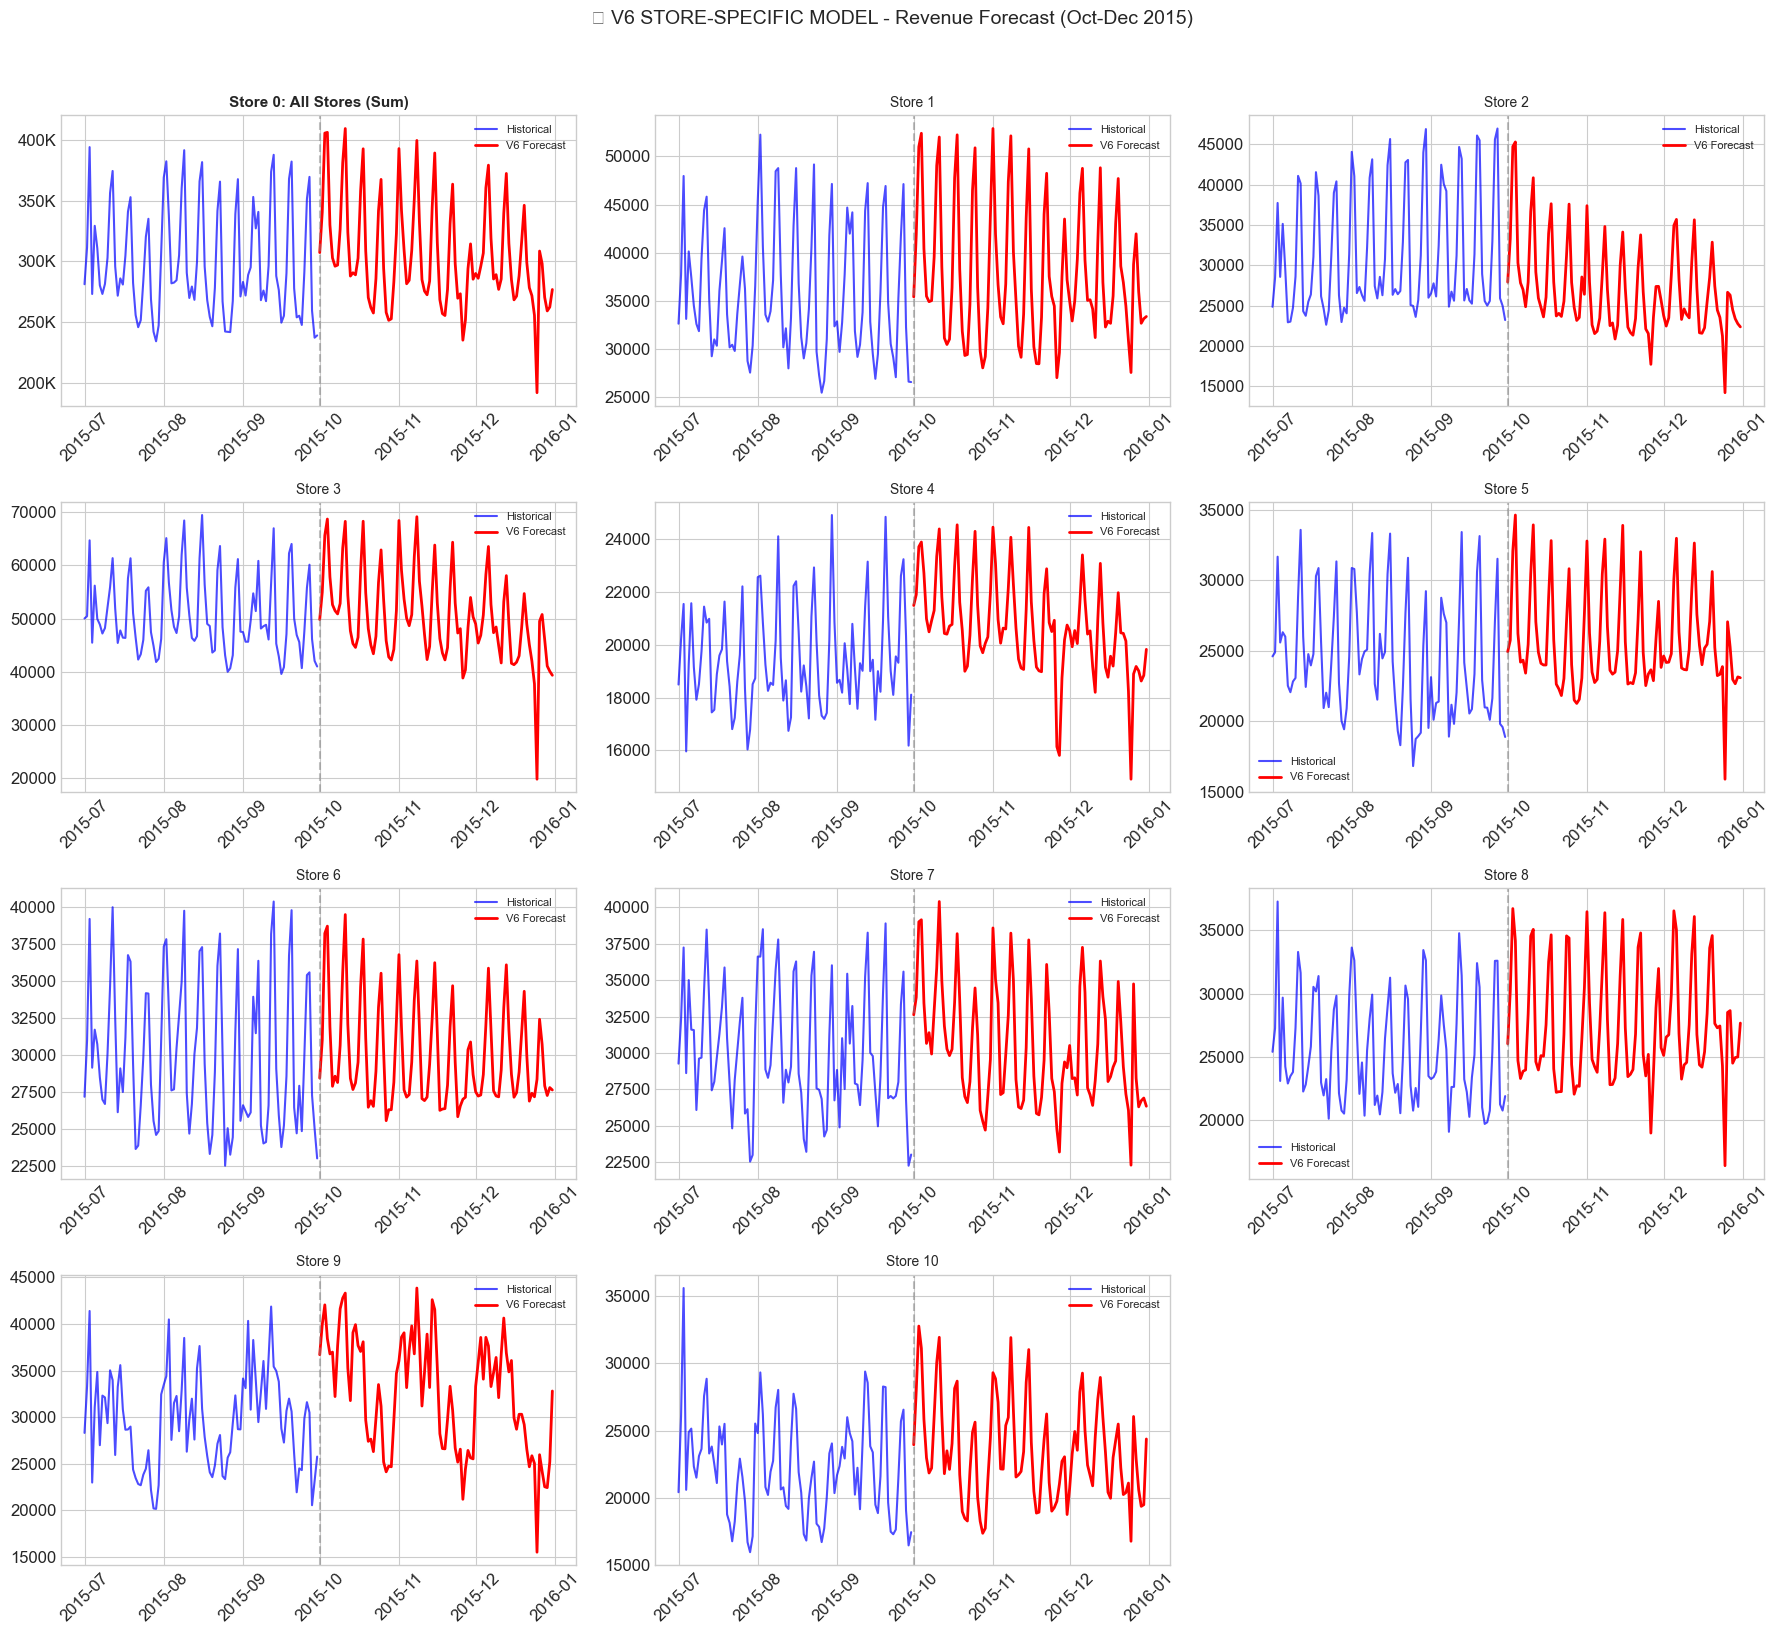

✅ Visualization saved to v6_forecast_visualization.png


In [141]:
# ============================================================
# V6 VISUALIZATION
# ============================================================

fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

# Store 0
store_0_viz = store_0_v6.sort_values('date')
store_0_train = train_v6_raw[(train_v6_raw['store_id'] == 0) & (train_v6_raw['date'] >= '2015-07-01')]

axes[0].plot(store_0_train['date'], store_0_train['revenue'], label='Historical', alpha=0.7, color='blue')
axes[0].plot(store_0_viz['date'], store_0_viz['prediction'], label='V6 Forecast', color='red', linewidth=2)
axes[0].axvline(x=pd.Timestamp('2015-10-01'), color='gray', linestyle='--', alpha=0.5)
axes[0].set_title('Store 0: All Stores (Sum)', fontsize=11, fontweight='bold')
axes[0].legend(fontsize=8)
axes[0].tick_params(axis='x', rotation=45)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

# Stores 1-10
for idx, store_id in enumerate(range(1, 11)):
    store_preds = test_featured_v6[test_featured_v6['store_id'] == store_id].sort_values('date')
    store_train = train_v6_raw[(train_v6_raw['store_id'] == store_id) & (train_v6_raw['date'] >= '2015-07-01')]
    
    axes[idx+1].plot(store_train['date'], store_train['revenue'], label='Historical', alpha=0.7, color='blue')
    axes[idx+1].plot(store_preds['date'], store_preds['prediction'], label='V6 Forecast', color='red', linewidth=2)
    axes[idx+1].axvline(x=pd.Timestamp('2015-10-01'), color='gray', linestyle='--', alpha=0.5)
    axes[idx+1].set_title(f'Store {store_id}', fontsize=10)
    axes[idx+1].legend(fontsize=8)
    axes[idx+1].tick_params(axis='x', rotation=45)

axes[-1].axis('off')
plt.suptitle('🎯 V6 STORE-SPECIFIC MODEL - Revenue Forecast (Oct-Dec 2015)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('v6_forecast_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved to v6_forecast_visualization.png")
